In [1]:
# example of defining a u-net encoder-decoder generator model
import os
import random
from random import randint
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
plt.style.use("grayscale")
%matplotlib inline
#%matplotlib notebook
import time

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from skimage import color

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.losses import mean_absolute_error
import keras.backend as K

from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [2]:
def get_data(path, to_lab = False):
    ids_x = next(os.walk(path + "TRM"))[2]
    ids_x.sort()
    ids_y = next(os.walk(path + "RGB"))[2]
    ids_y.sort()
    X = np.zeros((len(ids_x), im_height, im_width, 1), dtype=np.float32)
    y = np.zeros((len(ids_y), im_height, im_width, 3), dtype=np.float32)
    
    for n, id_x in tqdm_notebook(enumerate(ids_x), total=len(ids_x)):
        id_y = ids_y[n]
        # Load images
        #img = load_img(path + '/TRM/' + id_x, grayscale=True)
        #x_img = img_to_array(img)
        img = cv.imread(path + '/TRM/' + id_x,cv.COLOR_BGR2GRAY)
        x_img = np.array(img)
        x_img = (x_img - x_img.min()) / (x_img.max() - x_img.min())
        x_img = resize(x_img, (im_height, im_width, 1), mode='constant', preserve_range=True)
        mask = img_to_array(load_img(path + '/RGB/' + id_y, color_mode="rgb"))
        mask = resize(mask, (im_height, im_width, 3), mode='constant', preserve_range=True)
        if to_lab:
            mask = color.rgb2lab(mask)
            #mask = lab_rescale(mask, False)
        else:
            y[n] = mask / 255
        
        X[n, ..., 0] = x_img.squeeze()
        
    return X, y

In [3]:
def lab_rescale(im, to100):
    if to100:
        im[:,:,:,0] = im[:,:,:,0]*100.0
        im[:,:,:,1] = im[:,:,:,1]*185.0 - 87.0
        im[:,:,:,2] = im[:,:,:,2]*203.0 - 108.0
        return im
    else:
        im[:,:,0] = im[:,:,0]/100.0
        im[:,:,1] = (im[:,:,1] + 87.0)/185.0
        im[:,:,2] = (im[:,:,2] + 108.0)/203.0
        return im


In [6]:
def get_data_lab(path,im_height,im_width):
    ids_x = next(os.walk(path + "TRM"))[2]
    ids_x.sort()
    ids_y = next(os.walk(path + "RGB"))[2]
    ids_y.sort()
    X = np.zeros((len(ids_x), im_height, im_width, 1), dtype=np.float32)
    y = np.zeros((len(ids_y), im_height, im_width, 3), dtype=np.float32)
    
    for n, id_x in tqdm_notebook(enumerate(ids_x), total=len(ids_x)):
        id_y = ids_y[n]
        # Load images
        #img = load_img(path + '/TRM/' + id_x, grayscale=True)
        #x_img = img_to_array(img)
        img = cv.imread(path + '/TRM/' + id_x,cv.COLOR_BGR2GRAY)
        x_img = np.array(img)
        x_img = (x_img - x_img.min()) / (x_img.max() - x_img.min())
        x_img = resize(x_img, (im_height, im_width, 1), mode='constant', preserve_range=True)
        rgb_image = img_to_array(load_img(path + '/RGB/' + id_y, color_mode="rgb"))
        # lab_image = color.rgb2lab(rgb_image)
        lab_image = resize(lab_image, (im_height, im_width, 3), mode='constant', preserve_range=True)
        # lab_image = lab_rescale(lab_image, False)
        
        #mask = resize(mask, (im_height, im_width, 1), mode='constant', preserve_range=True)
        
        X[n, ..., 0] = x_img.squeeze()
        y[n] = lab_image
        
    return X, y

# Discriminator

In [7]:
def define_discriminator(t_image_shape, c_image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=t_image_shape)
	# target image input
	in_target_image = Input(shape=c_image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# Generator blocks

In [8]:
# Encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g
 
# Decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# Generator model

In [9]:
def define_generator(image_shape=(256,256,1)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model


# GAN model

In [10]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

In [11]:
def generate_real_samples(train_crops, n_samples, patch_shape):
    # choose random instances
    ix = randint(0, X.shape[0]-1)
    # retrieve selected images
    x, y = next(train_crops)
    if len(x.shape) != 4:
        x = np.expand_dims(x, axis=0)
        y = np.expand_dims(y, axis=0)
    z = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [x, y], z

def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	z = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, z


In [12]:
def random_crop(it,ic, random_crop_size):
    # Note: image_data_format is 'channel_last'
    height, width = it.shape[0], it.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    crop_it = it[y:(y+dy), x:(x+dx), :]
    crop_ic = ic[y:(y+dy), x:(x+dx), :]
    return crop_it, crop_ic


def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crop_x = np.zeros((batch_x.shape[0], crop_length, crop_length, 1))
        batch_crop_y = np.zeros((batch_y.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crop_x[i], batch_crop_y[i] = random_crop(batch_x[i], batch_y[i], (crop_length, crop_length))
        yield (batch_crop_x, batch_crop_y)

In [13]:
def plot_sample(train_crops, g_model, i, to_lab=False):
    x, y = next(train_crops)
    xi = g_model.predict(x)
    yim = y
    if to_lab:
            yim = color.lab2rgb(yim)
            xi = color.lab2rgb(xi.squeeze())
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(x.squeeze())
    ax[0].set_title('IT')

    ax[2].imshow(yim.squeeze())
    ax[2].set_title('Color')

    ax[1].imshow(xi.squeeze())
    ax[1].set_title('Pred')
    return xi

# Train function

In [14]:
# train pix2pix models
def train(d_model, g_model, gan_model, train_crops, n_steps):
    save_num = 80
    n_batch=1; n_patch=16
    g_l1_min = 100
    g_cross_min = 100
    d1 = []; d2 = []; g1 = []; g2 = []; g3 = [];
    ds1 = 0; ds2 = 0; gs1 = 0; gs2 = 0; gs3 = 0;
    # manually enumerate epochs
    for i in range(n_steps):
        start_time = time.time()
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(train_crops, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_total, g_cross, g_l1 = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        ds1 += d_loss1; ds2 += d_loss2; gs1 += g_total; gs2 += g_cross; gs3 += g_l1;
        print('>%d, d_real[%.3f] d_fake[%.3f] g_total[%.3f] g_cross[%.3f] g_l1[%.3f] %.3f[sec]' % (i, d_loss1, d_loss2, g_total, g_cross, g_l1, time.time()-start_time))
        # summarize performance
        if i % 10 == 0:
            if g_l1 < g_l1_min:
                    g_model.save_weights('g_model_l1_best-salt_cut.h5')
                    g_l1_min = g_l1
            if g_cross < g_cross_min:
                    g_model.save_weights('g_model_cross_best-salt_cut.h5')
                    g_cross_min = g_cross 
                
        if i % save_num == 0:
            g_model.save_weights('g_model_l1-salt_cut1.1.h5')
            d_model.save_weights('d_model_l1-salt_cut1.1.h5')
            
            d1.append(ds1/save_num);d2.append(ds2/save_num);g1.append(gs1/save_num);g2.append(gs2/save_num);g3.append(gs3/save_num);
            ds1 = 0; ds2 = 0; gs1 = 0; gs2 = 0; gs3 = 0;
    
    return d1, d2, g1, g2, g3

In [15]:
im_width = 640; im_height = 512
border = 5
path_train = '../../../data/FLIR/training/Calib_cut/'
X,Y = get_data(path_train)
# X,Y = get_data_lab(path_train,im_width,im_height)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=20/1040,random_state=2019)
#X_test,Y_test = get_data(path_test)

/opt/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [16]:
# define image shape
t_image_shape = (256,256,1);c_image_shape = (256,256,3)
# define the models
d_model = define_discriminator(t_image_shape, c_image_shape)
g_model = define_generator(t_image_shape)
g_model.load_weights('g_model_l1-salt_cut1.h5')
d_model.load_weights('d_model_l1-salt_cut1.h5')
# define the composite model
gan_model = define_gan(g_model, d_model, t_image_shape)
# summarize the model
# gan_model.summary()
# plot the model
# plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

data_gen_args = dict(horizontal_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)        

yimage_generator = image_datagen.flow(y_train, seed=2019, batch_size=1, shuffle=True)
Ximage_generator = image_datagen.flow(X_train, seed=2019, batch_size=1, shuffle=True)

train_generator = zip(Ximage_generator, yimage_generator)
train_crops = crop_generator(train_generator, 256)

In [73]:
d1, d2, g1, g2, g3 = train(d_model, g_model, gan_model, train_crops, 53472)

>0, d_real[0.003] d_fake[0.073] g_total[14.776] g_cross[3.117] g_l1[0.117] 0.168[sec]
>1, d_real[0.071] d_fake[0.118] g_total[12.409] g_cross[2.769] g_l1[0.096] 0.163[sec]
>2, d_real[0.848] d_fake[0.235] g_total[9.421] g_cross[1.556] g_l1[0.079] 0.160[sec]
>3, d_real[0.014] d_fake[0.057] g_total[22.428] g_cross[2.784] g_l1[0.196] 0.161[sec]
>4, d_real[0.009] d_fake[0.040] g_total[11.064] g_cross[3.742] g_l1[0.073] 0.159[sec]
>5, d_real[0.006] d_fake[0.174] g_total[23.231] g_cross[3.453] g_l1[0.198] 0.155[sec]
>6, d_real[0.013] d_fake[0.102] g_total[14.996] g_cross[2.866] g_l1[0.121] 0.157[sec]
>7, d_real[0.026] d_fake[0.007] g_total[17.915] g_cross[4.111] g_l1[0.138] 0.159[sec]
>8, d_real[0.883] d_fake[0.401] g_total[12.518] g_cross[2.076] g_l1[0.104] 0.157[sec]
>9, d_real[0.118] d_fake[0.113] g_total[12.620] g_cross[2.280] g_l1[0.103] 0.163[sec]
>10, d_real[0.016] d_fake[0.417] g_total[12.786] g_cross[3.641] g_l1[0.091] 0.156[sec]
>11, d_real[0.826] d_fake[0.043] g_total[14.071] g_cro

>95, d_real[0.019] d_fake[0.069] g_total[16.623] g_cross[3.660] g_l1[0.130] 0.157[sec]
>96, d_real[0.004] d_fake[0.047] g_total[7.220] g_cross[3.068] g_l1[0.042] 0.158[sec]
>97, d_real[0.080] d_fake[0.064] g_total[10.595] g_cross[3.078] g_l1[0.075] 0.157[sec]
>98, d_real[0.013] d_fake[0.209] g_total[11.989] g_cross[3.257] g_l1[0.087] 0.157[sec]
>99, d_real[0.315] d_fake[0.547] g_total[10.715] g_cross[3.325] g_l1[0.074] 0.157[sec]
>100, d_real[0.223] d_fake[0.047] g_total[10.237] g_cross[3.164] g_l1[0.071] 0.157[sec]
>101, d_real[0.470] d_fake[0.059] g_total[7.330] g_cross[1.832] g_l1[0.055] 0.156[sec]
>102, d_real[0.055] d_fake[0.042] g_total[12.872] g_cross[3.683] g_l1[0.092] 0.158[sec]
>103, d_real[0.007] d_fake[0.014] g_total[11.218] g_cross[4.245] g_l1[0.070] 0.159[sec]
>104, d_real[0.010] d_fake[0.052] g_total[11.015] g_cross[3.257] g_l1[0.078] 0.155[sec]
>105, d_real[0.062] d_fake[0.087] g_total[13.377] g_cross[3.482] g_l1[0.099] 0.157[sec]
>106, d_real[0.177] d_fake[0.058] g_tot

>189, d_real[0.000] d_fake[0.105] g_total[7.985] g_cross[2.742] g_l1[0.052] 0.160[sec]
>190, d_real[0.533] d_fake[0.378] g_total[8.717] g_cross[3.064] g_l1[0.057] 0.155[sec]
>191, d_real[0.120] d_fake[0.138] g_total[7.699] g_cross[2.703] g_l1[0.050] 0.160[sec]
>192, d_real[0.018] d_fake[0.029] g_total[13.795] g_cross[3.918] g_l1[0.099] 0.157[sec]
>193, d_real[0.007] d_fake[0.230] g_total[12.187] g_cross[3.803] g_l1[0.084] 0.157[sec]
>194, d_real[0.002] d_fake[0.097] g_total[26.537] g_cross[3.606] g_l1[0.229] 0.155[sec]
>195, d_real[0.266] d_fake[0.062] g_total[8.486] g_cross[2.630] g_l1[0.059] 0.157[sec]
>196, d_real[0.008] d_fake[0.009] g_total[16.090] g_cross[4.030] g_l1[0.121] 0.155[sec]
>197, d_real[0.739] d_fake[0.312] g_total[13.864] g_cross[3.154] g_l1[0.107] 0.161[sec]
>198, d_real[0.009] d_fake[0.086] g_total[11.406] g_cross[3.774] g_l1[0.076] 0.155[sec]
>199, d_real[0.089] d_fake[0.181] g_total[8.937] g_cross[3.295] g_l1[0.056] 0.157[sec]
>200, d_real[0.012] d_fake[0.030] g_t

>283, d_real[0.058] d_fake[0.006] g_total[14.761] g_cross[4.691] g_l1[0.101] 0.158[sec]
>284, d_real[0.145] d_fake[0.350] g_total[14.137] g_cross[4.262] g_l1[0.099] 0.157[sec]
>285, d_real[1.002] d_fake[0.049] g_total[8.607] g_cross[2.327] g_l1[0.063] 0.157[sec]
>286, d_real[0.024] d_fake[0.637] g_total[13.132] g_cross[5.435] g_l1[0.077] 0.155[sec]
>287, d_real[0.018] d_fake[0.022] g_total[11.197] g_cross[4.280] g_l1[0.069] 0.156[sec]
>288, d_real[0.310] d_fake[0.047] g_total[11.435] g_cross[2.633] g_l1[0.088] 0.155[sec]
>289, d_real[0.002] d_fake[0.051] g_total[12.426] g_cross[3.525] g_l1[0.089] 0.157[sec]
>290, d_real[0.009] d_fake[0.194] g_total[10.509] g_cross[3.596] g_l1[0.069] 0.157[sec]
>291, d_real[0.032] d_fake[0.036] g_total[15.898] g_cross[3.433] g_l1[0.125] 0.158[sec]
>292, d_real[0.593] d_fake[0.354] g_total[8.319] g_cross[2.795] g_l1[0.055] 0.157[sec]
>293, d_real[0.098] d_fake[0.052] g_total[12.175] g_cross[3.183] g_l1[0.090] 0.158[sec]
>294, d_real[0.033] d_fake[0.011] 

>377, d_real[0.008] d_fake[0.040] g_total[11.478] g_cross[3.857] g_l1[0.076] 0.156[sec]
>378, d_real[0.005] d_fake[0.163] g_total[12.472] g_cross[4.056] g_l1[0.084] 0.155[sec]
>379, d_real[0.568] d_fake[0.251] g_total[7.712] g_cross[2.734] g_l1[0.050] 0.157[sec]
>380, d_real[0.010] d_fake[0.016] g_total[9.006] g_cross[4.173] g_l1[0.048] 0.155[sec]
>381, d_real[0.997] d_fake[0.090] g_total[7.961] g_cross[2.122] g_l1[0.058] 0.156[sec]
>382, d_real[0.027] d_fake[0.181] g_total[9.510] g_cross[2.844] g_l1[0.067] 0.156[sec]
>383, d_real[0.078] d_fake[0.102] g_total[9.532] g_cross[2.768] g_l1[0.068] 0.158[sec]
>384, d_real[0.034] d_fake[0.044] g_total[25.815] g_cross[3.157] g_l1[0.227] 0.155[sec]
>385, d_real[0.008] d_fake[0.098] g_total[8.945] g_cross[3.138] g_l1[0.058] 0.156[sec]
>386, d_real[0.172] d_fake[0.109] g_total[8.836] g_cross[2.249] g_l1[0.066] 0.155[sec]
>387, d_real[0.010] d_fake[0.074] g_total[11.926] g_cross[2.842] g_l1[0.091] 0.156[sec]
>388, d_real[0.203] d_fake[0.190] g_tot

>471, d_real[0.065] d_fake[0.182] g_total[8.731] g_cross[3.175] g_l1[0.056] 0.159[sec]
>472, d_real[0.051] d_fake[0.099] g_total[25.205] g_cross[2.959] g_l1[0.222] 0.155[sec]
>473, d_real[0.051] d_fake[0.337] g_total[10.427] g_cross[3.990] g_l1[0.064] 0.158[sec]
>474, d_real[0.026] d_fake[0.083] g_total[16.167] g_cross[3.411] g_l1[0.128] 0.155[sec]
>475, d_real[0.753] d_fake[0.037] g_total[10.331] g_cross[2.493] g_l1[0.078] 0.156[sec]
>476, d_real[0.212] d_fake[0.171] g_total[9.053] g_cross[3.970] g_l1[0.051] 0.157[sec]
>477, d_real[0.013] d_fake[0.029] g_total[12.960] g_cross[3.784] g_l1[0.092] 0.158[sec]
>478, d_real[0.004] d_fake[0.097] g_total[12.127] g_cross[3.645] g_l1[0.085] 0.157[sec]
>479, d_real[0.007] d_fake[0.023] g_total[11.278] g_cross[3.977] g_l1[0.073] 0.156[sec]
>480, d_real[0.320] d_fake[0.047] g_total[6.710] g_cross[2.401] g_l1[0.043] 0.156[sec]
>481, d_real[0.047] d_fake[0.586] g_total[12.220] g_cross[3.844] g_l1[0.084] 0.160[sec]
>482, d_real[0.174] d_fake[0.009] g

>565, d_real[0.162] d_fake[0.090] g_total[11.704] g_cross[2.444] g_l1[0.093] 0.156[sec]
>566, d_real[1.060] d_fake[0.225] g_total[7.369] g_cross[1.744] g_l1[0.056] 0.156[sec]
>567, d_real[0.273] d_fake[0.252] g_total[9.931] g_cross[2.984] g_l1[0.069] 0.158[sec]
>568, d_real[0.004] d_fake[0.259] g_total[15.087] g_cross[4.016] g_l1[0.111] 0.161[sec]
>569, d_real[0.121] d_fake[0.029] g_total[15.413] g_cross[3.367] g_l1[0.120] 0.159[sec]
>570, d_real[0.161] d_fake[0.107] g_total[9.887] g_cross[2.871] g_l1[0.070] 0.155[sec]
>571, d_real[0.008] d_fake[0.491] g_total[8.513] g_cross[3.885] g_l1[0.046] 0.158[sec]
>572, d_real[0.123] d_fake[0.135] g_total[9.116] g_cross[2.952] g_l1[0.062] 0.155[sec]
>573, d_real[0.666] d_fake[0.140] g_total[7.020] g_cross[1.985] g_l1[0.050] 0.159[sec]
>574, d_real[0.170] d_fake[0.655] g_total[10.972] g_cross[2.953] g_l1[0.080] 0.157[sec]
>575, d_real[0.129] d_fake[0.015] g_total[28.957] g_cross[4.343] g_l1[0.246] 0.156[sec]
>576, d_real[0.623] d_fake[0.094] g_to

>659, d_real[0.023] d_fake[0.034] g_total[15.334] g_cross[3.315] g_l1[0.120] 0.158[sec]
>660, d_real[0.236] d_fake[0.183] g_total[9.223] g_cross[2.523] g_l1[0.067] 0.158[sec]
>661, d_real[0.102] d_fake[0.474] g_total[8.789] g_cross[3.113] g_l1[0.057] 0.158[sec]
>662, d_real[0.821] d_fake[0.228] g_total[9.372] g_cross[2.183] g_l1[0.072] 0.155[sec]
>663, d_real[0.137] d_fake[0.059] g_total[14.173] g_cross[2.887] g_l1[0.113] 0.157[sec]
>664, d_real[0.052] d_fake[0.059] g_total[12.284] g_cross[3.035] g_l1[0.092] 0.155[sec]
>665, d_real[0.000] d_fake[0.110] g_total[8.217] g_cross[3.189] g_l1[0.050] 0.156[sec]
>666, d_real[0.594] d_fake[0.341] g_total[6.484] g_cross[2.772] g_l1[0.037] 0.157[sec]
>667, d_real[0.098] d_fake[0.045] g_total[10.226] g_cross[3.225] g_l1[0.070] 0.158[sec]
>668, d_real[0.015] d_fake[0.589] g_total[12.268] g_cross[7.175] g_l1[0.051] 0.155[sec]
>669, d_real[0.114] d_fake[0.080] g_total[11.512] g_cross[2.972] g_l1[0.085] 0.158[sec]
>670, d_real[0.271] d_fake[0.011] g_t

>753, d_real[0.191] d_fake[0.031] g_total[13.166] g_cross[2.996] g_l1[0.102] 0.158[sec]
>754, d_real[0.111] d_fake[0.699] g_total[13.151] g_cross[6.477] g_l1[0.067] 0.157[sec]
>755, d_real[1.032] d_fake[0.101] g_total[9.979] g_cross[1.591] g_l1[0.084] 0.155[sec]
>756, d_real[0.598] d_fake[0.292] g_total[9.833] g_cross[2.274] g_l1[0.076] 0.157[sec]
>757, d_real[0.035] d_fake[0.214] g_total[13.007] g_cross[2.965] g_l1[0.100] 0.158[sec]
>758, d_real[0.091] d_fake[0.069] g_total[28.025] g_cross[2.735] g_l1[0.253] 0.155[sec]
>759, d_real[0.130] d_fake[0.469] g_total[8.684] g_cross[2.457] g_l1[0.062] 0.157[sec]
>760, d_real[0.147] d_fake[0.332] g_total[11.640] g_cross[2.909] g_l1[0.087] 0.156[sec]
>761, d_real[0.235] d_fake[0.043] g_total[7.458] g_cross[2.755] g_l1[0.047] 0.158[sec]
>762, d_real[0.422] d_fake[0.013] g_total[10.743] g_cross[3.189] g_l1[0.076] 0.158[sec]
>763, d_real[0.069] d_fake[0.271] g_total[8.962] g_cross[3.068] g_l1[0.059] 0.159[sec]
>764, d_real[0.005] d_fake[0.046] g_t

>847, d_real[0.546] d_fake[0.185] g_total[9.712] g_cross[2.470] g_l1[0.072] 0.159[sec]
>848, d_real[0.334] d_fake[0.262] g_total[4.906] g_cross[1.641] g_l1[0.033] 0.157[sec]
>849, d_real[0.007] d_fake[0.129] g_total[20.142] g_cross[2.638] g_l1[0.175] 0.156[sec]
>850, d_real[0.024] d_fake[0.041] g_total[9.145] g_cross[3.235] g_l1[0.059] 0.157[sec]
>851, d_real[0.097] d_fake[0.211] g_total[9.702] g_cross[2.595] g_l1[0.071] 0.159[sec]
>852, d_real[0.008] d_fake[0.146] g_total[12.424] g_cross[2.905] g_l1[0.095] 0.157[sec]
>853, d_real[0.197] d_fake[0.472] g_total[12.790] g_cross[4.941] g_l1[0.078] 0.159[sec]
>854, d_real[0.763] d_fake[0.088] g_total[9.681] g_cross[2.066] g_l1[0.076] 0.157[sec]
>855, d_real[0.046] d_fake[0.068] g_total[8.842] g_cross[2.977] g_l1[0.059] 0.159[sec]
>856, d_real[0.113] d_fake[0.196] g_total[8.869] g_cross[2.614] g_l1[0.063] 0.157[sec]
>857, d_real[0.001] d_fake[0.033] g_total[10.960] g_cross[3.730] g_l1[0.072] 0.158[sec]
>858, d_real[0.226] d_fake[0.639] g_tot

>942, d_real[0.015] d_fake[0.074] g_total[10.795] g_cross[3.033] g_l1[0.078] 0.158[sec]
>943, d_real[0.065] d_fake[0.049] g_total[11.009] g_cross[3.179] g_l1[0.078] 0.157[sec]
>944, d_real[0.042] d_fake[0.147] g_total[8.177] g_cross[3.441] g_l1[0.047] 0.157[sec]
>945, d_real[0.057] d_fake[0.078] g_total[13.442] g_cross[2.628] g_l1[0.108] 0.157[sec]
>946, d_real[0.106] d_fake[0.099] g_total[7.770] g_cross[2.856] g_l1[0.049] 0.159[sec]
>947, d_real[0.052] d_fake[0.429] g_total[11.800] g_cross[4.092] g_l1[0.077] 0.156[sec]
>948, d_real[0.130] d_fake[0.004] g_total[16.798] g_cross[5.496] g_l1[0.113] 0.159[sec]
>949, d_real[0.564] d_fake[0.052] g_total[23.126] g_cross[2.432] g_l1[0.207] 0.155[sec]
>950, d_real[0.010] d_fake[0.023] g_total[11.594] g_cross[3.630] g_l1[0.080] 0.157[sec]
>951, d_real[0.093] d_fake[0.160] g_total[7.977] g_cross[2.957] g_l1[0.050] 0.157[sec]
>952, d_real[0.065] d_fake[0.064] g_total[6.676] g_cross[3.003] g_l1[0.037] 0.159[sec]
>953, d_real[0.141] d_fake[0.065] g_

>1037, d_real[1.074] d_fake[0.094] g_total[11.464] g_cross[1.679] g_l1[0.098] 0.156[sec]
>1038, d_real[0.071] d_fake[0.077] g_total[9.383] g_cross[2.609] g_l1[0.068] 0.158[sec]
>1039, d_real[0.034] d_fake[0.435] g_total[11.173] g_cross[4.600] g_l1[0.066] 0.159[sec]
>1040, d_real[0.022] d_fake[0.045] g_total[12.731] g_cross[3.775] g_l1[0.090] 0.155[sec]
>1041, d_real[0.065] d_fake[0.012] g_total[12.960] g_cross[4.144] g_l1[0.088] 0.160[sec]
>1042, d_real[0.498] d_fake[0.407] g_total[5.791] g_cross[2.431] g_l1[0.034] 0.155[sec]
>1043, d_real[0.082] d_fake[0.094] g_total[11.313] g_cross[2.401] g_l1[0.089] 0.159[sec]
>1044, d_real[0.011] d_fake[0.020] g_total[11.827] g_cross[3.754] g_l1[0.081] 0.155[sec]
>1045, d_real[0.020] d_fake[0.098] g_total[11.935] g_cross[3.177] g_l1[0.088] 0.155[sec]
>1046, d_real[0.211] d_fake[0.332] g_total[7.881] g_cross[3.654] g_l1[0.042] 0.158[sec]
>1047, d_real[0.145] d_fake[0.006] g_total[11.575] g_cross[4.628] g_l1[0.069] 0.157[sec]
>1048, d_real[0.550] d_f

>1131, d_real[0.003] d_fake[0.089] g_total[8.263] g_cross[2.641] g_l1[0.056] 0.156[sec]
>1132, d_real[0.103] d_fake[0.057] g_total[8.072] g_cross[2.964] g_l1[0.051] 0.157[sec]
>1133, d_real[0.006] d_fake[0.027] g_total[12.136] g_cross[3.816] g_l1[0.083] 0.157[sec]
>1134, d_real[0.310] d_fake[0.086] g_total[8.720] g_cross[2.455] g_l1[0.063] 0.155[sec]
>1135, d_real[0.006] d_fake[0.078] g_total[17.045] g_cross[3.450] g_l1[0.136] 0.156[sec]
>1136, d_real[0.003] d_fake[0.181] g_total[12.088] g_cross[4.430] g_l1[0.077] 0.157[sec]
>1137, d_real[0.884] d_fake[0.091] g_total[8.713] g_cross[2.141] g_l1[0.066] 0.159[sec]
>1138, d_real[0.010] d_fake[0.046] g_total[12.044] g_cross[3.482] g_l1[0.086] 0.157[sec]
>1139, d_real[0.081] d_fake[0.383] g_total[10.354] g_cross[4.381] g_l1[0.060] 0.156[sec]
>1140, d_real[0.075] d_fake[0.017] g_total[13.794] g_cross[4.290] g_l1[0.095] 0.155[sec]
>1141, d_real[0.078] d_fake[0.006] g_total[8.754] g_cross[4.394] g_l1[0.044] 0.159[sec]
>1142, d_real[0.075] d_fak

>1225, d_real[0.012] d_fake[0.046] g_total[11.233] g_cross[3.368] g_l1[0.079] 0.156[sec]
>1226, d_real[0.013] d_fake[0.288] g_total[12.178] g_cross[3.850] g_l1[0.083] 0.156[sec]
>1227, d_real[0.020] d_fake[0.009] g_total[10.477] g_cross[4.981] g_l1[0.055] 0.159[sec]
>1228, d_real[0.587] d_fake[0.136] g_total[10.202] g_cross[1.695] g_l1[0.085] 0.156[sec]
>1229, d_real[0.062] d_fake[0.011] g_total[11.231] g_cross[4.220] g_l1[0.070] 0.157[sec]
>1230, d_real[0.003] d_fake[0.093] g_total[5.843] g_cross[3.312] g_l1[0.025] 0.156[sec]
>1231, d_real[0.001] d_fake[0.120] g_total[11.398] g_cross[3.119] g_l1[0.083] 0.158[sec]
>1232, d_real[0.305] d_fake[0.066] g_total[8.179] g_cross[2.166] g_l1[0.060] 0.155[sec]
>1233, d_real[0.004] d_fake[0.148] g_total[30.748] g_cross[3.471] g_l1[0.273] 0.158[sec]
>1234, d_real[0.129] d_fake[0.042] g_total[8.699] g_cross[2.892] g_l1[0.058] 0.155[sec]
>1235, d_real[0.007] d_fake[0.005] g_total[15.870] g_cross[5.345] g_l1[0.105] 0.159[sec]
>1236, d_real[0.020] d_f

>1319, d_real[0.075] d_fake[0.020] g_total[11.314] g_cross[3.473] g_l1[0.078] 0.156[sec]
>1320, d_real[0.036] d_fake[0.021] g_total[18.638] g_cross[3.557] g_l1[0.151] 0.156[sec]
>1321, d_real[0.013] d_fake[0.095] g_total[12.029] g_cross[3.478] g_l1[0.086] 0.159[sec]
>1322, d_real[0.129] d_fake[0.173] g_total[8.401] g_cross[2.539] g_l1[0.059] 0.155[sec]
>1323, d_real[0.033] d_fake[0.068] g_total[10.006] g_cross[3.287] g_l1[0.067] 0.158[sec]
>1324, d_real[0.316] d_fake[0.544] g_total[9.570] g_cross[3.390] g_l1[0.062] 0.157[sec]
>1325, d_real[0.839] d_fake[0.015] g_total[10.649] g_cross[2.122] g_l1[0.085] 0.158[sec]
>1326, d_real[0.044] d_fake[0.396] g_total[7.031] g_cross[3.619] g_l1[0.034] 0.155[sec]
>1327, d_real[0.137] d_fake[0.236] g_total[12.306] g_cross[3.767] g_l1[0.085] 0.157[sec]
>1328, d_real[0.249] d_fake[0.041] g_total[7.439] g_cross[2.953] g_l1[0.045] 0.157[sec]
>1329, d_real[0.009] d_fake[0.031] g_total[10.344] g_cross[3.942] g_l1[0.064] 0.159[sec]
>1330, d_real[0.072] d_fa

>1413, d_real[0.015] d_fake[0.109] g_total[13.907] g_cross[3.685] g_l1[0.102] 0.157[sec]
>1414, d_real[0.010] d_fake[0.019] g_total[12.428] g_cross[3.891] g_l1[0.085] 0.157[sec]
>1415, d_real[0.003] d_fake[0.037] g_total[14.303] g_cross[3.798] g_l1[0.105] 0.156[sec]
>1416, d_real[0.112] d_fake[0.012] g_total[13.561] g_cross[4.192] g_l1[0.094] 0.155[sec]
>1417, d_real[0.036] d_fake[0.512] g_total[10.182] g_cross[3.310] g_l1[0.069] 0.157[sec]
>1418, d_real[0.012] d_fake[0.041] g_total[17.418] g_cross[4.496] g_l1[0.129] 0.155[sec]
>1419, d_real[0.690] d_fake[0.046] g_total[10.008] g_cross[2.189] g_l1[0.078] 0.156[sec]
>1420, d_real[0.107] d_fake[0.848] g_total[13.438] g_cross[3.637] g_l1[0.098] 0.155[sec]
>1421, d_real[0.561] d_fake[0.027] g_total[10.079] g_cross[2.569] g_l1[0.075] 0.157[sec]
>1422, d_real[0.286] d_fake[0.206] g_total[9.868] g_cross[2.279] g_l1[0.076] 0.157[sec]
>1423, d_real[0.079] d_fake[0.205] g_total[13.945] g_cross[3.963] g_l1[0.100] 0.158[sec]
>1424, d_real[0.004] d

>1507, d_real[0.001] d_fake[0.468] g_total[14.833] g_cross[4.394] g_l1[0.104] 0.159[sec]
>1508, d_real[0.024] d_fake[0.012] g_total[24.426] g_cross[4.006] g_l1[0.204] 0.155[sec]
>1509, d_real[0.120] d_fake[0.001] g_total[20.500] g_cross[6.530] g_l1[0.140] 0.159[sec]
>1510, d_real[0.108] d_fake[0.009] g_total[11.442] g_cross[4.217] g_l1[0.072] 0.156[sec]
>1511, d_real[0.785] d_fake[0.096] g_total[6.646] g_cross[2.265] g_l1[0.044] 0.159[sec]
>1512, d_real[0.001] d_fake[0.289] g_total[14.346] g_cross[4.262] g_l1[0.101] 0.156[sec]
>1513, d_real[0.004] d_fake[0.535] g_total[31.335] g_cross[4.960] g_l1[0.264] 0.157[sec]
>1514, d_real[0.045] d_fake[0.008] g_total[15.771] g_cross[5.109] g_l1[0.107] 0.155[sec]
>1515, d_real[0.200] d_fake[0.142] g_total[8.668] g_cross[2.955] g_l1[0.057] 0.158[sec]
>1516, d_real[0.527] d_fake[0.063] g_total[9.329] g_cross[2.213] g_l1[0.071] 0.157[sec]
>1517, d_real[0.049] d_fake[0.123] g_total[8.063] g_cross[2.808] g_l1[0.053] 0.159[sec]
>1518, d_real[0.266] d_fa

>1601, d_real[0.078] d_fake[0.038] g_total[11.115] g_cross[3.175] g_l1[0.079] 0.168[sec]
>1602, d_real[0.033] d_fake[0.156] g_total[10.812] g_cross[3.576] g_l1[0.072] 0.158[sec]
>1603, d_real[0.139] d_fake[0.052] g_total[9.084] g_cross[2.825] g_l1[0.063] 0.157[sec]
>1604, d_real[0.019] d_fake[0.182] g_total[12.258] g_cross[3.985] g_l1[0.083] 0.157[sec]
>1605, d_real[0.245] d_fake[0.149] g_total[8.976] g_cross[2.833] g_l1[0.061] 0.159[sec]
>1606, d_real[0.124] d_fake[0.009] g_total[11.418] g_cross[4.997] g_l1[0.064] 0.157[sec]
>1607, d_real[0.441] d_fake[0.168] g_total[12.481] g_cross[2.442] g_l1[0.100] 0.159[sec]
>1608, d_real[0.001] d_fake[0.028] g_total[14.911] g_cross[4.401] g_l1[0.105] 0.156[sec]
>1609, d_real[0.010] d_fake[0.047] g_total[14.114] g_cross[3.763] g_l1[0.104] 0.158[sec]
>1610, d_real[0.255] d_fake[0.152] g_total[10.065] g_cross[2.907] g_l1[0.072] 0.156[sec]
>1611, d_real[0.082] d_fake[0.303] g_total[10.628] g_cross[4.235] g_l1[0.064] 0.159[sec]
>1612, d_real[0.047] d_

>1695, d_real[0.219] d_fake[0.134] g_total[8.357] g_cross[2.693] g_l1[0.057] 0.157[sec]
>1696, d_real[0.004] d_fake[0.259] g_total[10.363] g_cross[4.665] g_l1[0.057] 0.155[sec]
>1697, d_real[0.050] d_fake[0.033] g_total[9.834] g_cross[3.795] g_l1[0.060] 0.157[sec]
>1698, d_real[0.051] d_fake[0.061] g_total[13.586] g_cross[3.293] g_l1[0.103] 0.156[sec]
>1699, d_real[0.018] d_fake[0.039] g_total[13.096] g_cross[3.447] g_l1[0.096] 0.159[sec]
>1700, d_real[0.056] d_fake[0.048] g_total[16.088] g_cross[3.576] g_l1[0.125] 0.156[sec]
>1701, d_real[0.380] d_fake[0.070] g_total[12.166] g_cross[2.226] g_l1[0.099] 0.157[sec]
>1702, d_real[0.018] d_fake[0.164] g_total[10.923] g_cross[2.449] g_l1[0.085] 0.157[sec]
>1703, d_real[0.004] d_fake[0.070] g_total[12.197] g_cross[3.441] g_l1[0.088] 0.159[sec]
>1704, d_real[0.152] d_fake[0.112] g_total[12.334] g_cross[3.049] g_l1[0.093] 0.157[sec]
>1705, d_real[0.010] d_fake[0.139] g_total[8.749] g_cross[2.893] g_l1[0.059] 0.158[sec]
>1706, d_real[0.519] d_f

>1789, d_real[0.112] d_fake[0.007] g_total[13.988] g_cross[4.688] g_l1[0.093] 0.162[sec]
>1790, d_real[0.052] d_fake[0.033] g_total[12.542] g_cross[3.539] g_l1[0.090] 0.156[sec]
>1791, d_real[0.423] d_fake[1.120] g_total[10.871] g_cross[3.777] g_l1[0.071] 0.156[sec]
>1792, d_real[0.034] d_fake[0.012] g_total[11.500] g_cross[4.725] g_l1[0.068] 0.157[sec]
>1793, d_real[1.751] d_fake[0.068] g_total[9.947] g_cross[2.285] g_l1[0.077] 0.159[sec]
>1794, d_real[0.076] d_fake[0.152] g_total[10.881] g_cross[2.600] g_l1[0.083] 0.156[sec]
>1795, d_real[0.002] d_fake[0.058] g_total[8.479] g_cross[3.589] g_l1[0.049] 0.159[sec]
>1796, d_real[0.043] d_fake[0.312] g_total[7.808] g_cross[3.412] g_l1[0.044] 0.158[sec]
>1797, d_real[0.032] d_fake[0.074] g_total[10.906] g_cross[4.227] g_l1[0.067] 0.159[sec]
>1798, d_real[0.127] d_fake[0.039] g_total[11.377] g_cross[3.141] g_l1[0.082] 0.157[sec]
>1799, d_real[0.146] d_fake[0.288] g_total[11.176] g_cross[4.677] g_l1[0.065] 0.156[sec]
>1800, d_real[0.657] d_f

>1883, d_real[0.761] d_fake[0.694] g_total[9.514] g_cross[3.695] g_l1[0.058] 0.156[sec]
>1884, d_real[0.003] d_fake[0.037] g_total[13.535] g_cross[4.043] g_l1[0.095] 0.155[sec]
>1885, d_real[0.008] d_fake[0.017] g_total[14.725] g_cross[4.633] g_l1[0.101] 0.156[sec]
>1886, d_real[0.007] d_fake[0.029] g_total[26.471] g_cross[3.765] g_l1[0.227] 0.157[sec]
>1887, d_real[0.010] d_fake[0.009] g_total[12.165] g_cross[4.313] g_l1[0.079] 0.159[sec]
>1888, d_real[0.163] d_fake[0.332] g_total[8.362] g_cross[2.826] g_l1[0.055] 0.155[sec]
>1889, d_real[0.212] d_fake[0.225] g_total[9.538] g_cross[3.060] g_l1[0.065] 0.157[sec]
>1890, d_real[0.142] d_fake[0.017] g_total[12.979] g_cross[3.634] g_l1[0.093] 0.162[sec]
>1891, d_real[0.068] d_fake[0.037] g_total[8.188] g_cross[3.159] g_l1[0.050] 0.162[sec]
>1892, d_real[0.250] d_fake[0.089] g_total[10.327] g_cross[2.395] g_l1[0.079] 0.155[sec]
>1893, d_real[0.023] d_fake[0.160] g_total[11.801] g_cross[3.413] g_l1[0.084] 0.158[sec]
>1894, d_real[0.045] d_fa

>1977, d_real[0.954] d_fake[0.383] g_total[9.862] g_cross[3.402] g_l1[0.065] 0.158[sec]
>1978, d_real[0.002] d_fake[0.214] g_total[10.881] g_cross[3.347] g_l1[0.075] 0.155[sec]
>1979, d_real[0.030] d_fake[0.144] g_total[14.886] g_cross[3.449] g_l1[0.114] 0.156[sec]
>1980, d_real[0.019] d_fake[0.009] g_total[14.563] g_cross[4.907] g_l1[0.097] 0.157[sec]
>1981, d_real[0.080] d_fake[0.071] g_total[12.891] g_cross[2.742] g_l1[0.101] 0.156[sec]
>1982, d_real[0.006] d_fake[0.014] g_total[13.403] g_cross[4.297] g_l1[0.091] 0.157[sec]
>1983, d_real[0.073] d_fake[0.079] g_total[11.764] g_cross[3.323] g_l1[0.084] 0.156[sec]
>1984, d_real[1.210] d_fake[0.096] g_total[9.496] g_cross[2.756] g_l1[0.067] 0.155[sec]
>1985, d_real[0.010] d_fake[0.584] g_total[11.235] g_cross[4.219] g_l1[0.070] 0.156[sec]
>1986, d_real[0.012] d_fake[0.040] g_total[25.324] g_cross[4.119] g_l1[0.212] 0.157[sec]
>1987, d_real[0.506] d_fake[0.276] g_total[6.760] g_cross[2.969] g_l1[0.038] 0.158[sec]
>1988, d_real[0.551] d_f

>2071, d_real[0.629] d_fake[0.790] g_total[8.554] g_cross[3.727] g_l1[0.048] 0.158[sec]
>2072, d_real[0.008] d_fake[0.069] g_total[11.597] g_cross[3.435] g_l1[0.082] 0.155[sec]
>2073, d_real[0.029] d_fake[0.080] g_total[10.057] g_cross[3.518] g_l1[0.065] 0.158[sec]
>2074, d_real[0.014] d_fake[0.052] g_total[12.026] g_cross[3.754] g_l1[0.083] 0.158[sec]
>2075, d_real[0.043] d_fake[0.022] g_total[10.571] g_cross[3.571] g_l1[0.070] 0.156[sec]
>2076, d_real[0.166] d_fake[0.015] g_total[11.254] g_cross[3.468] g_l1[0.078] 0.157[sec]
>2077, d_real[0.004] d_fake[0.183] g_total[10.530] g_cross[3.492] g_l1[0.070] 0.156[sec]
>2078, d_real[0.252] d_fake[0.059] g_total[9.384] g_cross[2.994] g_l1[0.064] 0.155[sec]
>2079, d_real[0.025] d_fake[0.018] g_total[17.748] g_cross[4.281] g_l1[0.135] 0.158[sec]
>2080, d_real[0.151] d_fake[0.722] g_total[11.510] g_cross[4.148] g_l1[0.074] 0.157[sec]
>2081, d_real[0.027] d_fake[0.011] g_total[14.537] g_cross[4.828] g_l1[0.097] 0.156[sec]
>2082, d_real[0.747] d_

>2165, d_real[0.027] d_fake[0.036] g_total[25.528] g_cross[3.638] g_l1[0.219] 0.156[sec]
>2166, d_real[0.221] d_fake[0.066] g_total[14.281] g_cross[2.936] g_l1[0.113] 0.155[sec]
>2167, d_real[0.063] d_fake[0.043] g_total[10.486] g_cross[3.370] g_l1[0.071] 0.156[sec]
>2168, d_real[0.066] d_fake[0.057] g_total[9.339] g_cross[3.456] g_l1[0.059] 0.156[sec]
>2169, d_real[0.036] d_fake[0.078] g_total[12.694] g_cross[4.256] g_l1[0.084] 0.156[sec]
>2170, d_real[0.122] d_fake[0.009] g_total[7.201] g_cross[4.183] g_l1[0.030] 0.155[sec]
>2171, d_real[0.026] d_fake[0.626] g_total[16.360] g_cross[7.226] g_l1[0.091] 0.156[sec]
>2172, d_real[0.334] d_fake[0.011] g_total[14.760] g_cross[3.674] g_l1[0.111] 0.157[sec]
>2173, d_real[0.187] d_fake[0.056] g_total[9.618] g_cross[2.756] g_l1[0.069] 0.156[sec]
>2174, d_real[0.022] d_fake[0.020] g_total[16.897] g_cross[3.717] g_l1[0.132] 0.157[sec]
>2175, d_real[0.220] d_fake[1.060] g_total[11.351] g_cross[5.483] g_l1[0.059] 0.157[sec]
>2176, d_real[0.053] d_f

>2259, d_real[0.044] d_fake[0.188] g_total[14.110] g_cross[4.119] g_l1[0.100] 0.156[sec]
>2260, d_real[0.229] d_fake[0.026] g_total[8.385] g_cross[2.997] g_l1[0.054] 0.157[sec]
>2261, d_real[0.027] d_fake[0.043] g_total[8.885] g_cross[3.202] g_l1[0.057] 0.156[sec]
>2262, d_real[0.425] d_fake[0.581] g_total[21.196] g_cross[5.974] g_l1[0.152] 0.157[sec]
>2263, d_real[0.642] d_fake[0.109] g_total[11.243] g_cross[2.689] g_l1[0.086] 0.158[sec]
>2264, d_real[0.023] d_fake[0.043] g_total[9.056] g_cross[3.470] g_l1[0.056] 0.157[sec]
>2265, d_real[0.201] d_fake[0.222] g_total[5.811] g_cross[3.048] g_l1[0.028] 0.158[sec]
>2266, d_real[0.016] d_fake[0.102] g_total[12.192] g_cross[3.605] g_l1[0.086] 0.156[sec]
>2267, d_real[0.196] d_fake[0.044] g_total[11.065] g_cross[3.309] g_l1[0.078] 0.158[sec]
>2268, d_real[0.012] d_fake[0.095] g_total[13.377] g_cross[3.625] g_l1[0.098] 0.155[sec]
>2269, d_real[0.003] d_fake[0.046] g_total[12.344] g_cross[3.585] g_l1[0.088] 0.158[sec]
>2270, d_real[0.006] d_fa

>2353, d_real[0.765] d_fake[0.493] g_total[9.511] g_cross[3.997] g_l1[0.055] 0.156[sec]
>2354, d_real[0.376] d_fake[0.052] g_total[8.088] g_cross[3.364] g_l1[0.047] 0.158[sec]
>2355, d_real[0.103] d_fake[0.029] g_total[10.343] g_cross[3.128] g_l1[0.072] 0.156[sec]
>2356, d_real[0.001] d_fake[0.136] g_total[12.963] g_cross[3.323] g_l1[0.096] 0.157[sec]
>2357, d_real[0.004] d_fake[0.033] g_total[11.793] g_cross[4.048] g_l1[0.077] 0.158[sec]
>2358, d_real[0.129] d_fake[0.483] g_total[8.842] g_cross[4.012] g_l1[0.048] 0.155[sec]
>2359, d_real[0.043] d_fake[0.009] g_total[15.126] g_cross[4.775] g_l1[0.104] 0.156[sec]
>2360, d_real[0.454] d_fake[0.287] g_total[8.424] g_cross[2.498] g_l1[0.059] 0.158[sec]
>2361, d_real[0.261] d_fake[0.132] g_total[7.515] g_cross[2.458] g_l1[0.051] 0.158[sec]
>2362, d_real[0.055] d_fake[0.039] g_total[11.061] g_cross[3.449] g_l1[0.076] 0.156[sec]
>2363, d_real[0.022] d_fake[0.023] g_total[11.239] g_cross[3.806] g_l1[0.074] 0.158[sec]
>2364, d_real[0.013] d_fak

>2447, d_real[0.007] d_fake[0.238] g_total[7.991] g_cross[4.275] g_l1[0.037] 0.159[sec]
>2448, d_real[0.089] d_fake[0.068] g_total[11.942] g_cross[4.428] g_l1[0.075] 0.155[sec]
>2449, d_real[0.073] d_fake[0.100] g_total[12.784] g_cross[3.769] g_l1[0.090] 0.156[sec]
>2450, d_real[0.057] d_fake[0.015] g_total[29.823] g_cross[4.472] g_l1[0.254] 0.155[sec]
>2451, d_real[0.068] d_fake[0.067] g_total[9.030] g_cross[3.045] g_l1[0.060] 0.158[sec]
>2452, d_real[0.403] d_fake[0.054] g_total[6.073] g_cross[2.425] g_l1[0.036] 0.157[sec]
>2453, d_real[0.098] d_fake[0.384] g_total[12.642] g_cross[4.850] g_l1[0.078] 0.158[sec]
>2454, d_real[0.057] d_fake[0.024] g_total[12.544] g_cross[3.875] g_l1[0.087] 0.155[sec]
>2455, d_real[0.503] d_fake[1.101] g_total[14.345] g_cross[5.922] g_l1[0.084] 0.156[sec]
>2456, d_real[0.037] d_fake[0.033] g_total[10.880] g_cross[3.872] g_l1[0.070] 0.157[sec]
>2457, d_real[0.207] d_fake[0.030] g_total[12.254] g_cross[3.009] g_l1[0.092] 0.158[sec]
>2458, d_real[0.020] d_f

>2541, d_real[0.004] d_fake[0.511] g_total[14.747] g_cross[7.334] g_l1[0.074] 0.158[sec]
>2542, d_real[0.008] d_fake[0.028] g_total[9.457] g_cross[4.284] g_l1[0.052] 0.157[sec]
>2543, d_real[0.009] d_fake[0.009] g_total[14.198] g_cross[5.093] g_l1[0.091] 0.158[sec]
>2544, d_real[0.859] d_fake[0.135] g_total[12.515] g_cross[3.503] g_l1[0.090] 0.155[sec]
>2545, d_real[0.028] d_fake[0.296] g_total[11.294] g_cross[3.860] g_l1[0.074] 0.156[sec]
>2546, d_real[0.072] d_fake[0.006] g_total[12.562] g_cross[4.775] g_l1[0.078] 0.155[sec]
>2547, d_real[0.588] d_fake[0.327] g_total[7.158] g_cross[2.064] g_l1[0.051] 0.156[sec]
>2548, d_real[0.001] d_fake[0.094] g_total[15.034] g_cross[4.148] g_l1[0.109] 0.157[sec]
>2549, d_real[0.053] d_fake[0.033] g_total[13.136] g_cross[3.804] g_l1[0.093] 0.158[sec]
>2550, d_real[0.423] d_fake[0.345] g_total[10.023] g_cross[3.418] g_l1[0.066] 0.155[sec]
>2551, d_real[0.118] d_fake[0.113] g_total[9.172] g_cross[3.128] g_l1[0.060] 0.158[sec]
>2552, d_real[0.035] d_f

>2635, d_real[0.095] d_fake[0.017] g_total[16.831] g_cross[4.152] g_l1[0.127] 0.156[sec]
>2636, d_real[0.011] d_fake[0.029] g_total[9.428] g_cross[3.792] g_l1[0.056] 0.157[sec]
>2637, d_real[0.008] d_fake[0.350] g_total[15.959] g_cross[4.746] g_l1[0.112] 0.156[sec]
>2638, d_real[0.314] d_fake[0.012] g_total[11.320] g_cross[3.957] g_l1[0.074] 0.157[sec]
>2639, d_real[0.421] d_fake[0.126] g_total[9.758] g_cross[2.864] g_l1[0.069] 0.156[sec]
>2640, d_real[0.002] d_fake[0.194] g_total[9.374] g_cross[3.690] g_l1[0.057] 0.157[sec]
>2641, d_real[0.146] d_fake[0.043] g_total[9.709] g_cross[3.326] g_l1[0.064] 0.157[sec]
>2642, d_real[0.278] d_fake[0.247] g_total[8.242] g_cross[2.700] g_l1[0.055] 0.157[sec]
>2643, d_real[0.034] d_fake[0.017] g_total[13.313] g_cross[4.283] g_l1[0.090] 0.156[sec]
>2644, d_real[0.134] d_fake[0.075] g_total[10.625] g_cross[2.818] g_l1[0.078] 0.156[sec]
>2645, d_real[0.074] d_fake[0.586] g_total[11.238] g_cross[5.987] g_l1[0.053] 0.157[sec]
>2646, d_real[0.022] d_fak

>2729, d_real[0.152] d_fake[0.164] g_total[6.446] g_cross[2.929] g_l1[0.035] 0.156[sec]
>2730, d_real[0.197] d_fake[0.035] g_total[9.132] g_cross[3.160] g_l1[0.060] 0.156[sec]
>2731, d_real[0.116] d_fake[0.036] g_total[9.569] g_cross[3.389] g_l1[0.062] 0.156[sec]
>2732, d_real[0.011] d_fake[0.006] g_total[14.957] g_cross[4.732] g_l1[0.102] 0.155[sec]
>2733, d_real[0.118] d_fake[0.139] g_total[9.863] g_cross[2.740] g_l1[0.071] 0.156[sec]
>2734, d_real[0.000] d_fake[0.144] g_total[11.997] g_cross[3.338] g_l1[0.087] 0.157[sec]
>2735, d_real[0.042] d_fake[0.048] g_total[9.890] g_cross[3.419] g_l1[0.065] 0.158[sec]
>2736, d_real[0.016] d_fake[0.036] g_total[13.438] g_cross[3.547] g_l1[0.099] 0.157[sec]
>2737, d_real[0.009] d_fake[0.018] g_total[11.763] g_cross[3.935] g_l1[0.078] 0.158[sec]
>2738, d_real[0.008] d_fake[0.033] g_total[13.377] g_cross[3.642] g_l1[0.097] 0.158[sec]
>2739, d_real[0.234] d_fake[0.078] g_total[9.130] g_cross[2.636] g_l1[0.065] 0.156[sec]
>2740, d_real[0.010] d_fake

>2823, d_real[0.746] d_fake[0.078] g_total[11.143] g_cross[1.922] g_l1[0.092] 0.155[sec]
>2824, d_real[0.250] d_fake[0.084] g_total[21.036] g_cross[3.167] g_l1[0.179] 0.155[sec]
>2825, d_real[0.045] d_fake[0.343] g_total[13.765] g_cross[4.722] g_l1[0.090] 0.158[sec]
>2826, d_real[0.003] d_fake[0.096] g_total[23.579] g_cross[4.227] g_l1[0.194] 0.154[sec]
>2827, d_real[0.162] d_fake[0.336] g_total[7.463] g_cross[3.651] g_l1[0.038] 0.158[sec]
>2828, d_real[0.001] d_fake[0.013] g_total[15.732] g_cross[4.656] g_l1[0.111] 0.157[sec]
>2829, d_real[0.013] d_fake[0.045] g_total[8.030] g_cross[3.516] g_l1[0.045] 0.155[sec]
>2830, d_real[0.067] d_fake[0.026] g_total[11.210] g_cross[3.449] g_l1[0.078] 0.157[sec]
>2831, d_real[0.006] d_fake[0.074] g_total[18.168] g_cross[3.128] g_l1[0.150] 0.156[sec]
>2832, d_real[1.418] d_fake[0.174] g_total[7.800] g_cross[2.382] g_l1[0.054] 0.158[sec]
>2833, d_real[0.008] d_fake[0.063] g_total[21.838] g_cross[3.032] g_l1[0.188] 0.156[sec]
>2834, d_real[0.151] d_f

>2917, d_real[0.386] d_fake[0.033] g_total[9.341] g_cross[2.765] g_l1[0.066] 0.156[sec]
>2918, d_real[0.001] d_fake[0.133] g_total[11.903] g_cross[3.909] g_l1[0.080] 0.158[sec]
>2919, d_real[0.030] d_fake[0.021] g_total[12.438] g_cross[3.509] g_l1[0.089] 0.158[sec]
>2920, d_real[0.016] d_fake[0.009] g_total[29.387] g_cross[4.642] g_l1[0.247] 0.155[sec]
>2921, d_real[0.299] d_fake[0.549] g_total[10.697] g_cross[6.401] g_l1[0.043] 0.158[sec]
>2922, d_real[0.029] d_fake[0.017] g_total[12.089] g_cross[4.433] g_l1[0.077] 0.155[sec]
>2923, d_real[0.007] d_fake[0.187] g_total[12.483] g_cross[3.800] g_l1[0.087] 0.156[sec]
>2924, d_real[0.109] d_fake[0.073] g_total[9.649] g_cross[3.312] g_l1[0.063] 0.155[sec]
>2925, d_real[0.493] d_fake[0.142] g_total[6.885] g_cross[2.999] g_l1[0.039] 0.158[sec]
>2926, d_real[0.005] d_fake[0.216] g_total[10.596] g_cross[3.818] g_l1[0.068] 0.155[sec]
>2927, d_real[0.072] d_fake[0.016] g_total[11.125] g_cross[4.498] g_l1[0.066] 0.157[sec]
>2928, d_real[0.293] d_f

>3011, d_real[0.048] d_fake[0.002] g_total[13.622] g_cross[6.286] g_l1[0.073] 0.156[sec]
>3012, d_real[0.016] d_fake[0.257] g_total[10.820] g_cross[4.563] g_l1[0.063] 0.155[sec]
>3013, d_real[0.118] d_fake[0.042] g_total[9.581] g_cross[3.087] g_l1[0.065] 0.156[sec]
>3014, d_real[0.423] d_fake[0.131] g_total[9.292] g_cross[2.885] g_l1[0.064] 0.157[sec]
>3015, d_real[0.022] d_fake[0.125] g_total[11.993] g_cross[3.125] g_l1[0.089] 0.157[sec]
>3016, d_real[0.231] d_fake[0.153] g_total[12.217] g_cross[2.909] g_l1[0.093] 0.158[sec]
>3017, d_real[0.006] d_fake[0.049] g_total[12.009] g_cross[3.697] g_l1[0.083] 0.159[sec]
>3018, d_real[0.406] d_fake[0.089] g_total[9.095] g_cross[1.922] g_l1[0.072] 0.155[sec]
>3019, d_real[0.002] d_fake[0.440] g_total[11.608] g_cross[4.542] g_l1[0.071] 0.155[sec]
>3020, d_real[0.044] d_fake[0.076] g_total[10.457] g_cross[3.412] g_l1[0.070] 0.157[sec]
>3021, d_real[0.105] d_fake[0.010] g_total[11.852] g_cross[4.043] g_l1[0.078] 0.156[sec]
>3022, d_real[0.422] d_f

>3104, d_real[0.018] d_fake[0.252] g_total[11.617] g_cross[4.230] g_l1[0.074] 0.157[sec]
>3105, d_real[0.036] d_fake[0.018] g_total[8.356] g_cross[3.978] g_l1[0.044] 0.157[sec]
>3106, d_real[0.096] d_fake[0.037] g_total[11.616] g_cross[3.553] g_l1[0.081] 0.157[sec]
>3107, d_real[0.376] d_fake[0.172] g_total[8.868] g_cross[2.747] g_l1[0.061] 0.155[sec]
>3108, d_real[0.143] d_fake[0.053] g_total[8.367] g_cross[3.163] g_l1[0.052] 0.158[sec]
>3109, d_real[0.079] d_fake[0.016] g_total[8.899] g_cross[3.691] g_l1[0.052] 0.157[sec]
>3110, d_real[0.035] d_fake[0.483] g_total[9.622] g_cross[4.148] g_l1[0.055] 0.158[sec]
>3111, d_real[0.188] d_fake[0.109] g_total[12.658] g_cross[3.097] g_l1[0.096] 0.157[sec]
>3112, d_real[0.027] d_fake[0.033] g_total[10.873] g_cross[3.442] g_l1[0.074] 0.156[sec]
>3113, d_real[0.146] d_fake[0.030] g_total[7.851] g_cross[3.079] g_l1[0.048] 0.158[sec]
>3114, d_real[0.025] d_fake[0.032] g_total[12.711] g_cross[3.659] g_l1[0.091] 0.156[sec]
>3115, d_real[0.070] d_fake

>3197, d_real[0.021] d_fake[0.146] g_total[12.424] g_cross[3.174] g_l1[0.093] 0.156[sec]
>3198, d_real[0.030] d_fake[0.028] g_total[10.718] g_cross[4.254] g_l1[0.065] 0.157[sec]
>3199, d_real[0.185] d_fake[0.006] g_total[9.334] g_cross[5.008] g_l1[0.043] 0.159[sec]
>3200, d_real[0.015] d_fake[0.360] g_total[13.196] g_cross[5.094] g_l1[0.081] 0.155[sec]
>3201, d_real[0.316] d_fake[0.096] g_total[7.917] g_cross[2.329] g_l1[0.056] 0.161[sec]
>3202, d_real[0.282] d_fake[0.034] g_total[13.037] g_cross[3.208] g_l1[0.098] 0.155[sec]
>3203, d_real[0.116] d_fake[0.336] g_total[8.867] g_cross[4.002] g_l1[0.049] 0.156[sec]
>3204, d_real[0.436] d_fake[0.288] g_total[11.727] g_cross[4.359] g_l1[0.074] 0.157[sec]
>3205, d_real[0.008] d_fake[0.296] g_total[10.661] g_cross[4.146] g_l1[0.065] 0.158[sec]
>3206, d_real[0.773] d_fake[0.150] g_total[5.691] g_cross[2.071] g_l1[0.036] 0.155[sec]
>3207, d_real[0.270] d_fake[0.227] g_total[8.820] g_cross[2.821] g_l1[0.060] 0.158[sec]
>3208, d_real[0.002] d_fak

>3291, d_real[0.239] d_fake[0.265] g_total[5.760] g_cross[3.201] g_l1[0.026] 0.156[sec]
>3292, d_real[0.202] d_fake[0.046] g_total[10.787] g_cross[2.943] g_l1[0.078] 0.155[sec]
>3293, d_real[0.033] d_fake[0.083] g_total[10.685] g_cross[3.667] g_l1[0.070] 0.157[sec]
>3294, d_real[0.480] d_fake[0.288] g_total[9.194] g_cross[4.986] g_l1[0.042] 0.157[sec]
>3295, d_real[0.003] d_fake[0.031] g_total[8.167] g_cross[3.813] g_l1[0.044] 0.157[sec]
>3296, d_real[0.017] d_fake[0.064] g_total[8.444] g_cross[3.366] g_l1[0.051] 0.155[sec]
>3297, d_real[0.088] d_fake[0.165] g_total[14.105] g_cross[3.174] g_l1[0.109] 0.159[sec]
>3298, d_real[0.168] d_fake[0.360] g_total[13.007] g_cross[6.757] g_l1[0.062] 0.155[sec]
>3299, d_real[0.134] d_fake[0.034] g_total[10.179] g_cross[2.737] g_l1[0.074] 0.158[sec]
>3300, d_real[0.276] d_fake[0.020] g_total[9.467] g_cross[3.545] g_l1[0.059] 0.157[sec]
>3301, d_real[0.503] d_fake[0.745] g_total[11.334] g_cross[5.524] g_l1[0.058] 0.155[sec]
>3302, d_real[0.000] d_fak

>3385, d_real[0.111] d_fake[0.019] g_total[10.938] g_cross[4.512] g_l1[0.064] 0.156[sec]
>3386, d_real[1.342] d_fake[0.032] g_total[8.372] g_cross[2.336] g_l1[0.060] 0.157[sec]
>3387, d_real[0.069] d_fake[0.159] g_total[7.465] g_cross[2.569] g_l1[0.049] 0.156[sec]
>3388, d_real[0.012] d_fake[0.309] g_total[23.066] g_cross[3.197] g_l1[0.199] 0.158[sec]
>3389, d_real[0.056] d_fake[0.023] g_total[9.462] g_cross[3.822] g_l1[0.056] 0.158[sec]
>3390, d_real[0.020] d_fake[0.154] g_total[12.718] g_cross[2.700] g_l1[0.100] 0.155[sec]
>3391, d_real[0.357] d_fake[0.934] g_total[11.075] g_cross[6.789] g_l1[0.043] 0.156[sec]
>3392, d_real[0.019] d_fake[0.005] g_total[11.863] g_cross[6.037] g_l1[0.058] 0.158[sec]
>3393, d_real[0.444] d_fake[0.427] g_total[10.251] g_cross[5.142] g_l1[0.051] 0.156[sec]
>3394, d_real[0.666] d_fake[0.591] g_total[10.819] g_cross[3.451] g_l1[0.074] 0.155[sec]
>3395, d_real[0.304] d_fake[0.064] g_total[9.847] g_cross[2.546] g_l1[0.073] 0.156[sec]
>3396, d_real[0.197] d_fa

>3479, d_real[0.016] d_fake[0.065] g_total[7.937] g_cross[3.339] g_l1[0.046] 0.156[sec]
>3480, d_real[0.019] d_fake[0.100] g_total[24.775] g_cross[3.158] g_l1[0.216] 0.155[sec]
>3481, d_real[0.656] d_fake[0.079] g_total[9.412] g_cross[2.183] g_l1[0.072] 0.158[sec]
>3482, d_real[0.093] d_fake[0.225] g_total[6.238] g_cross[3.478] g_l1[0.028] 0.155[sec]
>3483, d_real[0.005] d_fake[0.162] g_total[10.680] g_cross[3.526] g_l1[0.072] 0.158[sec]
>3484, d_real[0.047] d_fake[0.040] g_total[8.731] g_cross[2.657] g_l1[0.061] 0.158[sec]
>3485, d_real[0.295] d_fake[0.198] g_total[13.277] g_cross[2.795] g_l1[0.105] 0.160[sec]
>3486, d_real[0.173] d_fake[0.279] g_total[11.498] g_cross[3.823] g_l1[0.077] 0.157[sec]
>3487, d_real[0.332] d_fake[0.119] g_total[5.572] g_cross[2.544] g_l1[0.030] 0.156[sec]
>3488, d_real[0.018] d_fake[0.204] g_total[12.047] g_cross[3.433] g_l1[0.086] 0.158[sec]
>3489, d_real[0.188] d_fake[0.037] g_total[7.972] g_cross[3.148] g_l1[0.048] 0.156[sec]
>3490, d_real[0.010] d_fake

>3573, d_real[0.132] d_fake[0.121] g_total[12.657] g_cross[3.347] g_l1[0.093] 0.158[sec]
>3574, d_real[0.068] d_fake[0.027] g_total[12.053] g_cross[3.061] g_l1[0.090] 0.156[sec]
>3575, d_real[0.176] d_fake[0.337] g_total[10.641] g_cross[3.428] g_l1[0.072] 0.156[sec]
>3576, d_real[0.306] d_fake[0.072] g_total[7.076] g_cross[2.510] g_l1[0.046] 0.155[sec]
>3577, d_real[0.008] d_fake[0.152] g_total[13.278] g_cross[3.363] g_l1[0.099] 0.156[sec]
>3578, d_real[0.025] d_fake[0.115] g_total[7.944] g_cross[3.057] g_l1[0.049] 0.155[sec]
>3579, d_real[0.006] d_fake[0.054] g_total[7.793] g_cross[3.280] g_l1[0.045] 0.156[sec]
>3580, d_real[0.087] d_fake[0.105] g_total[7.002] g_cross[2.705] g_l1[0.043] 0.157[sec]
>3581, d_real[0.289] d_fake[0.031] g_total[11.880] g_cross[2.867] g_l1[0.090] 0.159[sec]
>3582, d_real[0.398] d_fake[0.074] g_total[9.718] g_cross[1.890] g_l1[0.078] 0.157[sec]
>3583, d_real[0.000] d_fake[1.434] g_total[12.017] g_cross[7.046] g_l1[0.050] 0.155[sec]
>3584, d_real[0.080] d_fak

>3667, d_real[0.022] d_fake[0.004] g_total[14.927] g_cross[6.113] g_l1[0.088] 0.157[sec]
>3668, d_real[0.273] d_fake[0.135] g_total[12.468] g_cross[3.011] g_l1[0.095] 0.155[sec]
>3669, d_real[0.411] d_fake[0.145] g_total[10.410] g_cross[2.274] g_l1[0.081] 0.158[sec]
>3670, d_real[0.016] d_fake[0.198] g_total[11.780] g_cross[4.514] g_l1[0.073] 0.165[sec]
>3671, d_real[0.414] d_fake[0.034] g_total[9.136] g_cross[2.123] g_l1[0.070] 0.162[sec]
>3672, d_real[0.102] d_fake[0.060] g_total[14.829] g_cross[3.039] g_l1[0.118] 0.155[sec]
>3673, d_real[0.129] d_fake[0.209] g_total[14.528] g_cross[3.395] g_l1[0.111] 0.156[sec]
>3674, d_real[0.007] d_fake[0.039] g_total[9.904] g_cross[3.441] g_l1[0.065] 0.156[sec]
>3675, d_real[0.043] d_fake[0.320] g_total[10.934] g_cross[4.354] g_l1[0.066] 0.158[sec]
>3676, d_real[0.027] d_fake[0.008] g_total[13.774] g_cross[5.002] g_l1[0.088] 0.155[sec]
>3677, d_real[0.003] d_fake[0.013] g_total[11.096] g_cross[4.374] g_l1[0.067] 0.158[sec]
>3678, d_real[0.339] d_

>3760, d_real[0.353] d_fake[0.502] g_total[7.236] g_cross[2.763] g_l1[0.045] 0.156[sec]
>3761, d_real[0.185] d_fake[0.110] g_total[11.841] g_cross[2.746] g_l1[0.091] 0.160[sec]
>3762, d_real[0.008] d_fake[0.011] g_total[13.112] g_cross[3.791] g_l1[0.093] 0.157[sec]
>3763, d_real[0.646] d_fake[0.196] g_total[8.809] g_cross[1.713] g_l1[0.071] 0.158[sec]
>3764, d_real[0.005] d_fake[0.036] g_total[9.389] g_cross[3.351] g_l1[0.060] 0.155[sec]
>3765, d_real[0.001] d_fake[0.149] g_total[11.641] g_cross[3.931] g_l1[0.077] 0.158[sec]
>3766, d_real[0.035] d_fake[0.265] g_total[9.935] g_cross[3.869] g_l1[0.061] 0.157[sec]
>3767, d_real[0.216] d_fake[0.075] g_total[10.846] g_cross[3.405] g_l1[0.074] 0.156[sec]
>3768, d_real[0.013] d_fake[0.037] g_total[8.959] g_cross[3.565] g_l1[0.054] 0.155[sec]
>3769, d_real[0.059] d_fake[0.080] g_total[8.729] g_cross[2.851] g_l1[0.059] 0.156[sec]
>3770, d_real[0.203] d_fake[0.615] g_total[11.609] g_cross[3.738] g_l1[0.079] 0.158[sec]
>3771, d_real[0.230] d_fake

>3853, d_real[0.428] d_fake[0.186] g_total[6.862] g_cross[2.833] g_l1[0.040] 0.157[sec]
>3854, d_real[0.044] d_fake[0.064] g_total[11.491] g_cross[3.348] g_l1[0.081] 0.156[sec]
>3855, d_real[0.054] d_fake[0.553] g_total[9.776] g_cross[5.809] g_l1[0.040] 0.158[sec]
>3856, d_real[0.160] d_fake[0.006] g_total[10.486] g_cross[4.831] g_l1[0.057] 0.156[sec]
>3857, d_real[0.282] d_fake[0.045] g_total[11.023] g_cross[2.892] g_l1[0.081] 0.157[sec]
>3858, d_real[0.010] d_fake[0.153] g_total[16.150] g_cross[3.772] g_l1[0.124] 0.157[sec]
>3859, d_real[0.293] d_fake[0.029] g_total[8.813] g_cross[2.960] g_l1[0.059] 0.156[sec]
>3860, d_real[0.008] d_fake[0.076] g_total[10.600] g_cross[3.734] g_l1[0.069] 0.157[sec]
>3861, d_real[0.001] d_fake[0.200] g_total[9.973] g_cross[4.056] g_l1[0.059] 0.159[sec]
>3862, d_real[0.068] d_fake[0.012] g_total[10.583] g_cross[4.492] g_l1[0.061] 0.158[sec]
>3863, d_real[0.690] d_fake[0.188] g_total[6.757] g_cross[2.799] g_l1[0.040] 0.156[sec]
>3864, d_real[0.025] d_fak

>3947, d_real[0.414] d_fake[0.348] g_total[11.142] g_cross[3.737] g_l1[0.074] 0.157[sec]
>3948, d_real[0.120] d_fake[0.061] g_total[9.772] g_cross[3.328] g_l1[0.064] 0.155[sec]
>3949, d_real[0.007] d_fake[0.797] g_total[14.271] g_cross[8.244] g_l1[0.060] 0.156[sec]
>3950, d_real[0.354] d_fake[0.008] g_total[11.605] g_cross[5.083] g_l1[0.065] 0.155[sec]
>3951, d_real[0.135] d_fake[0.141] g_total[8.809] g_cross[3.498] g_l1[0.053] 0.158[sec]
>3952, d_real[0.055] d_fake[0.024] g_total[8.563] g_cross[3.493] g_l1[0.051] 0.158[sec]
>3953, d_real[0.007] d_fake[0.406] g_total[15.264] g_cross[7.813] g_l1[0.075] 0.159[sec]
>3954, d_real[0.302] d_fake[0.011] g_total[9.738] g_cross[3.543] g_l1[0.062] 0.156[sec]
>3955, d_real[0.316] d_fake[0.017] g_total[10.583] g_cross[2.997] g_l1[0.076] 0.158[sec]
>3956, d_real[0.001] d_fake[0.143] g_total[10.610] g_cross[4.068] g_l1[0.065] 0.157[sec]
>3957, d_real[0.001] d_fake[0.034] g_total[12.176] g_cross[4.008] g_l1[0.082] 0.158[sec]
>3958, d_real[0.286] d_fa

>4041, d_real[0.021] d_fake[0.338] g_total[11.849] g_cross[4.746] g_l1[0.071] 0.158[sec]
>4042, d_real[0.002] d_fake[0.216] g_total[6.701] g_cross[4.268] g_l1[0.024] 0.156[sec]
>4043, d_real[0.443] d_fake[0.141] g_total[10.908] g_cross[3.381] g_l1[0.075] 0.158[sec]
>4044, d_real[0.001] d_fake[0.232] g_total[11.809] g_cross[4.659] g_l1[0.071] 0.157[sec]
>4045, d_real[0.438] d_fake[0.042] g_total[5.856] g_cross[2.600] g_l1[0.033] 0.157[sec]
>4046, d_real[0.053] d_fake[0.024] g_total[12.271] g_cross[3.760] g_l1[0.085] 0.157[sec]
>4047, d_real[0.021] d_fake[0.053] g_total[12.451] g_cross[3.590] g_l1[0.089] 0.156[sec]
>4048, d_real[0.029] d_fake[0.200] g_total[12.210] g_cross[4.248] g_l1[0.080] 0.156[sec]
>4049, d_real[0.036] d_fake[0.067] g_total[11.454] g_cross[3.541] g_l1[0.079] 0.159[sec]
>4050, d_real[0.041] d_fake[0.029] g_total[12.197] g_cross[4.205] g_l1[0.080] 0.155[sec]
>4051, d_real[0.239] d_fake[0.429] g_total[9.261] g_cross[3.376] g_l1[0.059] 0.158[sec]
>4052, d_real[0.025] d_f

>4135, d_real[0.062] d_fake[0.088] g_total[10.482] g_cross[3.276] g_l1[0.072] 0.156[sec]
>4136, d_real[0.120] d_fake[0.186] g_total[8.725] g_cross[3.968] g_l1[0.048] 0.158[sec]
>4137, d_real[0.005] d_fake[0.017] g_total[11.092] g_cross[4.372] g_l1[0.067] 0.158[sec]
>4138, d_real[0.959] d_fake[0.160] g_total[8.041] g_cross[2.420] g_l1[0.056] 0.158[sec]
>4139, d_real[0.019] d_fake[0.239] g_total[8.252] g_cross[3.528] g_l1[0.047] 0.158[sec]
>4140, d_real[0.001] d_fake[1.475] g_total[15.324] g_cross[10.270] g_l1[0.051] 0.156[sec]
>4141, d_real[0.711] d_fake[0.009] g_total[11.388] g_cross[4.170] g_l1[0.072] 0.158[sec]
>4142, d_real[0.319] d_fake[0.018] g_total[9.472] g_cross[3.173] g_l1[0.063] 0.157[sec]
>4143, d_real[0.004] d_fake[0.303] g_total[13.505] g_cross[4.805] g_l1[0.087] 0.156[sec]
>4144, d_real[0.039] d_fake[0.034] g_total[9.883] g_cross[3.845] g_l1[0.060] 0.155[sec]
>4145, d_real[0.020] d_fake[0.013] g_total[12.044] g_cross[4.371] g_l1[0.077] 0.156[sec]
>4146, d_real[0.363] d_fa

>4229, d_real[0.210] d_fake[0.265] g_total[5.340] g_cross[2.490] g_l1[0.029] 0.158[sec]
>4230, d_real[0.167] d_fake[0.176] g_total[12.993] g_cross[4.500] g_l1[0.085] 0.157[sec]
>4231, d_real[0.111] d_fake[0.044] g_total[11.141] g_cross[3.625] g_l1[0.075] 0.156[sec]
>4232, d_real[1.061] d_fake[2.336] g_total[12.792] g_cross[6.097] g_l1[0.067] 0.158[sec]
>4233, d_real[0.006] d_fake[0.032] g_total[11.913] g_cross[4.220] g_l1[0.077] 0.158[sec]
>4234, d_real[0.103] d_fake[0.150] g_total[13.011] g_cross[4.195] g_l1[0.088] 0.155[sec]
>4235, d_real[0.186] d_fake[0.080] g_total[13.029] g_cross[3.799] g_l1[0.092] 0.158[sec]
>4236, d_real[0.111] d_fake[0.059] g_total[10.503] g_cross[2.858] g_l1[0.076] 0.157[sec]
>4237, d_real[0.690] d_fake[0.728] g_total[9.447] g_cross[2.647] g_l1[0.068] 0.158[sec]
>4238, d_real[0.027] d_fake[0.027] g_total[12.615] g_cross[3.747] g_l1[0.089] 0.158[sec]
>4239, d_real[0.058] d_fake[0.068] g_total[12.693] g_cross[3.048] g_l1[0.096] 0.156[sec]
>4240, d_real[0.212] d_

>4323, d_real[0.347] d_fake[0.097] g_total[10.323] g_cross[2.058] g_l1[0.083] 0.156[sec]
>4324, d_real[0.124] d_fake[0.323] g_total[10.087] g_cross[4.547] g_l1[0.055] 0.155[sec]
>4325, d_real[0.218] d_fake[0.023] g_total[8.839] g_cross[2.963] g_l1[0.059] 0.158[sec]
>4326, d_real[0.030] d_fake[0.053] g_total[15.859] g_cross[3.357] g_l1[0.125] 0.155[sec]
>4327, d_real[0.008] d_fake[0.376] g_total[9.316] g_cross[4.976] g_l1[0.043] 0.156[sec]
>4328, d_real[0.001] d_fake[0.035] g_total[7.119] g_cross[3.677] g_l1[0.034] 0.155[sec]
>4329, d_real[0.027] d_fake[0.056] g_total[13.187] g_cross[4.030] g_l1[0.092] 0.156[sec]
>4330, d_real[0.304] d_fake[0.040] g_total[9.628] g_cross[2.658] g_l1[0.070] 0.156[sec]
>4331, d_real[0.074] d_fake[0.095] g_total[6.423] g_cross[2.825] g_l1[0.036] 0.158[sec]
>4332, d_real[0.088] d_fake[0.025] g_total[10.445] g_cross[3.525] g_l1[0.069] 0.155[sec]
>4333, d_real[0.036] d_fake[0.026] g_total[12.666] g_cross[3.806] g_l1[0.089] 0.158[sec]
>4334, d_real[0.006] d_fak

>4417, d_real[0.002] d_fake[0.282] g_total[11.789] g_cross[5.661] g_l1[0.061] 0.156[sec]
>4418, d_real[0.071] d_fake[0.040] g_total[11.430] g_cross[4.341] g_l1[0.071] 0.157[sec]
>4419, d_real[0.014] d_fake[0.051] g_total[10.909] g_cross[3.575] g_l1[0.073] 0.159[sec]
>4420, d_real[0.724] d_fake[0.126] g_total[7.620] g_cross[2.452] g_l1[0.052] 0.156[sec]
>4421, d_real[0.035] d_fake[0.222] g_total[10.792] g_cross[4.323] g_l1[0.065] 0.156[sec]
>4422, d_real[0.373] d_fake[0.043] g_total[9.011] g_cross[2.959] g_l1[0.061] 0.157[sec]
>4423, d_real[0.023] d_fake[0.066] g_total[11.783] g_cross[3.544] g_l1[0.082] 0.158[sec]
>4424, d_real[0.887] d_fake[1.680] g_total[13.313] g_cross[6.584] g_l1[0.067] 0.158[sec]
>4425, d_real[0.003] d_fake[0.114] g_total[7.249] g_cross[3.177] g_l1[0.041] 0.158[sec]
>4426, d_real[0.843] d_fake[1.182] g_total[12.118] g_cross[6.255] g_l1[0.059] 0.157[sec]
>4427, d_real[0.358] d_fake[0.060] g_total[10.181] g_cross[2.960] g_l1[0.072] 0.156[sec]
>4428, d_real[0.556] d_f

>4511, d_real[0.293] d_fake[0.121] g_total[8.737] g_cross[2.403] g_l1[0.063] 0.156[sec]
>4512, d_real[0.002] d_fake[0.071] g_total[13.399] g_cross[4.048] g_l1[0.094] 0.157[sec]
>4513, d_real[0.133] d_fake[0.055] g_total[12.669] g_cross[3.293] g_l1[0.094] 0.158[sec]
>4514, d_real[0.052] d_fake[0.074] g_total[9.958] g_cross[2.778] g_l1[0.072] 0.158[sec]
>4515, d_real[0.032] d_fake[0.106] g_total[8.916] g_cross[3.139] g_l1[0.058] 0.156[sec]
>4516, d_real[0.018] d_fake[0.073] g_total[13.980] g_cross[3.285] g_l1[0.107] 0.157[sec]
>4517, d_real[0.300] d_fake[0.196] g_total[7.926] g_cross[3.572] g_l1[0.044] 0.158[sec]
>4518, d_real[0.052] d_fake[0.068] g_total[6.596] g_cross[2.356] g_l1[0.042] 0.157[sec]
>4519, d_real[0.772] d_fake[0.705] g_total[7.314] g_cross[3.232] g_l1[0.041] 0.156[sec]
>4520, d_real[0.004] d_fake[0.028] g_total[10.976] g_cross[3.916] g_l1[0.071] 0.157[sec]
>4521, d_real[0.009] d_fake[0.069] g_total[14.643] g_cross[3.312] g_l1[0.113] 0.158[sec]
>4522, d_real[0.032] d_fake

>4605, d_real[0.177] d_fake[0.441] g_total[10.936] g_cross[4.893] g_l1[0.060] 0.158[sec]
>4606, d_real[0.208] d_fake[0.022] g_total[11.408] g_cross[3.583] g_l1[0.078] 0.157[sec]
>4607, d_real[0.541] d_fake[0.175] g_total[7.410] g_cross[2.051] g_l1[0.054] 0.158[sec]
>4608, d_real[0.081] d_fake[0.009] g_total[13.465] g_cross[4.407] g_l1[0.091] 0.155[sec]
>4609, d_real[0.113] d_fake[0.184] g_total[8.970] g_cross[3.296] g_l1[0.057] 0.156[sec]
>4610, d_real[0.008] d_fake[0.506] g_total[14.028] g_cross[4.977] g_l1[0.091] 0.157[sec]
>4611, d_real[0.130] d_fake[0.035] g_total[9.272] g_cross[3.893] g_l1[0.054] 0.156[sec]
>4612, d_real[0.066] d_fake[0.001] g_total[20.288] g_cross[6.565] g_l1[0.137] 0.158[sec]
>4613, d_real[0.260] d_fake[0.041] g_total[9.698] g_cross[3.133] g_l1[0.066] 0.157[sec]
>4614, d_real[0.081] d_fake[0.024] g_total[11.034] g_cross[3.625] g_l1[0.074] 0.156[sec]
>4615, d_real[0.003] d_fake[0.670] g_total[9.424] g_cross[4.900] g_l1[0.045] 0.158[sec]
>4616, d_real[0.084] d_fak

>4699, d_real[0.003] d_fake[0.090] g_total[10.555] g_cross[4.008] g_l1[0.065] 0.158[sec]
>4700, d_real[0.007] d_fake[0.150] g_total[10.276] g_cross[4.623] g_l1[0.057] 0.157[sec]
>4701, d_real[0.290] d_fake[0.216] g_total[9.238] g_cross[3.537] g_l1[0.057] 0.156[sec]
>4702, d_real[0.170] d_fake[0.005] g_total[8.850] g_cross[4.787] g_l1[0.041] 0.157[sec]
>4703, d_real[0.074] d_fake[0.103] g_total[11.242] g_cross[3.875] g_l1[0.074] 0.158[sec]
>4704, d_real[0.006] d_fake[0.044] g_total[9.743] g_cross[3.694] g_l1[0.060] 0.158[sec]
>4705, d_real[0.055] d_fake[0.077] g_total[11.097] g_cross[3.568] g_l1[0.075] 0.158[sec]
>4706, d_real[0.530] d_fake[0.019] g_total[8.254] g_cross[2.683] g_l1[0.056] 0.155[sec]
>4707, d_real[0.625] d_fake[0.212] g_total[6.797] g_cross[2.185] g_l1[0.046] 0.156[sec]
>4708, d_real[0.007] d_fake[0.263] g_total[11.221] g_cross[4.642] g_l1[0.066] 0.157[sec]
>4709, d_real[0.052] d_fake[0.116] g_total[11.027] g_cross[3.891] g_l1[0.071] 0.156[sec]
>4710, d_real[0.030] d_fak

>4793, d_real[0.015] d_fake[0.044] g_total[8.697] g_cross[3.528] g_l1[0.052] 0.157[sec]
>4794, d_real[0.013] d_fake[0.026] g_total[12.191] g_cross[3.779] g_l1[0.084] 0.158[sec]
>4795, d_real[0.007] d_fake[0.086] g_total[6.729] g_cross[3.501] g_l1[0.032] 0.158[sec]
>4796, d_real[0.086] d_fake[0.016] g_total[11.778] g_cross[3.713] g_l1[0.081] 0.155[sec]
>4797, d_real[0.855] d_fake[1.370] g_total[11.725] g_cross[6.387] g_l1[0.053] 0.156[sec]
>4798, d_real[0.007] d_fake[0.043] g_total[9.787] g_cross[4.285] g_l1[0.055] 0.155[sec]
>4799, d_real[0.473] d_fake[0.263] g_total[12.139] g_cross[2.901] g_l1[0.092] 0.156[sec]
>4800, d_real[0.137] d_fake[0.060] g_total[8.442] g_cross[3.283] g_l1[0.052] 0.157[sec]
>4801, d_real[0.018] d_fake[0.121] g_total[15.618] g_cross[4.055] g_l1[0.116] 0.160[sec]
>4802, d_real[0.145] d_fake[0.005] g_total[13.955] g_cross[5.061] g_l1[0.089] 0.157[sec]
>4803, d_real[0.249] d_fake[0.948] g_total[11.950] g_cross[5.278] g_l1[0.067] 0.156[sec]
>4804, d_real[0.122] d_fa

>4887, d_real[0.076] d_fake[0.656] g_total[8.496] g_cross[4.646] g_l1[0.038] 0.156[sec]
>4888, d_real[0.274] d_fake[0.077] g_total[8.164] g_cross[2.350] g_l1[0.058] 0.155[sec]
>4889, d_real[0.355] d_fake[0.361] g_total[8.367] g_cross[3.346] g_l1[0.050] 0.156[sec]
>4890, d_real[0.009] d_fake[0.076] g_total[10.081] g_cross[3.073] g_l1[0.070] 0.156[sec]
>4891, d_real[0.619] d_fake[0.071] g_total[10.141] g_cross[2.921] g_l1[0.072] 0.156[sec]
>4892, d_real[0.049] d_fake[0.191] g_total[6.942] g_cross[2.813] g_l1[0.041] 0.155[sec]
>4893, d_real[0.031] d_fake[0.062] g_total[7.882] g_cross[3.667] g_l1[0.042] 0.157[sec]
>4894, d_real[0.003] d_fake[0.611] g_total[12.462] g_cross[4.579] g_l1[0.079] 0.157[sec]
>4895, d_real[0.088] d_fake[0.006] g_total[10.564] g_cross[4.782] g_l1[0.058] 0.158[sec]
>4896, d_real[0.688] d_fake[0.104] g_total[10.990] g_cross[1.777] g_l1[0.092] 0.155[sec]
>4897, d_real[0.041] d_fake[0.024] g_total[7.328] g_cross[2.751] g_l1[0.046] 0.157[sec]
>4898, d_real[0.028] d_fake

>4981, d_real[0.432] d_fake[0.065] g_total[9.329] g_cross[2.695] g_l1[0.066] 0.158[sec]
>4982, d_real[0.047] d_fake[0.168] g_total[15.450] g_cross[4.441] g_l1[0.110] 0.155[sec]
>4983, d_real[0.012] d_fake[0.125] g_total[11.679] g_cross[4.161] g_l1[0.075] 0.159[sec]
>4984, d_real[0.022] d_fake[0.102] g_total[10.603] g_cross[4.302] g_l1[0.063] 0.157[sec]
>4985, d_real[0.008] d_fake[0.020] g_total[7.868] g_cross[4.082] g_l1[0.038] 0.156[sec]
>4986, d_real[0.168] d_fake[0.035] g_total[11.247] g_cross[3.288] g_l1[0.080] 0.155[sec]
>4987, d_real[0.005] d_fake[0.086] g_total[12.001] g_cross[3.368] g_l1[0.086] 0.156[sec]
>4988, d_real[0.016] d_fake[0.024] g_total[10.837] g_cross[3.483] g_l1[0.074] 0.155[sec]
>4989, d_real[0.566] d_fake[0.514] g_total[8.464] g_cross[2.968] g_l1[0.055] 0.158[sec]
>4990, d_real[0.042] d_fake[0.273] g_total[11.548] g_cross[5.632] g_l1[0.059] 0.155[sec]
>4991, d_real[0.350] d_fake[0.045] g_total[6.567] g_cross[2.982] g_l1[0.036] 0.156[sec]
>4992, d_real[0.100] d_fa

>5075, d_real[0.004] d_fake[0.147] g_total[11.483] g_cross[3.762] g_l1[0.077] 0.156[sec]
>5076, d_real[0.001] d_fake[0.024] g_total[12.497] g_cross[4.586] g_l1[0.079] 0.155[sec]
>5077, d_real[0.370] d_fake[0.082] g_total[8.888] g_cross[2.375] g_l1[0.065] 0.158[sec]
>5078, d_real[0.007] d_fake[0.092] g_total[10.195] g_cross[3.776] g_l1[0.064] 0.157[sec]
>5079, d_real[0.013] d_fake[0.124] g_total[10.404] g_cross[3.812] g_l1[0.066] 0.156[sec]
>5080, d_real[0.095] d_fake[0.104] g_total[7.829] g_cross[3.303] g_l1[0.045] 0.157[sec]
>5081, d_real[0.161] d_fake[0.169] g_total[8.506] g_cross[2.970] g_l1[0.055] 0.158[sec]
>5082, d_real[0.289] d_fake[0.170] g_total[7.710] g_cross[2.853] g_l1[0.049] 0.155[sec]
>5083, d_real[0.011] d_fake[0.082] g_total[10.734] g_cross[3.465] g_l1[0.073] 0.157[sec]
>5084, d_real[0.338] d_fake[0.184] g_total[7.248] g_cross[2.210] g_l1[0.050] 0.155[sec]
>5085, d_real[0.092] d_fake[0.017] g_total[13.086] g_cross[3.847] g_l1[0.092] 0.158[sec]
>5086, d_real[0.055] d_fak

>5169, d_real[0.230] d_fake[0.016] g_total[8.507] g_cross[3.795] g_l1[0.047] 0.156[sec]
>5170, d_real[0.060] d_fake[0.004] g_total[10.488] g_cross[5.330] g_l1[0.052] 0.156[sec]
>5171, d_real[0.245] d_fake[0.025] g_total[9.362] g_cross[2.749] g_l1[0.066] 0.158[sec]
>5172, d_real[0.047] d_fake[0.045] g_total[12.134] g_cross[3.559] g_l1[0.086] 0.156[sec]
>5173, d_real[0.006] d_fake[0.095] g_total[10.838] g_cross[3.515] g_l1[0.073] 0.156[sec]
>5174, d_real[0.070] d_fake[0.527] g_total[11.677] g_cross[5.206] g_l1[0.065] 0.159[sec]
>5175, d_real[0.067] d_fake[0.019] g_total[10.671] g_cross[4.283] g_l1[0.064] 0.157[sec]
>5176, d_real[0.130] d_fake[0.004] g_total[12.642] g_cross[5.097] g_l1[0.075] 0.157[sec]
>5177, d_real[0.311] d_fake[0.093] g_total[8.963] g_cross[2.438] g_l1[0.065] 0.156[sec]
>5178, d_real[0.366] d_fake[0.148] g_total[8.386] g_cross[3.335] g_l1[0.051] 0.157[sec]
>5179, d_real[0.001] d_fake[0.066] g_total[12.538] g_cross[3.592] g_l1[0.089] 0.158[sec]
>5180, d_real[0.002] d_fa

>5263, d_real[0.162] d_fake[0.617] g_total[11.224] g_cross[5.577] g_l1[0.056] 0.158[sec]
>5264, d_real[0.028] d_fake[0.009] g_total[10.960] g_cross[5.137] g_l1[0.058] 0.155[sec]
>5265, d_real[1.359] d_fake[0.157] g_total[7.163] g_cross[2.715] g_l1[0.044] 0.158[sec]
>5266, d_real[0.073] d_fake[0.051] g_total[10.492] g_cross[3.565] g_l1[0.069] 0.155[sec]
>5267, d_real[0.034] d_fake[0.192] g_total[11.162] g_cross[3.837] g_l1[0.073] 0.156[sec]
>5268, d_real[0.062] d_fake[0.332] g_total[14.925] g_cross[4.973] g_l1[0.100] 0.155[sec]
>5269, d_real[0.012] d_fake[0.010] g_total[13.646] g_cross[5.373] g_l1[0.083] 0.157[sec]
>5270, d_real[0.402] d_fake[0.015] g_total[10.345] g_cross[3.074] g_l1[0.073] 0.157[sec]
>5271, d_real[0.321] d_fake[2.106] g_total[13.770] g_cross[8.690] g_l1[0.051] 0.156[sec]
>5272, d_real[0.099] d_fake[0.005] g_total[14.685] g_cross[5.290] g_l1[0.094] 0.155[sec]
>5273, d_real[0.130] d_fake[0.133] g_total[7.701] g_cross[2.875] g_l1[0.048] 0.156[sec]
>5274, d_real[0.122] d_

>5357, d_real[0.007] d_fake[0.072] g_total[13.722] g_cross[3.974] g_l1[0.097] 0.156[sec]
>5358, d_real[0.007] d_fake[0.070] g_total[8.001] g_cross[3.539] g_l1[0.045] 0.157[sec]
>5359, d_real[0.048] d_fake[0.073] g_total[8.394] g_cross[3.817] g_l1[0.046] 0.158[sec]
>5360, d_real[0.046] d_fake[0.051] g_total[10.315] g_cross[4.175] g_l1[0.061] 0.157[sec]
>5361, d_real[0.177] d_fake[0.029] g_total[12.157] g_cross[3.625] g_l1[0.085] 0.173[sec]
>5362, d_real[0.038] d_fake[0.154] g_total[9.565] g_cross[3.635] g_l1[0.059] 0.155[sec]
>5363, d_real[0.217] d_fake[0.141] g_total[9.282] g_cross[3.238] g_l1[0.060] 0.158[sec]
>5364, d_real[0.051] d_fake[0.026] g_total[7.391] g_cross[3.684] g_l1[0.037] 0.157[sec]
>5365, d_real[0.188] d_fake[0.265] g_total[11.747] g_cross[3.985] g_l1[0.078] 0.164[sec]
>5366, d_real[0.390] d_fake[0.842] g_total[10.489] g_cross[4.917] g_l1[0.056] 0.157[sec]
>5367, d_real[0.001] d_fake[0.016] g_total[14.049] g_cross[4.563] g_l1[0.095] 0.156[sec]
>5368, d_real[0.079] d_fak

>5451, d_real[0.026] d_fake[0.594] g_total[10.845] g_cross[5.183] g_l1[0.057] 0.158[sec]
>5452, d_real[0.332] d_fake[0.045] g_total[6.935] g_cross[3.373] g_l1[0.036] 0.155[sec]
>5453, d_real[0.172] d_fake[0.084] g_total[10.002] g_cross[2.811] g_l1[0.072] 0.156[sec]
>5454, d_real[0.147] d_fake[0.244] g_total[9.708] g_cross[3.364] g_l1[0.063] 0.155[sec]
>5455, d_real[0.014] d_fake[0.012] g_total[11.535] g_cross[4.738] g_l1[0.068] 0.156[sec]
>5456, d_real[0.032] d_fake[0.006] g_total[13.881] g_cross[4.868] g_l1[0.090] 0.157[sec]
>5457, d_real[0.003] d_fake[0.737] g_total[12.457] g_cross[8.152] g_l1[0.043] 0.159[sec]
>5458, d_real[0.094] d_fake[0.003] g_total[15.258] g_cross[6.211] g_l1[0.090] 0.157[sec]
>5459, d_real[2.081] d_fake[0.100] g_total[6.705] g_cross[1.702] g_l1[0.050] 0.159[sec]
>5460, d_real[0.015] d_fake[0.376] g_total[7.975] g_cross[4.169] g_l1[0.038] 0.155[sec]
>5461, d_real[0.045] d_fake[0.018] g_total[11.307] g_cross[4.510] g_l1[0.068] 0.159[sec]
>5462, d_real[0.058] d_fa

>5545, d_real[0.010] d_fake[0.025] g_total[11.186] g_cross[4.289] g_l1[0.069] 0.158[sec]
>5546, d_real[0.012] d_fake[0.057] g_total[11.403] g_cross[3.000] g_l1[0.084] 0.155[sec]
>5547, d_real[0.019] d_fake[0.037] g_total[9.268] g_cross[4.180] g_l1[0.051] 0.156[sec]
>5548, d_real[0.534] d_fake[0.355] g_total[10.384] g_cross[3.699] g_l1[0.067] 0.155[sec]
>5549, d_real[0.009] d_fake[0.152] g_total[12.562] g_cross[4.492] g_l1[0.081] 0.156[sec]
>5550, d_real[0.197] d_fake[0.026] g_total[9.809] g_cross[3.330] g_l1[0.065] 0.156[sec]
>5551, d_real[0.045] d_fake[0.369] g_total[11.347] g_cross[3.335] g_l1[0.080] 0.157[sec]
>5552, d_real[0.108] d_fake[1.001] g_total[12.327] g_cross[5.953] g_l1[0.064] 0.157[sec]
>5553, d_real[0.076] d_fake[0.033] g_total[10.137] g_cross[4.032] g_l1[0.061] 0.156[sec]
>5554, d_real[1.391] d_fake[0.060] g_total[9.644] g_cross[1.827] g_l1[0.078] 0.155[sec]
>5555, d_real[0.013] d_fake[0.562] g_total[13.496] g_cross[5.890] g_l1[0.076] 0.159[sec]
>5556, d_real[1.269] d_f

>5639, d_real[0.180] d_fake[0.158] g_total[6.363] g_cross[2.747] g_l1[0.036] 0.158[sec]
>5640, d_real[0.377] d_fake[0.059] g_total[8.897] g_cross[2.722] g_l1[0.062] 0.157[sec]
>5641, d_real[0.280] d_fake[0.074] g_total[5.596] g_cross[2.220] g_l1[0.034] 0.158[sec]
>5642, d_real[0.038] d_fake[0.081] g_total[11.444] g_cross[2.993] g_l1[0.085] 0.155[sec]
>5643, d_real[0.436] d_fake[0.184] g_total[10.104] g_cross[2.803] g_l1[0.073] 0.161[sec]
>5644, d_real[0.002] d_fake[0.157] g_total[8.703] g_cross[3.535] g_l1[0.052] 0.155[sec]
>5645, d_real[0.012] d_fake[0.114] g_total[9.402] g_cross[3.295] g_l1[0.061] 0.157[sec]
>5646, d_real[0.069] d_fake[0.004] g_total[13.878] g_cross[5.605] g_l1[0.083] 0.155[sec]
>5647, d_real[0.102] d_fake[0.064] g_total[8.124] g_cross[3.004] g_l1[0.051] 0.156[sec]
>5648, d_real[0.272] d_fake[0.242] g_total[7.621] g_cross[3.110] g_l1[0.045] 0.155[sec]
>5649, d_real[0.014] d_fake[0.027] g_total[10.301] g_cross[3.634] g_l1[0.067] 0.159[sec]
>5650, d_real[0.034] d_fake[

>5733, d_real[0.024] d_fake[0.035] g_total[10.314] g_cross[3.404] g_l1[0.069] 0.158[sec]
>5734, d_real[0.001] d_fake[0.030] g_total[12.527] g_cross[3.792] g_l1[0.087] 0.155[sec]
>5735, d_real[0.002] d_fake[0.082] g_total[16.585] g_cross[3.559] g_l1[0.130] 0.156[sec]
>5736, d_real[0.386] d_fake[0.067] g_total[6.509] g_cross[2.633] g_l1[0.039] 0.155[sec]
>5737, d_real[0.079] d_fake[0.109] g_total[8.356] g_cross[3.179] g_l1[0.052] 0.157[sec]
>5738, d_real[0.111] d_fake[0.031] g_total[10.982] g_cross[3.326] g_l1[0.077] 0.156[sec]
>5739, d_real[0.012] d_fake[1.378] g_total[12.387] g_cross[6.120] g_l1[0.063] 0.156[sec]
>5740, d_real[0.204] d_fake[0.008] g_total[12.727] g_cross[4.526] g_l1[0.082] 0.156[sec]
>5741, d_real[0.935] d_fake[0.237] g_total[10.531] g_cross[2.104] g_l1[0.084] 0.156[sec]
>5742, d_real[0.306] d_fake[0.055] g_total[10.114] g_cross[2.882] g_l1[0.072] 0.157[sec]
>5743, d_real[0.045] d_fake[0.539] g_total[14.990] g_cross[4.667] g_l1[0.103] 0.156[sec]
>5744, d_real[0.275] d_

>5827, d_real[0.012] d_fake[0.427] g_total[12.136] g_cross[4.754] g_l1[0.074] 0.158[sec]
>5828, d_real[0.300] d_fake[0.045] g_total[7.952] g_cross[3.291] g_l1[0.047] 0.156[sec]
>5829, d_real[0.019] d_fake[0.216] g_total[8.570] g_cross[3.633] g_l1[0.049] 0.159[sec]
>5830, d_real[0.124] d_fake[0.092] g_total[8.313] g_cross[3.487] g_l1[0.048] 0.158[sec]
>5831, d_real[0.049] d_fake[0.003] g_total[12.814] g_cross[5.726] g_l1[0.071] 0.159[sec]
>5832, d_real[0.086] d_fake[0.011] g_total[12.305] g_cross[4.142] g_l1[0.082] 0.157[sec]
>5833, d_real[0.771] d_fake[0.292] g_total[9.396] g_cross[2.080] g_l1[0.073] 0.158[sec]
>5834, d_real[0.269] d_fake[0.022] g_total[9.507] g_cross[3.005] g_l1[0.065] 0.155[sec]
>5835, d_real[0.005] d_fake[0.513] g_total[11.915] g_cross[6.271] g_l1[0.056] 0.158[sec]
>5836, d_real[0.001] d_fake[0.165] g_total[12.708] g_cross[4.240] g_l1[0.085] 0.157[sec]
>5837, d_real[0.013] d_fake[0.040] g_total[8.989] g_cross[3.367] g_l1[0.056] 0.159[sec]
>5838, d_real[0.024] d_fake

>5921, d_real[0.151] d_fake[0.057] g_total[10.994] g_cross[2.803] g_l1[0.082] 0.160[sec]
>5922, d_real[0.026] d_fake[0.229] g_total[13.134] g_cross[4.157] g_l1[0.090] 0.157[sec]
>5923, d_real[0.070] d_fake[0.112] g_total[11.684] g_cross[4.682] g_l1[0.070] 0.156[sec]
>5924, d_real[0.036] d_fake[0.003] g_total[12.370] g_cross[5.745] g_l1[0.066] 0.157[sec]
>5925, d_real[0.084] d_fake[0.173] g_total[8.242] g_cross[3.692] g_l1[0.046] 0.158[sec]
>5926, d_real[0.192] d_fake[0.235] g_total[10.525] g_cross[3.775] g_l1[0.067] 0.155[sec]
>5927, d_real[0.232] d_fake[0.059] g_total[9.295] g_cross[2.698] g_l1[0.066] 0.156[sec]
>5928, d_real[0.619] d_fake[0.391] g_total[6.927] g_cross[2.593] g_l1[0.043] 0.155[sec]
>5929, d_real[0.016] d_fake[0.048] g_total[7.652] g_cross[3.198] g_l1[0.045] 0.157[sec]
>5930, d_real[0.006] d_fake[0.083] g_total[8.597] g_cross[3.648] g_l1[0.049] 0.157[sec]
>5931, d_real[0.261] d_fake[0.070] g_total[11.449] g_cross[3.112] g_l1[0.083] 0.156[sec]
>5932, d_real[0.003] d_fak

>6015, d_real[0.054] d_fake[0.022] g_total[7.074] g_cross[3.252] g_l1[0.038] 0.157[sec]
>6016, d_real[0.020] d_fake[0.019] g_total[10.163] g_cross[4.222] g_l1[0.059] 0.155[sec]
>6017, d_real[0.252] d_fake[0.110] g_total[10.217] g_cross[2.921] g_l1[0.073] 0.157[sec]
>6018, d_real[0.241] d_fake[0.744] g_total[11.136] g_cross[5.366] g_l1[0.058] 0.156[sec]
>6019, d_real[0.008] d_fake[0.013] g_total[8.497] g_cross[4.559] g_l1[0.039] 0.158[sec]
>6020, d_real[0.520] d_fake[0.018] g_total[7.754] g_cross[2.720] g_l1[0.050] 0.157[sec]
>6021, d_real[0.033] d_fake[0.277] g_total[8.032] g_cross[3.492] g_l1[0.045] 0.158[sec]
>6022, d_real[0.061] d_fake[0.101] g_total[6.608] g_cross[3.215] g_l1[0.034] 0.155[sec]
>6023, d_real[0.030] d_fake[0.058] g_total[9.647] g_cross[3.952] g_l1[0.057] 0.157[sec]
>6024, d_real[0.345] d_fake[0.653] g_total[12.459] g_cross[5.886] g_l1[0.066] 0.155[sec]
>6025, d_real[0.403] d_fake[0.160] g_total[9.394] g_cross[2.817] g_l1[0.066] 0.156[sec]
>6026, d_real[0.018] d_fake[

>6109, d_real[0.057] d_fake[0.280] g_total[9.263] g_cross[3.540] g_l1[0.057] 0.158[sec]
>6110, d_real[0.040] d_fake[0.820] g_total[9.972] g_cross[6.084] g_l1[0.039] 0.157[sec]
>6111, d_real[0.042] d_fake[0.016] g_total[11.070] g_cross[5.125] g_l1[0.059] 0.158[sec]
>6112, d_real[0.341] d_fake[0.044] g_total[8.824] g_cross[3.052] g_l1[0.058] 0.155[sec]
>6113, d_real[0.422] d_fake[0.271] g_total[6.984] g_cross[3.008] g_l1[0.040] 0.158[sec]
>6114, d_real[0.351] d_fake[0.586] g_total[12.715] g_cross[5.035] g_l1[0.077] 0.158[sec]
>6115, d_real[0.014] d_fake[0.148] g_total[13.376] g_cross[5.016] g_l1[0.084] 0.158[sec]
>6116, d_real[1.314] d_fake[2.331] g_total[13.800] g_cross[7.009] g_l1[0.068] 0.155[sec]
>6117, d_real[0.004] d_fake[0.014] g_total[10.606] g_cross[4.536] g_l1[0.061] 0.156[sec]
>6118, d_real[0.735] d_fake[0.017] g_total[7.409] g_cross[2.629] g_l1[0.048] 0.157[sec]
>6119, d_real[0.201] d_fake[0.186] g_total[8.130] g_cross[4.003] g_l1[0.041] 0.156[sec]
>6120, d_real[0.016] d_fake

>6203, d_real[0.007] d_fake[0.038] g_total[11.059] g_cross[3.294] g_l1[0.078] 0.156[sec]
>6204, d_real[0.001] d_fake[0.187] g_total[8.192] g_cross[3.429] g_l1[0.048] 0.155[sec]
>6205, d_real[0.025] d_fake[0.090] g_total[9.469] g_cross[3.475] g_l1[0.060] 0.157[sec]
>6206, d_real[0.333] d_fake[0.014] g_total[7.874] g_cross[3.685] g_l1[0.042] 0.155[sec]
>6207, d_real[0.226] d_fake[0.111] g_total[6.453] g_cross[2.560] g_l1[0.039] 0.156[sec]
>6208, d_real[0.038] d_fake[0.027] g_total[12.581] g_cross[3.487] g_l1[0.091] 0.156[sec]
>6209, d_real[0.112] d_fake[0.014] g_total[8.590] g_cross[4.093] g_l1[0.045] 0.156[sec]
>6210, d_real[0.086] d_fake[0.072] g_total[9.861] g_cross[2.898] g_l1[0.070] 0.158[sec]
>6211, d_real[0.003] d_fake[0.056] g_total[11.130] g_cross[3.606] g_l1[0.075] 0.156[sec]
>6212, d_real[0.055] d_fake[0.194] g_total[10.361] g_cross[3.603] g_l1[0.068] 0.157[sec]
>6213, d_real[0.194] d_fake[0.198] g_total[9.794] g_cross[3.718] g_l1[0.061] 0.156[sec]
>6214, d_real[0.073] d_fake[

>6297, d_real[0.418] d_fake[0.032] g_total[6.466] g_cross[2.822] g_l1[0.036] 0.156[sec]
>6298, d_real[0.004] d_fake[0.136] g_total[9.902] g_cross[4.035] g_l1[0.059] 0.158[sec]
>6299, d_real[0.009] d_fake[0.257] g_total[11.900] g_cross[5.405] g_l1[0.065] 0.158[sec]
>6300, d_real[0.652] d_fake[0.134] g_total[8.361] g_cross[2.534] g_l1[0.058] 0.157[sec]
>6301, d_real[0.423] d_fake[0.378] g_total[7.509] g_cross[2.929] g_l1[0.046] 0.158[sec]
>6302, d_real[0.001] d_fake[0.446] g_total[10.631] g_cross[5.538] g_l1[0.051] 0.155[sec]
>6303, d_real[0.352] d_fake[0.038] g_total[9.405] g_cross[2.851] g_l1[0.066] 0.156[sec]
>6304, d_real[0.053] d_fake[0.108] g_total[12.022] g_cross[3.463] g_l1[0.086] 0.158[sec]
>6305, d_real[0.631] d_fake[0.533] g_total[9.511] g_cross[4.343] g_l1[0.052] 0.158[sec]
>6306, d_real[0.024] d_fake[0.008] g_total[13.807] g_cross[5.299] g_l1[0.085] 0.157[sec]
>6307, d_real[0.019] d_fake[0.177] g_total[7.965] g_cross[3.490] g_l1[0.045] 0.159[sec]
>6308, d_real[0.370] d_fake[

>6391, d_real[0.003] d_fake[0.077] g_total[8.159] g_cross[3.433] g_l1[0.047] 0.156[sec]
>6392, d_real[0.058] d_fake[0.200] g_total[7.332] g_cross[3.206] g_l1[0.041] 0.157[sec]
>6393, d_real[0.528] d_fake[0.047] g_total[5.964] g_cross[2.342] g_l1[0.036] 0.158[sec]
>6394, d_real[0.015] d_fake[0.064] g_total[11.088] g_cross[4.158] g_l1[0.069] 0.155[sec]
>6395, d_real[0.001] d_fake[0.110] g_total[13.190] g_cross[3.778] g_l1[0.094] 0.158[sec]
>6396, d_real[0.008] d_fake[0.020] g_total[14.129] g_cross[4.533] g_l1[0.096] 0.157[sec]
>6397, d_real[0.028] d_fake[0.092] g_total[7.199] g_cross[3.137] g_l1[0.041] 0.156[sec]
>6398, d_real[0.007] d_fake[0.090] g_total[10.716] g_cross[3.739] g_l1[0.070] 0.157[sec]
>6399, d_real[0.074] d_fake[0.011] g_total[10.802] g_cross[4.541] g_l1[0.063] 0.156[sec]
>6400, d_real[0.078] d_fake[0.032] g_total[12.210] g_cross[3.898] g_l1[0.083] 0.158[sec]
>6401, d_real[0.077] d_fake[0.080] g_total[8.614] g_cross[4.116] g_l1[0.045] 0.160[sec]
>6402, d_real[0.049] d_fak

>6485, d_real[0.086] d_fake[0.050] g_total[7.506] g_cross[3.697] g_l1[0.038] 0.157[sec]
>6486, d_real[0.047] d_fake[0.291] g_total[11.743] g_cross[4.081] g_l1[0.077] 0.158[sec]
>6487, d_real[0.069] d_fake[0.053] g_total[10.144] g_cross[3.383] g_l1[0.068] 0.155[sec]
>6488, d_real[0.039] d_fake[0.052] g_total[10.372] g_cross[3.936] g_l1[0.064] 0.157[sec]
>6489, d_real[0.091] d_fake[0.012] g_total[11.788] g_cross[3.980] g_l1[0.078] 0.155[sec]
>6490, d_real[0.069] d_fake[0.206] g_total[9.091] g_cross[2.807] g_l1[0.063] 0.155[sec]
>6491, d_real[0.523] d_fake[0.051] g_total[8.589] g_cross[2.760] g_l1[0.058] 0.158[sec]
>6492, d_real[0.031] d_fake[0.036] g_total[8.311] g_cross[3.427] g_l1[0.049] 0.155[sec]
>6493, d_real[0.011] d_fake[0.312] g_total[10.730] g_cross[4.764] g_l1[0.060] 0.156[sec]
>6494, d_real[0.394] d_fake[0.083] g_total[8.484] g_cross[2.817] g_l1[0.057] 0.157[sec]
>6495, d_real[0.012] d_fake[0.064] g_total[10.762] g_cross[3.531] g_l1[0.072] 0.155[sec]
>6496, d_real[0.055] d_fak

>6579, d_real[0.324] d_fake[0.231] g_total[6.908] g_cross[2.180] g_l1[0.047] 0.157[sec]
>6580, d_real[0.008] d_fake[0.021] g_total[13.747] g_cross[4.389] g_l1[0.094] 0.155[sec]
>6581, d_real[0.027] d_fake[0.059] g_total[7.529] g_cross[3.251] g_l1[0.043] 0.156[sec]
>6582, d_real[0.003] d_fake[0.129] g_total[8.773] g_cross[2.952] g_l1[0.058] 0.155[sec]
>6583, d_real[0.015] d_fake[0.012] g_total[7.337] g_cross[4.405] g_l1[0.029] 0.158[sec]
>6584, d_real[0.498] d_fake[0.035] g_total[6.455] g_cross[2.668] g_l1[0.038] 0.155[sec]
>6585, d_real[0.017] d_fake[0.031] g_total[10.131] g_cross[3.163] g_l1[0.070] 0.164[sec]
>6586, d_real[0.040] d_fake[0.179] g_total[8.468] g_cross[2.966] g_l1[0.055] 0.155[sec]
>6587, d_real[0.009] d_fake[0.038] g_total[9.485] g_cross[4.095] g_l1[0.054] 0.158[sec]
>6588, d_real[0.104] d_fake[0.156] g_total[10.587] g_cross[3.709] g_l1[0.069] 0.158[sec]
>6589, d_real[0.080] d_fake[0.168] g_total[10.315] g_cross[3.512] g_l1[0.068] 0.158[sec]
>6590, d_real[0.043] d_fake[

>6673, d_real[0.217] d_fake[0.019] g_total[8.190] g_cross[3.723] g_l1[0.045] 0.158[sec]
>6674, d_real[0.038] d_fake[0.154] g_total[9.052] g_cross[3.892] g_l1[0.052] 0.157[sec]
>6675, d_real[0.003] d_fake[0.025] g_total[9.658] g_cross[4.281] g_l1[0.054] 0.157[sec]
>6676, d_real[0.741] d_fake[0.712] g_total[10.232] g_cross[4.204] g_l1[0.060] 0.155[sec]
>6677, d_real[0.023] d_fake[0.203] g_total[7.978] g_cross[4.250] g_l1[0.037] 0.165[sec]
>6678, d_real[0.345] d_fake[0.403] g_total[9.224] g_cross[4.787] g_l1[0.044] 0.156[sec]
>6679, d_real[0.124] d_fake[0.001] g_total[14.336] g_cross[6.467] g_l1[0.079] 0.157[sec]
>6680, d_real[0.039] d_fake[0.011] g_total[10.428] g_cross[4.254] g_l1[0.062] 0.157[sec]
>6681, d_real[0.065] d_fake[0.042] g_total[8.034] g_cross[3.244] g_l1[0.048] 0.156[sec]
>6682, d_real[0.035] d_fake[0.045] g_total[7.255] g_cross[3.364] g_l1[0.039] 0.157[sec]
>6683, d_real[0.091] d_fake[0.049] g_total[7.722] g_cross[3.200] g_l1[0.045] 0.155[sec]
>6684, d_real[0.119] d_fake[0

>6767, d_real[0.020] d_fake[0.013] g_total[11.782] g_cross[4.713] g_l1[0.071] 0.158[sec]
>6768, d_real[0.544] d_fake[0.775] g_total[16.124] g_cross[8.013] g_l1[0.081] 0.156[sec]
>6769, d_real[0.207] d_fake[0.015] g_total[8.128] g_cross[3.985] g_l1[0.041] 0.158[sec]
>6770, d_real[0.026] d_fake[0.006] g_total[12.464] g_cross[5.410] g_l1[0.071] 0.158[sec]
>6771, d_real[0.505] d_fake[0.194] g_total[7.209] g_cross[2.006] g_l1[0.052] 0.156[sec]
>6772, d_real[0.011] d_fake[0.295] g_total[11.613] g_cross[6.029] g_l1[0.056] 0.155[sec]
>6773, d_real[0.088] d_fake[0.010] g_total[9.843] g_cross[4.455] g_l1[0.054] 0.156[sec]
>6774, d_real[0.411] d_fake[0.256] g_total[7.112] g_cross[3.214] g_l1[0.039] 0.155[sec]
>6775, d_real[0.009] d_fake[0.416] g_total[9.369] g_cross[4.877] g_l1[0.045] 0.156[sec]
>6776, d_real[0.102] d_fake[0.006] g_total[11.526] g_cross[5.156] g_l1[0.064] 0.155[sec]
>6777, d_real[0.013] d_fake[0.014] g_total[12.758] g_cross[4.395] g_l1[0.084] 0.164[sec]
>6778, d_real[0.345] d_fak

>6861, d_real[0.060] d_fake[0.017] g_total[7.028] g_cross[4.080] g_l1[0.029] 0.156[sec]
>6862, d_real[0.108] d_fake[0.016] g_total[12.056] g_cross[3.812] g_l1[0.082] 0.157[sec]
>6863, d_real[0.062] d_fake[0.227] g_total[7.045] g_cross[3.700] g_l1[0.033] 0.159[sec]
>6864, d_real[0.060] d_fake[0.050] g_total[10.657] g_cross[3.187] g_l1[0.075] 0.155[sec]
>6865, d_real[0.022] d_fake[0.057] g_total[18.731] g_cross[3.719] g_l1[0.150] 0.158[sec]
>6866, d_real[0.014] d_fake[0.489] g_total[12.042] g_cross[5.855] g_l1[0.062] 0.157[sec]
>6867, d_real[0.127] d_fake[0.051] g_total[7.491] g_cross[2.860] g_l1[0.046] 0.159[sec]
>6868, d_real[0.760] d_fake[0.030] g_total[9.364] g_cross[4.209] g_l1[0.052] 0.162[sec]
>6869, d_real[0.307] d_fake[0.173] g_total[8.830] g_cross[2.943] g_l1[0.059] 0.156[sec]
>6870, d_real[0.137] d_fake[0.337] g_total[10.334] g_cross[4.610] g_l1[0.057] 0.156[sec]
>6871, d_real[0.199] d_fake[0.044] g_total[10.406] g_cross[3.383] g_l1[0.070] 0.156[sec]
>6872, d_real[0.006] d_fak

>6955, d_real[0.002] d_fake[0.258] g_total[10.729] g_cross[4.089] g_l1[0.066] 0.157[sec]
>6956, d_real[0.043] d_fake[0.136] g_total[15.868] g_cross[3.353] g_l1[0.125] 0.157[sec]
>6957, d_real[0.313] d_fake[0.051] g_total[8.707] g_cross[2.578] g_l1[0.061] 0.156[sec]
>6958, d_real[0.006] d_fake[0.052] g_total[11.839] g_cross[4.112] g_l1[0.077] 0.155[sec]
>6959, d_real[0.248] d_fake[0.064] g_total[10.198] g_cross[2.681] g_l1[0.075] 0.156[sec]
>6960, d_real[0.053] d_fake[0.067] g_total[9.596] g_cross[2.899] g_l1[0.067] 0.156[sec]
>6961, d_real[0.017] d_fake[0.198] g_total[7.647] g_cross[3.219] g_l1[0.044] 0.155[sec]
>6962, d_real[0.003] d_fake[0.202] g_total[10.657] g_cross[4.270] g_l1[0.064] 0.157[sec]
>6963, d_real[0.140] d_fake[0.029] g_total[9.839] g_cross[3.321] g_l1[0.065] 0.159[sec]
>6964, d_real[0.034] d_fake[0.015] g_total[10.655] g_cross[3.961] g_l1[0.067] 0.156[sec]
>6965, d_real[0.020] d_fake[0.287] g_total[8.222] g_cross[4.017] g_l1[0.042] 0.156[sec]
>6966, d_real[0.431] d_fak

>7049, d_real[0.286] d_fake[0.082] g_total[8.345] g_cross[3.110] g_l1[0.052] 0.158[sec]
>7050, d_real[0.031] d_fake[0.119] g_total[8.172] g_cross[3.886] g_l1[0.043] 0.155[sec]
>7051, d_real[0.022] d_fake[0.018] g_total[9.773] g_cross[4.047] g_l1[0.057] 0.157[sec]
>7052, d_real[0.036] d_fake[0.054] g_total[7.756] g_cross[3.282] g_l1[0.045] 0.156[sec]
>7053, d_real[0.015] d_fake[0.134] g_total[10.852] g_cross[4.411] g_l1[0.064] 0.155[sec]
>7054, d_real[0.068] d_fake[0.019] g_total[10.427] g_cross[4.299] g_l1[0.061] 0.155[sec]
>7055, d_real[0.035] d_fake[0.047] g_total[7.496] g_cross[3.398] g_l1[0.041] 0.158[sec]
>7056, d_real[0.469] d_fake[0.338] g_total[6.689] g_cross[3.308] g_l1[0.034] 0.157[sec]
>7057, d_real[0.070] d_fake[0.026] g_total[10.823] g_cross[3.663] g_l1[0.072] 0.156[sec]
>7058, d_real[0.004] d_fake[0.206] g_total[7.151] g_cross[3.925] g_l1[0.032] 0.155[sec]
>7059, d_real[0.049] d_fake[0.014] g_total[11.082] g_cross[4.201] g_l1[0.069] 0.159[sec]
>7060, d_real[0.322] d_fake[

>7143, d_real[0.137] d_fake[0.030] g_total[8.719] g_cross[3.070] g_l1[0.056] 0.162[sec]
>7144, d_real[0.008] d_fake[0.089] g_total[9.450] g_cross[3.519] g_l1[0.059] 0.157[sec]
>7145, d_real[0.037] d_fake[0.120] g_total[8.812] g_cross[4.053] g_l1[0.048] 0.156[sec]
>7146, d_real[0.351] d_fake[0.093] g_total[9.095] g_cross[2.828] g_l1[0.063] 0.155[sec]
>7147, d_real[0.040] d_fake[0.051] g_total[6.984] g_cross[3.215] g_l1[0.038] 0.158[sec]
>7148, d_real[0.093] d_fake[0.163] g_total[8.132] g_cross[3.182] g_l1[0.049] 0.156[sec]
>7149, d_real[0.161] d_fake[0.968] g_total[16.578] g_cross[11.631] g_l1[0.049] 0.159[sec]
>7150, d_real[0.210] d_fake[0.015] g_total[9.212] g_cross[3.871] g_l1[0.053] 0.157[sec]
>7151, d_real[0.083] d_fake[0.002] g_total[13.823] g_cross[6.295] g_l1[0.075] 0.158[sec]
>7152, d_real[0.405] d_fake[0.045] g_total[6.242] g_cross[2.743] g_l1[0.035] 0.155[sec]
>7153, d_real[0.122] d_fake[0.053] g_total[12.053] g_cross[3.236] g_l1[0.088] 0.158[sec]
>7154, d_real[0.007] d_fake[

>7237, d_real[0.383] d_fake[0.083] g_total[8.718] g_cross[2.153] g_l1[0.066] 0.158[sec]
>7238, d_real[0.023] d_fake[0.570] g_total[13.940] g_cross[5.884] g_l1[0.081] 0.157[sec]
>7239, d_real[0.157] d_fake[0.027] g_total[15.160] g_cross[4.574] g_l1[0.106] 0.156[sec]
>7240, d_real[0.325] d_fake[0.160] g_total[8.887] g_cross[2.902] g_l1[0.060] 0.157[sec]
>7241, d_real[0.067] d_fake[0.191] g_total[11.742] g_cross[4.022] g_l1[0.077] 0.158[sec]
>7242, d_real[0.137] d_fake[0.003] g_total[15.668] g_cross[5.943] g_l1[0.097] 0.156[sec]
>7243, d_real[0.075] d_fake[0.135] g_total[11.767] g_cross[3.929] g_l1[0.078] 0.156[sec]
>7244, d_real[0.099] d_fake[0.100] g_total[8.587] g_cross[3.398] g_l1[0.052] 0.155[sec]
>7245, d_real[0.223] d_fake[0.058] g_total[8.582] g_cross[3.104] g_l1[0.055] 0.158[sec]
>7246, d_real[0.303] d_fake[0.831] g_total[9.600] g_cross[4.839] g_l1[0.048] 0.155[sec]
>7247, d_real[0.045] d_fake[0.013] g_total[8.527] g_cross[5.000] g_l1[0.035] 0.158[sec]
>7248, d_real[0.303] d_fake

>7331, d_real[0.177] d_fake[0.229] g_total[8.306] g_cross[3.961] g_l1[0.043] 0.156[sec]
>7332, d_real[0.561] d_fake[0.076] g_total[9.206] g_cross[2.313] g_l1[0.069] 0.157[sec]
>7333, d_real[0.019] d_fake[0.050] g_total[12.249] g_cross[4.007] g_l1[0.082] 0.156[sec]
>7334, d_real[0.000] d_fake[0.144] g_total[12.791] g_cross[3.805] g_l1[0.090] 0.157[sec]
>7335, d_real[0.048] d_fake[0.194] g_total[25.079] g_cross[3.363] g_l1[0.217] 0.157[sec]
>7336, d_real[0.602] d_fake[0.020] g_total[10.404] g_cross[3.527] g_l1[0.069] 0.155[sec]
>7337, d_real[0.000] d_fake[0.115] g_total[12.477] g_cross[4.314] g_l1[0.082] 0.156[sec]
>7338, d_real[0.002] d_fake[0.285] g_total[12.638] g_cross[5.641] g_l1[0.070] 0.158[sec]
>7339, d_real[0.050] d_fake[0.018] g_total[8.888] g_cross[4.484] g_l1[0.044] 0.159[sec]
>7340, d_real[0.075] d_fake[0.109] g_total[10.765] g_cross[3.518] g_l1[0.072] 0.157[sec]
>7341, d_real[0.472] d_fake[0.527] g_total[9.659] g_cross[3.761] g_l1[0.059] 0.158[sec]
>7342, d_real[0.279] d_fa

>7425, d_real[0.074] d_fake[0.023] g_total[8.252] g_cross[3.546] g_l1[0.047] 0.157[sec]
>7426, d_real[0.087] d_fake[0.041] g_total[10.102] g_cross[3.205] g_l1[0.069] 0.155[sec]
>7427, d_real[0.091] d_fake[0.281] g_total[9.782] g_cross[3.294] g_l1[0.065] 0.157[sec]
>7428, d_real[0.259] d_fake[0.177] g_total[7.762] g_cross[2.845] g_l1[0.049] 0.156[sec]
>7429, d_real[0.081] d_fake[0.063] g_total[8.757] g_cross[3.246] g_l1[0.055] 0.157[sec]
>7430, d_real[0.415] d_fake[0.134] g_total[7.982] g_cross[2.180] g_l1[0.058] 0.157[sec]
>7431, d_real[0.013] d_fake[0.023] g_total[10.026] g_cross[3.657] g_l1[0.064] 0.156[sec]
>7432, d_real[0.003] d_fake[0.454] g_total[10.565] g_cross[5.721] g_l1[0.048] 0.155[sec]
>7433, d_real[0.187] d_fake[0.112] g_total[8.146] g_cross[3.060] g_l1[0.051] 0.158[sec]
>7434, d_real[0.292] d_fake[0.007] g_total[11.339] g_cross[4.468] g_l1[0.069] 0.155[sec]
>7435, d_real[0.042] d_fake[0.019] g_total[12.562] g_cross[4.327] g_l1[0.082] 0.156[sec]
>7436, d_real[0.060] d_fake

>7519, d_real[0.010] d_fake[0.090] g_total[9.574] g_cross[3.938] g_l1[0.056] 0.156[sec]
>7520, d_real[0.056] d_fake[0.025] g_total[11.942] g_cross[3.515] g_l1[0.084] 0.158[sec]
>7521, d_real[0.020] d_fake[0.069] g_total[8.358] g_cross[3.725] g_l1[0.046] 0.164[sec]
>7522, d_real[0.154] d_fake[0.012] g_total[10.329] g_cross[3.407] g_l1[0.069] 0.156[sec]
>7523, d_real[0.063] d_fake[0.205] g_total[10.326] g_cross[4.236] g_l1[0.061] 0.156[sec]
>7524, d_real[0.029] d_fake[0.029] g_total[10.741] g_cross[4.131] g_l1[0.066] 0.155[sec]
>7525, d_real[0.165] d_fake[0.085] g_total[10.855] g_cross[3.493] g_l1[0.074] 0.156[sec]
>7526, d_real[0.123] d_fake[0.101] g_total[10.655] g_cross[2.936] g_l1[0.077] 0.155[sec]
>7527, d_real[0.001] d_fake[0.323] g_total[13.204] g_cross[5.883] g_l1[0.073] 0.156[sec]
>7528, d_real[0.194] d_fake[0.016] g_total[9.604] g_cross[3.906] g_l1[0.057] 0.156[sec]
>7529, d_real[0.050] d_fake[0.010] g_total[11.562] g_cross[4.650] g_l1[0.069] 0.156[sec]
>7530, d_real[0.215] d_f

>7613, d_real[1.116] d_fake[0.087] g_total[10.304] g_cross[1.983] g_l1[0.083] 0.156[sec]
>7614, d_real[0.240] d_fake[0.576] g_total[9.482] g_cross[4.811] g_l1[0.047] 0.157[sec]
>7615, d_real[0.018] d_fake[0.033] g_total[7.721] g_cross[4.263] g_l1[0.035] 0.156[sec]
>7616, d_real[1.525] d_fake[0.076] g_total[7.832] g_cross[2.080] g_l1[0.058] 0.157[sec]
>7617, d_real[0.003] d_fake[0.394] g_total[14.289] g_cross[5.032] g_l1[0.093] 0.159[sec]
>7618, d_real[0.050] d_fake[0.183] g_total[8.237] g_cross[4.131] g_l1[0.041] 0.156[sec]
>7619, d_real[0.078] d_fake[0.077] g_total[11.099] g_cross[4.514] g_l1[0.066] 0.155[sec]
>7620, d_real[0.123] d_fake[0.028] g_total[10.985] g_cross[3.703] g_l1[0.073] 0.155[sec]
>7621, d_real[0.341] d_fake[0.320] g_total[9.901] g_cross[3.030] g_l1[0.069] 0.166[sec]
>7622, d_real[0.144] d_fake[0.336] g_total[11.625] g_cross[4.219] g_l1[0.074] 0.158[sec]
>7623, d_real[0.281] d_fake[0.190] g_total[6.971] g_cross[2.831] g_l1[0.041] 0.158[sec]
>7624, d_real[0.026] d_fake

>7707, d_real[0.361] d_fake[0.075] g_total[7.137] g_cross[2.206] g_l1[0.049] 0.156[sec]
>7708, d_real[0.055] d_fake[0.445] g_total[9.640] g_cross[4.173] g_l1[0.055] 0.155[sec]
>7709, d_real[0.003] d_fake[0.087] g_total[9.273] g_cross[3.526] g_l1[0.057] 0.158[sec]
>7710, d_real[0.101] d_fake[0.011] g_total[11.346] g_cross[3.844] g_l1[0.075] 0.157[sec]
>7711, d_real[0.119] d_fake[0.075] g_total[7.847] g_cross[2.962] g_l1[0.049] 0.156[sec]
>7712, d_real[0.006] d_fake[0.033] g_total[12.640] g_cross[4.179] g_l1[0.085] 0.157[sec]
>7713, d_real[0.133] d_fake[0.050] g_total[9.311] g_cross[2.853] g_l1[0.065] 0.157[sec]
>7714, d_real[0.071] d_fake[0.105] g_total[8.636] g_cross[2.698] g_l1[0.059] 0.157[sec]
>7715, d_real[0.061] d_fake[0.047] g_total[9.626] g_cross[3.640] g_l1[0.060] 0.155[sec]
>7716, d_real[0.134] d_fake[0.038] g_total[11.100] g_cross[2.474] g_l1[0.086] 0.157[sec]
>7717, d_real[0.003] d_fake[0.225] g_total[13.277] g_cross[3.967] g_l1[0.093] 0.156[sec]
>7718, d_real[0.151] d_fake[

>7801, d_real[0.026] d_fake[0.040] g_total[9.087] g_cross[4.270] g_l1[0.048] 0.156[sec]
>7802, d_real[0.075] d_fake[0.025] g_total[9.273] g_cross[4.056] g_l1[0.052] 0.157[sec]
>7803, d_real[0.193] d_fake[0.235] g_total[10.489] g_cross[3.873] g_l1[0.066] 0.158[sec]
>7804, d_real[0.148] d_fake[0.292] g_total[12.140] g_cross[5.097] g_l1[0.070] 0.155[sec]
>7805, d_real[0.023] d_fake[0.152] g_total[11.415] g_cross[3.766] g_l1[0.076] 0.156[sec]
>7806, d_real[0.668] d_fake[0.331] g_total[10.618] g_cross[3.819] g_l1[0.068] 0.157[sec]
>7807, d_real[0.394] d_fake[0.005] g_total[13.065] g_cross[5.289] g_l1[0.078] 0.158[sec]
>7808, d_real[0.028] d_fake[0.049] g_total[9.980] g_cross[3.469] g_l1[0.065] 0.157[sec]
>7809, d_real[0.002] d_fake[0.048] g_total[13.360] g_cross[3.699] g_l1[0.097] 0.159[sec]
>7810, d_real[0.032] d_fake[0.020] g_total[17.419] g_cross[3.994] g_l1[0.134] 0.155[sec]
>7811, d_real[0.585] d_fake[0.436] g_total[7.973] g_cross[3.538] g_l1[0.044] 0.156[sec]
>7812, d_real[0.003] d_fa

>7895, d_real[0.325] d_fake[0.227] g_total[10.487] g_cross[2.464] g_l1[0.080] 0.156[sec]
>7896, d_real[0.011] d_fake[0.029] g_total[9.134] g_cross[3.779] g_l1[0.054] 0.157[sec]
>7897, d_real[0.181] d_fake[0.536] g_total[9.676] g_cross[5.913] g_l1[0.038] 0.158[sec]
>7898, d_real[0.295] d_fake[0.102] g_total[9.478] g_cross[2.846] g_l1[0.066] 0.157[sec]
>7899, d_real[0.305] d_fake[0.185] g_total[7.667] g_cross[3.025] g_l1[0.046] 0.158[sec]
>7900, d_real[0.445] d_fake[0.304] g_total[6.763] g_cross[3.092] g_l1[0.037] 0.155[sec]
>7901, d_real[0.061] d_fake[0.015] g_total[7.784] g_cross[4.099] g_l1[0.037] 0.157[sec]
>7902, d_real[0.726] d_fake[0.237] g_total[13.203] g_cross[3.793] g_l1[0.094] 0.156[sec]
>7903, d_real[0.003] d_fake[0.364] g_total[8.681] g_cross[4.094] g_l1[0.046] 0.158[sec]
>7904, d_real[0.037] d_fake[0.029] g_total[9.467] g_cross[3.741] g_l1[0.057] 0.155[sec]
>7905, d_real[0.147] d_fake[0.021] g_total[7.515] g_cross[3.652] g_l1[0.039] 0.156[sec]
>7906, d_real[0.191] d_fake[0.

>7989, d_real[0.150] d_fake[0.073] g_total[7.125] g_cross[2.820] g_l1[0.043] 0.159[sec]
>7990, d_real[0.579] d_fake[0.109] g_total[7.427] g_cross[1.786] g_l1[0.056] 0.157[sec]
>7991, d_real[0.006] d_fake[0.845] g_total[9.479] g_cross[5.853] g_l1[0.036] 0.156[sec]
>7992, d_real[0.125] d_fake[0.129] g_total[9.279] g_cross[4.017] g_l1[0.053] 0.157[sec]
>7993, d_real[0.082] d_fake[0.006] g_total[9.379] g_cross[4.743] g_l1[0.046] 0.158[sec]
>7994, d_real[0.657] d_fake[0.887] g_total[8.473] g_cross[3.424] g_l1[0.050] 0.156[sec]
>7995, d_real[0.245] d_fake[0.026] g_total[7.950] g_cross[3.529] g_l1[0.044] 0.158[sec]
>7996, d_real[0.010] d_fake[0.199] g_total[12.127] g_cross[4.058] g_l1[0.081] 0.157[sec]
>7997, d_real[0.013] d_fake[0.024] g_total[12.446] g_cross[4.222] g_l1[0.082] 0.157[sec]
>7998, d_real[0.106] d_fake[0.083] g_total[9.524] g_cross[2.901] g_l1[0.066] 0.155[sec]
>7999, d_real[0.875] d_fake[0.079] g_total[4.622] g_cross[1.547] g_l1[0.031] 0.156[sec]
>8000, d_real[0.004] d_fake[0.

>8083, d_real[0.003] d_fake[0.054] g_total[11.566] g_cross[3.943] g_l1[0.076] 0.157[sec]
>8084, d_real[0.193] d_fake[0.004] g_total[9.495] g_cross[4.237] g_l1[0.053] 0.155[sec]
>8085, d_real[0.033] d_fake[0.004] g_total[14.104] g_cross[5.503] g_l1[0.086] 0.156[sec]
>8086, d_real[0.030] d_fake[0.168] g_total[8.361] g_cross[3.624] g_l1[0.047] 0.157[sec]
>8087, d_real[0.210] d_fake[0.015] g_total[10.052] g_cross[3.671] g_l1[0.064] 0.156[sec]
>8088, d_real[0.174] d_fake[0.217] g_total[6.316] g_cross[2.946] g_l1[0.034] 0.158[sec]
>8089, d_real[0.003] d_fake[0.033] g_total[8.825] g_cross[3.933] g_l1[0.049] 0.158[sec]
>8090, d_real[0.014] d_fake[0.036] g_total[11.493] g_cross[3.810] g_l1[0.077] 0.158[sec]
>8091, d_real[0.027] d_fake[0.041] g_total[10.950] g_cross[3.309] g_l1[0.076] 0.158[sec]
>8092, d_real[0.068] d_fake[0.090] g_total[10.763] g_cross[3.616] g_l1[0.071] 0.155[sec]
>8093, d_real[0.126] d_fake[0.001] g_total[16.457] g_cross[6.312] g_l1[0.101] 0.157[sec]
>8094, d_real[0.032] d_fa

>8177, d_real[0.093] d_fake[0.092] g_total[7.455] g_cross[3.352] g_l1[0.041] 0.156[sec]
>8178, d_real[0.150] d_fake[0.085] g_total[7.999] g_cross[3.036] g_l1[0.050] 0.158[sec]
>8179, d_real[0.026] d_fake[0.077] g_total[9.507] g_cross[3.336] g_l1[0.062] 0.156[sec]
>8180, d_real[0.015] d_fake[0.259] g_total[10.964] g_cross[4.484] g_l1[0.065] 0.157[sec]
>8181, d_real[0.038] d_fake[0.055] g_total[8.701] g_cross[3.860] g_l1[0.048] 0.156[sec]
>8182, d_real[0.047] d_fake[0.024] g_total[8.170] g_cross[3.958] g_l1[0.042] 0.154[sec]
>8183, d_real[0.154] d_fake[0.107] g_total[7.900] g_cross[3.131] g_l1[0.048] 0.158[sec]
>8184, d_real[0.098] d_fake[0.060] g_total[9.894] g_cross[3.067] g_l1[0.068] 0.157[sec]
>8185, d_real[0.479] d_fake[0.080] g_total[6.624] g_cross[2.148] g_l1[0.045] 0.158[sec]
>8186, d_real[0.001] d_fake[0.383] g_total[6.880] g_cross[4.355] g_l1[0.025] 0.157[sec]
>8187, d_real[0.027] d_fake[0.024] g_total[9.826] g_cross[4.517] g_l1[0.053] 0.156[sec]
>8188, d_real[0.274] d_fake[0.2

>8271, d_real[0.043] d_fake[0.113] g_total[8.473] g_cross[3.938] g_l1[0.045] 0.156[sec]
>8272, d_real[0.761] d_fake[0.371] g_total[8.594] g_cross[4.522] g_l1[0.041] 0.155[sec]
>8273, d_real[0.131] d_fake[0.058] g_total[12.215] g_cross[2.988] g_l1[0.092] 0.158[sec]
>8274, d_real[0.094] d_fake[0.096] g_total[15.541] g_cross[3.114] g_l1[0.124] 0.155[sec]
>8275, d_real[0.034] d_fake[0.092] g_total[11.284] g_cross[3.506] g_l1[0.078] 0.157[sec]
>8276, d_real[0.101] d_fake[0.425] g_total[10.244] g_cross[4.442] g_l1[0.058] 0.156[sec]
>8277, d_real[0.193] d_fake[0.099] g_total[8.808] g_cross[3.353] g_l1[0.055] 0.156[sec]
>8278, d_real[0.035] d_fake[0.063] g_total[11.518] g_cross[3.465] g_l1[0.081] 0.155[sec]
>8279, d_real[0.184] d_fake[0.053] g_total[9.044] g_cross[3.218] g_l1[0.058] 0.156[sec]
>8280, d_real[0.050] d_fake[0.108] g_total[9.466] g_cross[3.805] g_l1[0.057] 0.157[sec]
>8281, d_real[0.096] d_fake[0.023] g_total[8.129] g_cross[4.050] g_l1[0.041] 0.156[sec]
>8282, d_real[0.008] d_fake

>8365, d_real[0.091] d_fake[0.039] g_total[9.939] g_cross[3.792] g_l1[0.061] 0.157[sec]
>8366, d_real[0.034] d_fake[0.003] g_total[12.463] g_cross[5.406] g_l1[0.071] 0.155[sec]
>8367, d_real[0.036] d_fake[1.081] g_total[15.451] g_cross[8.839] g_l1[0.066] 0.156[sec]
>8368, d_real[1.030] d_fake[0.044] g_total[10.889] g_cross[2.555] g_l1[0.083] 0.155[sec]
>8369, d_real[0.487] d_fake[0.028] g_total[8.231] g_cross[2.201] g_l1[0.060] 0.159[sec]
>8370, d_real[0.009] d_fake[0.288] g_total[9.793] g_cross[4.564] g_l1[0.052] 0.158[sec]
>8371, d_real[0.719] d_fake[0.182] g_total[7.707] g_cross[2.917] g_l1[0.048] 0.157[sec]
>8372, d_real[0.500] d_fake[0.352] g_total[6.673] g_cross[2.928] g_l1[0.037] 0.157[sec]
>8373, d_real[0.080] d_fake[0.065] g_total[10.692] g_cross[3.468] g_l1[0.072] 0.156[sec]
>8374, d_real[0.046] d_fake[0.082] g_total[12.578] g_cross[3.503] g_l1[0.091] 0.158[sec]
>8375, d_real[0.003] d_fake[0.058] g_total[11.500] g_cross[3.665] g_l1[0.078] 0.158[sec]
>8376, d_real[0.001] d_fak

>8459, d_real[0.020] d_fake[0.220] g_total[8.721] g_cross[3.668] g_l1[0.051] 0.158[sec]
>8460, d_real[0.042] d_fake[0.011] g_total[11.320] g_cross[4.485] g_l1[0.068] 0.157[sec]
>8461, d_real[0.763] d_fake[0.049] g_total[6.586] g_cross[1.916] g_l1[0.047] 0.158[sec]
>8462, d_real[0.031] d_fake[0.044] g_total[9.799] g_cross[3.500] g_l1[0.063] 0.156[sec]
>8463, d_real[0.014] d_fake[0.342] g_total[10.957] g_cross[3.384] g_l1[0.076] 0.158[sec]
>8464, d_real[0.001] d_fake[0.827] g_total[13.430] g_cross[6.732] g_l1[0.067] 0.157[sec]
>8465, d_real[0.195] d_fake[0.011] g_total[12.141] g_cross[4.172] g_l1[0.080] 0.157[sec]
>8466, d_real[0.429] d_fake[0.081] g_total[5.900] g_cross[2.360] g_l1[0.035] 0.174[sec]
>8467, d_real[0.044] d_fake[0.030] g_total[9.774] g_cross[3.513] g_l1[0.063] 0.157[sec]
>8468, d_real[0.080] d_fake[0.023] g_total[8.668] g_cross[3.416] g_l1[0.053] 0.157[sec]
>8469, d_real[0.013] d_fake[0.083] g_total[10.659] g_cross[3.503] g_l1[0.072] 0.158[sec]
>8470, d_real[0.197] d_fake

>8553, d_real[0.254] d_fake[0.307] g_total[9.241] g_cross[4.516] g_l1[0.047] 0.158[sec]
>8554, d_real[0.000] d_fake[0.044] g_total[6.958] g_cross[4.100] g_l1[0.029] 0.157[sec]
>8555, d_real[0.194] d_fake[0.091] g_total[9.429] g_cross[3.130] g_l1[0.063] 0.158[sec]
>8556, d_real[0.004] d_fake[0.603] g_total[12.921] g_cross[8.819] g_l1[0.041] 0.157[sec]
>8557, d_real[0.387] d_fake[0.005] g_total[11.222] g_cross[5.484] g_l1[0.057] 0.159[sec]
>8558, d_real[0.214] d_fake[0.191] g_total[8.929] g_cross[3.693] g_l1[0.052] 0.158[sec]
>8559, d_real[0.018] d_fake[0.017] g_total[12.413] g_cross[5.171] g_l1[0.072] 0.156[sec]
>8560, d_real[0.051] d_fake[0.018] g_total[19.946] g_cross[3.803] g_l1[0.161] 0.157[sec]
>8561, d_real[0.126] d_fake[0.449] g_total[9.302] g_cross[4.814] g_l1[0.045] 0.163[sec]
>8562, d_real[1.147] d_fake[0.048] g_total[7.776] g_cross[2.261] g_l1[0.055] 0.156[sec]
>8563, d_real[0.096] d_fake[0.718] g_total[9.460] g_cross[4.842] g_l1[0.046] 0.156[sec]
>8564, d_real[0.156] d_fake[

>8647, d_real[0.018] d_fake[0.128] g_total[11.558] g_cross[4.382] g_l1[0.072] 0.163[sec]
>8648, d_real[0.024] d_fake[0.014] g_total[9.406] g_cross[4.651] g_l1[0.048] 0.155[sec]
>8649, d_real[0.126] d_fake[0.022] g_total[6.992] g_cross[3.458] g_l1[0.035] 0.156[sec]
>8650, d_real[0.020] d_fake[0.436] g_total[10.283] g_cross[6.022] g_l1[0.043] 0.157[sec]
>8651, d_real[0.319] d_fake[0.012] g_total[12.502] g_cross[3.974] g_l1[0.085] 0.158[sec]
>8652, d_real[0.053] d_fake[0.014] g_total[9.035] g_cross[4.057] g_l1[0.050] 0.157[sec]
>8653, d_real[0.241] d_fake[0.556] g_total[7.924] g_cross[4.076] g_l1[0.038] 0.157[sec]
>8654, d_real[0.030] d_fake[0.005] g_total[14.390] g_cross[5.655] g_l1[0.087] 0.155[sec]
>8655, d_real[0.013] d_fake[0.026] g_total[13.732] g_cross[3.929] g_l1[0.098] 0.156[sec]
>8656, d_real[0.093] d_fake[0.011] g_total[10.942] g_cross[3.979] g_l1[0.070] 0.157[sec]
>8657, d_real[0.159] d_fake[0.176] g_total[13.139] g_cross[3.471] g_l1[0.097] 0.158[sec]
>8658, d_real[0.057] d_fa

>8741, d_real[0.005] d_fake[0.073] g_total[7.832] g_cross[3.855] g_l1[0.040] 0.158[sec]
>8742, d_real[0.137] d_fake[0.070] g_total[8.367] g_cross[2.771] g_l1[0.056] 0.155[sec]
>8743, d_real[0.036] d_fake[0.932] g_total[11.035] g_cross[6.225] g_l1[0.048] 0.156[sec]
>8744, d_real[1.050] d_fake[0.127] g_total[8.893] g_cross[3.064] g_l1[0.058] 0.158[sec]
>8745, d_real[0.335] d_fake[0.142] g_total[8.490] g_cross[2.668] g_l1[0.058] 0.159[sec]
>8746, d_real[0.009] d_fake[0.022] g_total[10.399] g_cross[4.402] g_l1[0.060] 0.157[sec]
>8747, d_real[0.027] d_fake[0.115] g_total[7.663] g_cross[3.586] g_l1[0.041] 0.158[sec]
>8748, d_real[0.269] d_fake[0.257] g_total[7.826] g_cross[4.056] g_l1[0.038] 0.157[sec]
>8749, d_real[0.090] d_fake[0.055] g_total[10.133] g_cross[3.679] g_l1[0.065] 0.158[sec]
>8750, d_real[0.028] d_fake[0.027] g_total[8.871] g_cross[4.005] g_l1[0.049] 0.155[sec]
>8751, d_real[0.141] d_fake[0.133] g_total[10.751] g_cross[3.047] g_l1[0.077] 0.156[sec]
>8752, d_real[0.007] d_fake[

>8835, d_real[0.018] d_fake[0.032] g_total[9.034] g_cross[3.887] g_l1[0.051] 0.156[sec]
>8836, d_real[0.006] d_fake[0.003] g_total[11.450] g_cross[5.030] g_l1[0.064] 0.155[sec]
>8837, d_real[0.200] d_fake[0.231] g_total[10.062] g_cross[3.039] g_l1[0.070] 0.158[sec]
>8838, d_real[0.008] d_fake[0.083] g_total[9.117] g_cross[4.158] g_l1[0.050] 0.156[sec]
>8839, d_real[0.046] d_fake[0.016] g_total[8.253] g_cross[3.965] g_l1[0.043] 0.156[sec]
>8840, d_real[0.119] d_fake[0.041] g_total[11.182] g_cross[3.548] g_l1[0.076] 0.158[sec]
>8841, d_real[0.005] d_fake[0.064] g_total[11.110] g_cross[3.451] g_l1[0.077] 0.158[sec]
>8842, d_real[0.015] d_fake[0.023] g_total[12.760] g_cross[4.306] g_l1[0.085] 0.160[sec]
>8843, d_real[0.166] d_fake[0.083] g_total[14.189] g_cross[3.471] g_l1[0.107] 0.158[sec]
>8844, d_real[0.039] d_fake[0.071] g_total[10.660] g_cross[3.512] g_l1[0.071] 0.155[sec]
>8845, d_real[0.206] d_fake[0.052] g_total[9.746] g_cross[3.180] g_l1[0.066] 0.156[sec]
>8846, d_real[0.064] d_fa

>8929, d_real[0.598] d_fake[0.219] g_total[11.182] g_cross[2.584] g_l1[0.086] 0.156[sec]
>8930, d_real[0.191] d_fake[0.294] g_total[11.264] g_cross[4.160] g_l1[0.071] 0.158[sec]
>8931, d_real[0.571] d_fake[0.202] g_total[6.865] g_cross[2.869] g_l1[0.040] 0.157[sec]
>8932, d_real[0.176] d_fake[0.076] g_total[14.464] g_cross[3.002] g_l1[0.115] 0.157[sec]
>8933, d_real[0.025] d_fake[0.210] g_total[11.460] g_cross[3.878] g_l1[0.076] 0.157[sec]
>8934, d_real[0.125] d_fake[0.183] g_total[11.332] g_cross[3.864] g_l1[0.075] 0.157[sec]
>8935, d_real[0.024] d_fake[0.028] g_total[12.590] g_cross[3.885] g_l1[0.087] 0.159[sec]
>8936, d_real[0.005] d_fake[0.011] g_total[8.732] g_cross[4.799] g_l1[0.039] 0.156[sec]
>8937, d_real[0.039] d_fake[0.040] g_total[10.116] g_cross[3.829] g_l1[0.063] 0.157[sec]
>8938, d_real[0.380] d_fake[0.291] g_total[7.114] g_cross[2.489] g_l1[0.046] 0.155[sec]
>8939, d_real[0.013] d_fake[0.244] g_total[11.974] g_cross[5.416] g_l1[0.066] 0.156[sec]
>8940, d_real[0.290] d_f

>9023, d_real[0.554] d_fake[0.016] g_total[8.594] g_cross[2.959] g_l1[0.056] 0.156[sec]
>9024, d_real[0.001] d_fake[0.070] g_total[11.840] g_cross[3.082] g_l1[0.088] 0.157[sec]
>9025, d_real[0.182] d_fake[0.022] g_total[18.936] g_cross[3.149] g_l1[0.158] 0.158[sec]
>9026, d_real[0.008] d_fake[0.173] g_total[10.450] g_cross[4.105] g_l1[0.063] 0.157[sec]
>9027, d_real[0.000] d_fake[0.320] g_total[12.643] g_cross[5.697] g_l1[0.069] 0.159[sec]
>9028, d_real[0.019] d_fake[0.019] g_total[11.575] g_cross[4.586] g_l1[0.070] 0.155[sec]
>9029, d_real[0.042] d_fake[0.024] g_total[12.111] g_cross[4.062] g_l1[0.080] 0.156[sec]
>9030, d_real[0.349] d_fake[0.150] g_total[7.600] g_cross[2.544] g_l1[0.051] 0.157[sec]
>9031, d_real[0.382] d_fake[0.065] g_total[7.931] g_cross[2.492] g_l1[0.054] 0.158[sec]
>9032, d_real[0.056] d_fake[0.145] g_total[9.110] g_cross[2.981] g_l1[0.061] 0.155[sec]
>9033, d_real[0.032] d_fake[0.193] g_total[7.986] g_cross[3.415] g_l1[0.046] 0.158[sec]
>9034, d_real[0.002] d_fak

>9117, d_real[0.002] d_fake[0.104] g_total[12.312] g_cross[3.297] g_l1[0.090] 0.158[sec]
>9118, d_real[0.068] d_fake[0.146] g_total[6.894] g_cross[3.314] g_l1[0.036] 0.155[sec]
>9119, d_real[0.215] d_fake[0.006] g_total[9.514] g_cross[4.347] g_l1[0.052] 0.158[sec]
>9120, d_real[0.013] d_fake[0.009] g_total[10.876] g_cross[5.206] g_l1[0.057] 0.155[sec]
>9121, d_real[0.069] d_fake[0.087] g_total[9.532] g_cross[2.965] g_l1[0.066] 0.160[sec]
>9122, d_real[0.108] d_fake[0.160] g_total[6.421] g_cross[2.918] g_l1[0.035] 0.156[sec]
>9123, d_real[0.114] d_fake[0.058] g_total[7.607] g_cross[2.922] g_l1[0.047] 0.158[sec]
>9124, d_real[0.062] d_fake[0.011] g_total[12.732] g_cross[4.578] g_l1[0.082] 0.157[sec]
>9125, d_real[0.151] d_fake[0.638] g_total[13.372] g_cross[5.691] g_l1[0.077] 0.157[sec]
>9126, d_real[0.148] d_fake[0.128] g_total[10.678] g_cross[4.399] g_l1[0.063] 0.157[sec]
>9127, d_real[0.522] d_fake[0.056] g_total[6.861] g_cross[2.412] g_l1[0.044] 0.156[sec]
>9128, d_real[0.072] d_fake

>9211, d_real[0.004] d_fake[0.428] g_total[10.229] g_cross[5.303] g_l1[0.049] 0.158[sec]
>9212, d_real[0.161] d_fake[0.014] g_total[7.540] g_cross[3.938] g_l1[0.036] 0.157[sec]
>9213, d_real[0.227] d_fake[0.056] g_total[8.937] g_cross[2.998] g_l1[0.059] 0.157[sec]
>9214, d_real[0.015] d_fake[0.166] g_total[10.806] g_cross[4.114] g_l1[0.067] 0.155[sec]
>9215, d_real[0.157] d_fake[0.049] g_total[9.305] g_cross[3.379] g_l1[0.059] 0.157[sec]
>9216, d_real[0.034] d_fake[0.025] g_total[8.462] g_cross[4.402] g_l1[0.041] 0.155[sec]
>9217, d_real[0.040] d_fake[0.124] g_total[12.837] g_cross[3.301] g_l1[0.095] 0.159[sec]
>9218, d_real[0.049] d_fake[0.017] g_total[11.244] g_cross[4.376] g_l1[0.069] 0.155[sec]
>9219, d_real[0.487] d_fake[0.559] g_total[9.039] g_cross[3.918] g_l1[0.051] 0.156[sec]
>9220, d_real[0.021] d_fake[0.172] g_total[8.282] g_cross[3.629] g_l1[0.047] 0.157[sec]
>9221, d_real[0.172] d_fake[0.100] g_total[7.735] g_cross[2.981] g_l1[0.048] 0.156[sec]
>9222, d_real[0.030] d_fake[

>9305, d_real[0.474] d_fake[0.130] g_total[6.581] g_cross[2.077] g_l1[0.045] 0.159[sec]
>9306, d_real[0.150] d_fake[0.252] g_total[9.254] g_cross[4.133] g_l1[0.051] 0.155[sec]
>9307, d_real[0.431] d_fake[0.315] g_total[12.039] g_cross[3.780] g_l1[0.083] 0.157[sec]
>9308, d_real[0.731] d_fake[0.351] g_total[15.118] g_cross[4.435] g_l1[0.107] 0.157[sec]
>9309, d_real[0.004] d_fake[0.056] g_total[8.682] g_cross[4.375] g_l1[0.043] 0.158[sec]
>9310, d_real[0.009] d_fake[0.003] g_total[14.011] g_cross[6.260] g_l1[0.078] 0.157[sec]
>9311, d_real[0.057] d_fake[0.028] g_total[7.560] g_cross[3.751] g_l1[0.038] 0.158[sec]
>9312, d_real[0.039] d_fake[0.093] g_total[6.997] g_cross[2.733] g_l1[0.043] 0.156[sec]
>9313, d_real[0.024] d_fake[0.073] g_total[7.551] g_cross[3.533] g_l1[0.040] 0.156[sec]
>9314, d_real[0.114] d_fake[0.014] g_total[7.189] g_cross[3.851] g_l1[0.033] 0.157[sec]
>9315, d_real[0.010] d_fake[0.044] g_total[10.993] g_cross[3.803] g_l1[0.072] 0.156[sec]
>9316, d_real[0.120] d_fake[

>9399, d_real[0.049] d_fake[0.005] g_total[13.538] g_cross[4.949] g_l1[0.086] 0.157[sec]
>9400, d_real[0.117] d_fake[0.443] g_total[7.127] g_cross[4.618] g_l1[0.025] 0.157[sec]
>9401, d_real[0.019] d_fake[0.038] g_total[13.321] g_cross[4.633] g_l1[0.087] 0.158[sec]
>9402, d_real[0.199] d_fake[0.054] g_total[10.304] g_cross[2.759] g_l1[0.075] 0.155[sec]
>9403, d_real[0.084] d_fake[0.050] g_total[9.839] g_cross[3.083] g_l1[0.068] 0.156[sec]
>9404, d_real[0.075] d_fake[0.051] g_total[8.071] g_cross[3.079] g_l1[0.050] 0.158[sec]
>9405, d_real[0.002] d_fake[0.192] g_total[9.467] g_cross[3.943] g_l1[0.055] 0.159[sec]
>9406, d_real[0.482] d_fake[0.137] g_total[6.555] g_cross[2.363] g_l1[0.042] 0.157[sec]
>9407, d_real[0.212] d_fake[0.111] g_total[10.102] g_cross[2.765] g_l1[0.073] 0.158[sec]
>9408, d_real[0.035] d_fake[0.084] g_total[7.210] g_cross[3.535] g_l1[0.037] 0.155[sec]
>9409, d_real[0.007] d_fake[0.340] g_total[11.691] g_cross[5.218] g_l1[0.065] 0.158[sec]
>9410, d_real[0.264] d_fake

>9493, d_real[0.158] d_fake[0.155] g_total[7.705] g_cross[3.180] g_l1[0.045] 0.156[sec]
>9494, d_real[0.080] d_fake[0.011] g_total[8.904] g_cross[4.358] g_l1[0.045] 0.157[sec]
>9495, d_real[0.062] d_fake[0.016] g_total[9.101] g_cross[3.920] g_l1[0.052] 0.157[sec]
>9496, d_real[0.452] d_fake[0.406] g_total[11.992] g_cross[3.701] g_l1[0.083] 0.155[sec]
>9497, d_real[0.031] d_fake[0.028] g_total[8.474] g_cross[3.641] g_l1[0.048] 0.159[sec]
>9498, d_real[0.009] d_fake[0.108] g_total[7.317] g_cross[3.992] g_l1[0.033] 0.155[sec]
>9499, d_real[0.023] d_fake[0.047] g_total[11.724] g_cross[3.798] g_l1[0.079] 0.158[sec]
>9500, d_real[0.218] d_fake[0.222] g_total[9.704] g_cross[3.061] g_l1[0.066] 0.157[sec]
>9501, d_real[0.008] d_fake[0.003] g_total[12.770] g_cross[5.541] g_l1[0.072] 0.159[sec]
>9502, d_real[0.072] d_fake[0.048] g_total[9.490] g_cross[3.820] g_l1[0.057] 0.155[sec]
>9503, d_real[0.581] d_fake[0.415] g_total[7.909] g_cross[3.820] g_l1[0.041] 0.156[sec]
>9504, d_real[0.187] d_fake[0

>9587, d_real[0.036] d_fake[0.006] g_total[11.330] g_cross[5.507] g_l1[0.058] 0.158[sec]
>9588, d_real[0.040] d_fake[0.011] g_total[11.511] g_cross[4.567] g_l1[0.069] 0.155[sec]
>9589, d_real[0.008] d_fake[0.237] g_total[12.572] g_cross[5.248] g_l1[0.073] 0.156[sec]
>9590, d_real[1.211] d_fake[0.411] g_total[8.796] g_cross[3.909] g_l1[0.049] 0.157[sec]
>9591, d_real[0.004] d_fake[0.056] g_total[8.838] g_cross[3.308] g_l1[0.055] 0.157[sec]
>9592, d_real[0.010] d_fake[0.009] g_total[16.341] g_cross[5.333] g_l1[0.110] 0.158[sec]
>9593, d_real[0.077] d_fake[0.054] g_total[7.315] g_cross[3.082] g_l1[0.042] 0.156[sec]
>9594, d_real[0.168] d_fake[0.477] g_total[7.514] g_cross[3.044] g_l1[0.045] 0.155[sec]
>9595, d_real[0.043] d_fake[0.077] g_total[9.423] g_cross[3.505] g_l1[0.059] 0.159[sec]
>9596, d_real[0.053] d_fake[0.007] g_total[13.515] g_cross[5.124] g_l1[0.084] 0.155[sec]
>9597, d_real[0.406] d_fake[0.253] g_total[9.948] g_cross[3.205] g_l1[0.067] 0.156[sec]
>9598, d_real[0.214] d_fake

>9681, d_real[0.007] d_fake[0.025] g_total[10.370] g_cross[4.494] g_l1[0.059] 0.158[sec]
>9682, d_real[0.642] d_fake[0.119] g_total[8.975] g_cross[1.711] g_l1[0.073] 0.155[sec]
>9683, d_real[0.021] d_fake[0.054] g_total[10.678] g_cross[3.231] g_l1[0.074] 0.156[sec]
>9684, d_real[0.018] d_fake[0.092] g_total[8.754] g_cross[2.895] g_l1[0.059] 0.155[sec]
>9685, d_real[0.022] d_fake[0.140] g_total[8.978] g_cross[3.775] g_l1[0.052] 0.156[sec]
>9686, d_real[0.033] d_fake[0.034] g_total[8.582] g_cross[3.936] g_l1[0.046] 0.156[sec]
>9687, d_real[0.064] d_fake[0.040] g_total[6.423] g_cross[3.100] g_l1[0.033] 0.156[sec]
>9688, d_real[0.028] d_fake[0.033] g_total[10.968] g_cross[3.337] g_l1[0.076] 0.157[sec]
>9689, d_real[0.010] d_fake[0.137] g_total[9.619] g_cross[4.987] g_l1[0.046] 0.158[sec]
>9690, d_real[0.034] d_fake[0.195] g_total[9.719] g_cross[4.437] g_l1[0.053] 0.158[sec]
>9691, d_real[0.415] d_fake[0.122] g_total[9.919] g_cross[3.257] g_l1[0.067] 0.158[sec]
>9692, d_real[0.267] d_fake[0

>9775, d_real[0.537] d_fake[0.056] g_total[10.296] g_cross[2.570] g_l1[0.077] 0.158[sec]
>9776, d_real[0.001] d_fake[0.823] g_total[12.767] g_cross[8.134] g_l1[0.046] 0.157[sec]
>9777, d_real[0.101] d_fake[0.008] g_total[10.025] g_cross[5.007] g_l1[0.050] 0.155[sec]
>9778, d_real[0.201] d_fake[0.005] g_total[13.447] g_cross[4.964] g_l1[0.085] 0.155[sec]
>9779, d_real[0.258] d_fake[0.212] g_total[8.250] g_cross[3.775] g_l1[0.045] 0.157[sec]
>9780, d_real[0.056] d_fake[0.074] g_total[10.342] g_cross[3.812] g_l1[0.065] 0.157[sec]
>9781, d_real[0.064] d_fake[0.050] g_total[10.704] g_cross[3.812] g_l1[0.069] 0.156[sec]
>9782, d_real[0.308] d_fake[0.058] g_total[7.712] g_cross[2.637] g_l1[0.051] 0.157[sec]
>9783, d_real[0.009] d_fake[0.125] g_total[12.429] g_cross[3.477] g_l1[0.090] 0.158[sec]
>9784, d_real[0.027] d_fake[0.162] g_total[8.402] g_cross[3.949] g_l1[0.045] 0.158[sec]
>9785, d_real[0.275] d_fake[0.119] g_total[8.844] g_cross[3.245] g_l1[0.056] 0.156[sec]
>9786, d_real[0.055] d_fa

>9869, d_real[0.037] d_fake[0.085] g_total[9.268] g_cross[3.825] g_l1[0.054] 0.156[sec]
>9870, d_real[1.036] d_fake[0.104] g_total[7.176] g_cross[1.263] g_l1[0.059] 0.157[sec]
>9871, d_real[0.009] d_fake[0.450] g_total[11.298] g_cross[5.694] g_l1[0.056] 0.156[sec]
>9872, d_real[0.137] d_fake[0.086] g_total[10.754] g_cross[3.812] g_l1[0.069] 0.158[sec]
>9873, d_real[0.161] d_fake[0.736] g_total[8.962] g_cross[4.991] g_l1[0.040] 0.156[sec]
>9874, d_real[0.319] d_fake[0.087] g_total[7.574] g_cross[2.645] g_l1[0.049] 0.157[sec]
>9875, d_real[0.423] d_fake[0.065] g_total[7.611] g_cross[2.792] g_l1[0.048] 0.158[sec]
>9876, d_real[0.093] d_fake[0.504] g_total[14.104] g_cross[5.307] g_l1[0.088] 0.155[sec]
>9877, d_real[0.002] d_fake[0.311] g_total[13.926] g_cross[4.696] g_l1[0.092] 0.158[sec]
>9878, d_real[0.119] d_fake[0.001] g_total[14.565] g_cross[7.171] g_l1[0.074] 0.157[sec]
>9879, d_real[0.254] d_fake[0.009] g_total[7.999] g_cross[3.245] g_l1[0.048] 0.156[sec]
>9880, d_real[0.002] d_fake

>9963, d_real[0.016] d_fake[0.109] g_total[7.833] g_cross[3.338] g_l1[0.045] 0.158[sec]
>9964, d_real[0.039] d_fake[0.019] g_total[9.546] g_cross[3.993] g_l1[0.056] 0.155[sec]
>9965, d_real[0.028] d_fake[0.100] g_total[8.536] g_cross[3.586] g_l1[0.050] 0.158[sec]
>9966, d_real[0.027] d_fake[0.036] g_total[12.094] g_cross[3.926] g_l1[0.082] 0.156[sec]
>9967, d_real[0.017] d_fake[0.056] g_total[9.832] g_cross[3.335] g_l1[0.065] 0.158[sec]
>9968, d_real[0.050] d_fake[0.080] g_total[8.814] g_cross[3.499] g_l1[0.053] 0.157[sec]
>9969, d_real[0.425] d_fake[0.007] g_total[10.287] g_cross[4.443] g_l1[0.058] 0.155[sec]
>9970, d_real[0.030] d_fake[0.057] g_total[8.660] g_cross[3.177] g_l1[0.055] 0.157[sec]
>9971, d_real[0.004] d_fake[0.154] g_total[8.917] g_cross[4.095] g_l1[0.048] 0.156[sec]
>9972, d_real[0.181] d_fake[0.047] g_total[8.811] g_cross[2.777] g_l1[0.060] 0.155[sec]
>9973, d_real[0.003] d_fake[0.180] g_total[13.539] g_cross[4.466] g_l1[0.091] 0.158[sec]
>9974, d_real[0.239] d_fake[0

>10057, d_real[0.020] d_fake[0.195] g_total[11.908] g_cross[3.940] g_l1[0.080] 0.158[sec]
>10058, d_real[0.002] d_fake[0.135] g_total[7.228] g_cross[4.110] g_l1[0.031] 0.155[sec]
>10059, d_real[0.033] d_fake[0.084] g_total[9.077] g_cross[4.124] g_l1[0.050] 0.156[sec]
>10060, d_real[0.388] d_fake[0.174] g_total[8.744] g_cross[2.504] g_l1[0.062] 0.157[sec]
>10061, d_real[0.177] d_fake[0.085] g_total[9.360] g_cross[2.839] g_l1[0.065] 0.158[sec]
>10062, d_real[0.257] d_fake[0.024] g_total[8.515] g_cross[3.369] g_l1[0.051] 0.157[sec]
>10063, d_real[0.061] d_fake[0.096] g_total[7.867] g_cross[3.228] g_l1[0.046] 0.156[sec]
>10064, d_real[0.121] d_fake[0.094] g_total[8.785] g_cross[2.934] g_l1[0.059] 0.157[sec]
>10065, d_real[0.091] d_fake[0.193] g_total[11.804] g_cross[4.777] g_l1[0.070] 0.158[sec]
>10066, d_real[0.010] d_fake[0.251] g_total[10.211] g_cross[4.885] g_l1[0.053] 0.155[sec]
>10067, d_real[0.290] d_fake[0.033] g_total[9.073] g_cross[2.838] g_l1[0.062] 0.158[sec]
>10068, d_real[0.0

>10149, d_real[0.113] d_fake[0.035] g_total[10.391] g_cross[3.657] g_l1[0.067] 0.156[sec]
>10150, d_real[0.368] d_fake[0.115] g_total[11.352] g_cross[2.994] g_l1[0.084] 0.155[sec]
>10151, d_real[0.135] d_fake[0.089] g_total[8.236] g_cross[3.560] g_l1[0.047] 0.158[sec]
>10152, d_real[0.004] d_fake[0.184] g_total[13.380] g_cross[4.058] g_l1[0.093] 0.157[sec]
>10153, d_real[0.001] d_fake[0.025] g_total[12.100] g_cross[4.745] g_l1[0.074] 0.156[sec]
>10154, d_real[0.126] d_fake[0.010] g_total[10.486] g_cross[4.499] g_l1[0.060] 0.157[sec]
>10155, d_real[0.508] d_fake[0.491] g_total[10.815] g_cross[4.371] g_l1[0.064] 0.156[sec]
>10156, d_real[0.012] d_fake[0.059] g_total[11.341] g_cross[3.907] g_l1[0.074] 0.157[sec]
>10157, d_real[0.620] d_fake[0.133] g_total[9.956] g_cross[3.776] g_l1[0.062] 0.159[sec]
>10158, d_real[0.027] d_fake[0.242] g_total[8.125] g_cross[3.839] g_l1[0.043] 0.157[sec]
>10159, d_real[0.055] d_fake[0.127] g_total[9.343] g_cross[4.171] g_l1[0.052] 0.157[sec]
>10160, d_real

>10241, d_real[0.021] d_fake[0.025] g_total[9.102] g_cross[3.840] g_l1[0.053] 0.155[sec]
>10242, d_real[0.177] d_fake[0.166] g_total[7.905] g_cross[3.049] g_l1[0.049] 0.157[sec]
>10243, d_real[0.083] d_fake[0.091] g_total[6.814] g_cross[3.274] g_l1[0.035] 0.156[sec]
>10244, d_real[0.046] d_fake[0.127] g_total[10.250] g_cross[4.000] g_l1[0.062] 0.155[sec]
>10245, d_real[0.027] d_fake[0.140] g_total[9.725] g_cross[4.172] g_l1[0.056] 0.156[sec]
>10246, d_real[0.113] d_fake[0.009] g_total[10.861] g_cross[4.755] g_l1[0.061] 0.157[sec]
>10247, d_real[0.036] d_fake[0.005] g_total[11.039] g_cross[5.206] g_l1[0.058] 0.159[sec]
>10248, d_real[0.028] d_fake[0.084] g_total[10.273] g_cross[3.499] g_l1[0.068] 0.155[sec]
>10249, d_real[0.356] d_fake[0.180] g_total[6.875] g_cross[2.788] g_l1[0.041] 0.156[sec]
>10250, d_real[0.010] d_fake[0.021] g_total[10.203] g_cross[4.156] g_l1[0.060] 0.155[sec]
>10251, d_real[0.372] d_fake[0.187] g_total[9.052] g_cross[1.798] g_l1[0.073] 0.156[sec]
>10252, d_real[0

>10333, d_real[0.128] d_fake[0.037] g_total[9.069] g_cross[3.149] g_l1[0.059] 0.158[sec]
>10334, d_real[1.320] d_fake[0.440] g_total[8.989] g_cross[2.830] g_l1[0.062] 0.157[sec]
>10335, d_real[0.058] d_fake[0.074] g_total[11.718] g_cross[4.095] g_l1[0.076] 0.156[sec]
>10336, d_real[0.197] d_fake[0.206] g_total[8.790] g_cross[4.234] g_l1[0.046] 0.155[sec]
>10337, d_real[0.006] d_fake[0.193] g_total[7.861] g_cross[3.470] g_l1[0.044] 0.156[sec]
>10338, d_real[0.240] d_fake[0.117] g_total[9.441] g_cross[4.578] g_l1[0.049] 0.158[sec]
>10339, d_real[0.007] d_fake[0.025] g_total[9.359] g_cross[4.074] g_l1[0.053] 0.159[sec]
>10340, d_real[0.038] d_fake[0.111] g_total[8.695] g_cross[3.775] g_l1[0.049] 0.157[sec]
>10341, d_real[0.107] d_fake[0.299] g_total[9.164] g_cross[4.558] g_l1[0.046] 0.158[sec]
>10342, d_real[0.397] d_fake[0.016] g_total[8.704] g_cross[3.523] g_l1[0.052] 0.158[sec]
>10343, d_real[0.067] d_fake[0.051] g_total[7.558] g_cross[2.944] g_l1[0.046] 0.158[sec]
>10344, d_real[0.011

>10425, d_real[0.067] d_fake[0.051] g_total[11.415] g_cross[3.503] g_l1[0.079] 0.158[sec]
>10426, d_real[0.059] d_fake[0.070] g_total[10.688] g_cross[3.691] g_l1[0.070] 0.155[sec]
>10427, d_real[0.213] d_fake[0.640] g_total[10.506] g_cross[6.191] g_l1[0.043] 0.158[sec]
>10428, d_real[0.479] d_fake[0.024] g_total[6.503] g_cross[2.614] g_l1[0.039] 0.157[sec]
>10429, d_real[0.059] d_fake[0.109] g_total[11.614] g_cross[3.611] g_l1[0.080] 0.156[sec]
>10430, d_real[0.130] d_fake[0.069] g_total[8.993] g_cross[3.236] g_l1[0.058] 0.155[sec]
>10431, d_real[0.028] d_fake[0.052] g_total[7.876] g_cross[3.352] g_l1[0.045] 0.158[sec]
>10432, d_real[0.140] d_fake[0.002] g_total[10.420] g_cross[5.967] g_l1[0.045] 0.155[sec]
>10433, d_real[0.153] d_fake[0.221] g_total[9.084] g_cross[4.354] g_l1[0.047] 0.158[sec]
>10434, d_real[0.077] d_fake[0.064] g_total[8.294] g_cross[3.999] g_l1[0.043] 0.156[sec]
>10435, d_real[0.009] d_fake[0.030] g_total[12.888] g_cross[4.501] g_l1[0.084] 0.158[sec]
>10436, d_real[

>10517, d_real[0.008] d_fake[0.134] g_total[11.089] g_cross[3.897] g_l1[0.072] 0.156[sec]
>10518, d_real[0.027] d_fake[0.135] g_total[9.407] g_cross[4.905] g_l1[0.045] 0.157[sec]
>10519, d_real[0.245] d_fake[0.314] g_total[11.356] g_cross[5.578] g_l1[0.058] 0.156[sec]
>10520, d_real[0.361] d_fake[0.038] g_total[9.483] g_cross[2.426] g_l1[0.071] 0.157[sec]
>10521, d_real[0.012] d_fake[0.067] g_total[10.384] g_cross[4.007] g_l1[0.064] 0.159[sec]
>10522, d_real[0.057] d_fake[0.066] g_total[9.550] g_cross[3.490] g_l1[0.061] 0.157[sec]
>10523, d_real[0.172] d_fake[0.032] g_total[9.206] g_cross[3.547] g_l1[0.057] 0.158[sec]
>10524, d_real[0.014] d_fake[0.078] g_total[13.071] g_cross[3.725] g_l1[0.093] 0.157[sec]
>10525, d_real[0.138] d_fake[0.863] g_total[11.368] g_cross[5.605] g_l1[0.058] 0.156[sec]
>10526, d_real[0.669] d_fake[0.190] g_total[8.835] g_cross[2.510] g_l1[0.063] 0.157[sec]
>10527, d_real[0.275] d_fake[0.207] g_total[6.742] g_cross[3.059] g_l1[0.037] 0.156[sec]
>10528, d_real[0

>10609, d_real[0.006] d_fake[0.058] g_total[7.854] g_cross[3.637] g_l1[0.042] 0.161[sec]
>10610, d_real[0.080] d_fake[0.002] g_total[11.683] g_cross[6.228] g_l1[0.055] 0.156[sec]
>10611, d_real[0.577] d_fake[0.226] g_total[5.236] g_cross[1.855] g_l1[0.034] 0.159[sec]
>10612, d_real[0.008] d_fake[0.037] g_total[10.221] g_cross[3.616] g_l1[0.066] 0.158[sec]
>10613, d_real[0.027] d_fake[0.126] g_total[7.234] g_cross[3.289] g_l1[0.039] 0.157[sec]
>10614, d_real[0.003] d_fake[0.069] g_total[7.058] g_cross[3.815] g_l1[0.032] 0.155[sec]
>10615, d_real[0.145] d_fake[0.244] g_total[10.521] g_cross[4.463] g_l1[0.061] 0.158[sec]
>10616, d_real[0.120] d_fake[0.015] g_total[6.958] g_cross[3.681] g_l1[0.033] 0.155[sec]
>10617, d_real[0.251] d_fake[0.199] g_total[6.194] g_cross[2.600] g_l1[0.036] 0.156[sec]
>10618, d_real[0.113] d_fake[0.010] g_total[12.566] g_cross[4.534] g_l1[0.080] 0.155[sec]
>10619, d_real[0.038] d_fake[0.048] g_total[7.620] g_cross[3.150] g_l1[0.045] 0.158[sec]
>10620, d_real[0.

>10701, d_real[0.260] d_fake[0.048] g_total[8.809] g_cross[2.229] g_l1[0.066] 0.156[sec]
>10702, d_real[0.525] d_fake[0.288] g_total[10.279] g_cross[2.454] g_l1[0.078] 0.157[sec]
>10703, d_real[0.017] d_fake[0.014] g_total[11.082] g_cross[4.302] g_l1[0.068] 0.155[sec]
>10704, d_real[0.006] d_fake[0.035] g_total[9.071] g_cross[3.629] g_l1[0.054] 0.155[sec]
>10705, d_real[0.415] d_fake[0.186] g_total[9.123] g_cross[2.478] g_l1[0.066] 0.156[sec]
>10706, d_real[0.006] d_fake[0.126] g_total[11.736] g_cross[3.163] g_l1[0.086] 0.157[sec]
>10707, d_real[0.004] d_fake[0.128] g_total[11.213] g_cross[4.359] g_l1[0.069] 0.159[sec]
>10708, d_real[0.050] d_fake[0.053] g_total[12.044] g_cross[3.686] g_l1[0.084] 0.157[sec]
>10709, d_real[0.077] d_fake[0.081] g_total[11.193] g_cross[3.418] g_l1[0.078] 0.158[sec]
>10710, d_real[0.059] d_fake[0.051] g_total[11.678] g_cross[3.033] g_l1[0.086] 0.158[sec]
>10711, d_real[0.199] d_fake[0.120] g_total[7.008] g_cross[2.530] g_l1[0.045] 0.158[sec]
>10712, d_real

>10793, d_real[0.003] d_fake[0.144] g_total[11.144] g_cross[5.768] g_l1[0.054] 0.163[sec]
>10794, d_real[0.107] d_fake[0.006] g_total[9.496] g_cross[4.871] g_l1[0.046] 0.159[sec]
>10795, d_real[0.072] d_fake[0.009] g_total[8.264] g_cross[4.482] g_l1[0.038] 0.156[sec]
>10796, d_real[0.050] d_fake[0.029] g_total[12.638] g_cross[4.075] g_l1[0.086] 0.157[sec]
>10797, d_real[0.015] d_fake[0.052] g_total[10.654] g_cross[3.822] g_l1[0.068] 0.156[sec]
>10798, d_real[0.051] d_fake[0.016] g_total[11.993] g_cross[4.111] g_l1[0.079] 0.155[sec]
>10799, d_real[0.038] d_fake[0.272] g_total[8.615] g_cross[4.047] g_l1[0.046] 0.157[sec]
>10800, d_real[0.276] d_fake[0.024] g_total[9.083] g_cross[3.441] g_l1[0.056] 0.157[sec]
>10801, d_real[0.021] d_fake[0.305] g_total[9.311] g_cross[4.960] g_l1[0.044] 0.155[sec]
>10802, d_real[0.074] d_fake[0.016] g_total[8.996] g_cross[3.753] g_l1[0.052] 0.155[sec]
>10803, d_real[0.418] d_fake[0.606] g_total[8.790] g_cross[5.512] g_l1[0.033] 0.158[sec]
>10804, d_real[0.

>10885, d_real[0.132] d_fake[0.014] g_total[13.110] g_cross[4.132] g_l1[0.090] 0.158[sec]
>10886, d_real[0.427] d_fake[0.515] g_total[12.187] g_cross[5.414] g_l1[0.068] 0.156[sec]
>10887, d_real[0.037] d_fake[0.007] g_total[11.973] g_cross[4.874] g_l1[0.071] 0.158[sec]
>10888, d_real[0.077] d_fake[0.049] g_total[9.514] g_cross[3.378] g_l1[0.061] 0.155[sec]
>10889, d_real[0.238] d_fake[0.193] g_total[7.989] g_cross[3.003] g_l1[0.050] 0.157[sec]
>10890, d_real[0.116] d_fake[0.166] g_total[7.643] g_cross[3.303] g_l1[0.043] 0.157[sec]
>10891, d_real[0.082] d_fake[0.111] g_total[8.128] g_cross[3.926] g_l1[0.042] 0.156[sec]
>10892, d_real[0.035] d_fake[0.132] g_total[10.569] g_cross[5.017] g_l1[0.056] 0.157[sec]
>10893, d_real[0.786] d_fake[0.567] g_total[7.813] g_cross[3.841] g_l1[0.040] 0.157[sec]
>10894, d_real[0.023] d_fake[0.010] g_total[10.280] g_cross[5.118] g_l1[0.052] 0.158[sec]
>10895, d_real[0.117] d_fake[0.082] g_total[7.910] g_cross[3.957] g_l1[0.040] 0.158[sec]
>10896, d_real[0

>10977, d_real[0.319] d_fake[0.157] g_total[6.853] g_cross[2.347] g_l1[0.045] 0.156[sec]
>10978, d_real[0.119] d_fake[0.076] g_total[9.880] g_cross[3.361] g_l1[0.065] 0.157[sec]
>10979, d_real[0.041] d_fake[0.196] g_total[11.329] g_cross[3.152] g_l1[0.082] 0.155[sec]
>10980, d_real[0.007] d_fake[0.029] g_total[8.148] g_cross[4.044] g_l1[0.041] 0.157[sec]
>10981, d_real[0.138] d_fake[0.039] g_total[11.217] g_cross[3.616] g_l1[0.076] 0.158[sec]
>10982, d_real[0.008] d_fake[0.048] g_total[9.854] g_cross[3.375] g_l1[0.065] 0.157[sec]
>10983, d_real[0.069] d_fake[0.020] g_total[8.341] g_cross[3.469] g_l1[0.049] 0.156[sec]
>10984, d_real[0.180] d_fake[0.081] g_total[5.981] g_cross[2.429] g_l1[0.036] 0.157[sec]
>10985, d_real[0.032] d_fake[0.113] g_total[7.355] g_cross[3.648] g_l1[0.037] 0.155[sec]
>10986, d_real[0.255] d_fake[0.178] g_total[7.565] g_cross[2.556] g_l1[0.050] 0.157[sec]
>10987, d_real[0.004] d_fake[0.084] g_total[9.126] g_cross[3.621] g_l1[0.055] 0.158[sec]
>10988, d_real[0.00

>11069, d_real[0.019] d_fake[0.097] g_total[6.878] g_cross[3.668] g_l1[0.032] 0.157[sec]
>11070, d_real[0.293] d_fake[0.050] g_total[6.230] g_cross[2.603] g_l1[0.036] 0.156[sec]
>11071, d_real[0.183] d_fake[1.705] g_total[15.128] g_cross[9.856] g_l1[0.053] 0.158[sec]
>11072, d_real[0.172] d_fake[0.016] g_total[9.414] g_cross[4.182] g_l1[0.052] 0.155[sec]
>11073, d_real[0.014] d_fake[0.084] g_total[8.387] g_cross[4.169] g_l1[0.042] 0.158[sec]
>11074, d_real[0.687] d_fake[0.775] g_total[12.723] g_cross[6.046] g_l1[0.067] 0.157[sec]
>11075, d_real[0.167] d_fake[0.030] g_total[8.566] g_cross[3.761] g_l1[0.048] 0.159[sec]
>11076, d_real[0.050] d_fake[0.068] g_total[9.161] g_cross[3.455] g_l1[0.057] 0.158[sec]
>11077, d_real[0.060] d_fake[0.004] g_total[12.797] g_cross[5.691] g_l1[0.071] 0.156[sec]
>11078, d_real[0.131] d_fake[0.079] g_total[7.050] g_cross[2.817] g_l1[0.042] 0.155[sec]
>11079, d_real[0.020] d_fake[0.033] g_total[11.579] g_cross[3.834] g_l1[0.077] 0.157[sec]
>11080, d_real[0.

>11161, d_real[0.136] d_fake[0.375] g_total[9.537] g_cross[4.498] g_l1[0.050] 0.158[sec]
>11162, d_real[0.058] d_fake[0.191] g_total[7.221] g_cross[3.876] g_l1[0.033] 0.155[sec]
>11163, d_real[0.176] d_fake[0.017] g_total[10.747] g_cross[3.713] g_l1[0.070] 0.158[sec]
>11164, d_real[0.166] d_fake[0.158] g_total[7.827] g_cross[3.096] g_l1[0.047] 0.157[sec]
>11165, d_real[0.376] d_fake[0.034] g_total[8.732] g_cross[2.506] g_l1[0.062] 0.157[sec]
>11166, d_real[0.070] d_fake[0.496] g_total[10.588] g_cross[4.343] g_l1[0.062] 0.157[sec]
>11167, d_real[0.032] d_fake[0.038] g_total[10.185] g_cross[3.907] g_l1[0.063] 0.156[sec]
>11168, d_real[0.931] d_fake[0.142] g_total[7.233] g_cross[2.108] g_l1[0.051] 0.155[sec]
>11169, d_real[0.086] d_fake[0.386] g_total[8.676] g_cross[4.667] g_l1[0.040] 0.156[sec]
>11170, d_real[0.146] d_fake[0.447] g_total[8.323] g_cross[3.941] g_l1[0.044] 0.155[sec]
>11171, d_real[0.518] d_fake[0.086] g_total[6.006] g_cross[2.173] g_l1[0.038] 0.157[sec]
>11172, d_real[0.0

>11253, d_real[0.003] d_fake[0.018] g_total[7.397] g_cross[4.087] g_l1[0.033] 0.156[sec]
>11254, d_real[0.081] d_fake[0.066] g_total[8.572] g_cross[2.662] g_l1[0.059] 0.157[sec]
>11255, d_real[0.008] d_fake[0.018] g_total[12.084] g_cross[5.108] g_l1[0.070] 0.158[sec]
>11256, d_real[0.065] d_fake[0.023] g_total[9.909] g_cross[3.673] g_l1[0.062] 0.157[sec]
>11257, d_real[0.886] d_fake[0.345] g_total[7.146] g_cross[3.043] g_l1[0.041] 0.155[sec]
>11258, d_real[0.194] d_fake[0.732] g_total[8.327] g_cross[4.228] g_l1[0.041] 0.158[sec]
>11259, d_real[0.027] d_fake[0.018] g_total[12.783] g_cross[4.662] g_l1[0.081] 0.158[sec]
>11260, d_real[0.222] d_fake[0.124] g_total[9.446] g_cross[3.146] g_l1[0.063] 0.157[sec]
>11261, d_real[0.028] d_fake[0.055] g_total[12.241] g_cross[4.130] g_l1[0.081] 0.158[sec]
>11262, d_real[0.103] d_fake[0.023] g_total[7.708] g_cross[3.541] g_l1[0.042] 0.157[sec]
>11263, d_real[0.004] d_fake[0.107] g_total[9.346] g_cross[4.196] g_l1[0.051] 0.156[sec]
>11264, d_real[0.0

>11345, d_real[0.115] d_fake[0.076] g_total[7.988] g_cross[2.972] g_l1[0.050] 0.155[sec]
>11346, d_real[0.027] d_fake[0.116] g_total[11.131] g_cross[3.643] g_l1[0.075] 0.158[sec]
>11347, d_real[0.022] d_fake[0.053] g_total[12.014] g_cross[4.080] g_l1[0.079] 0.156[sec]
>11348, d_real[0.202] d_fake[0.071] g_total[9.076] g_cross[3.345] g_l1[0.057] 0.155[sec]
>11349, d_real[0.151] d_fake[0.050] g_total[7.443] g_cross[2.380] g_l1[0.051] 0.156[sec]
>11350, d_real[0.062] d_fake[0.101] g_total[10.092] g_cross[3.303] g_l1[0.068] 0.155[sec]
>11351, d_real[0.003] d_fake[0.028] g_total[11.320] g_cross[4.596] g_l1[0.067] 0.157[sec]
>11352, d_real[0.002] d_fake[0.576] g_total[11.852] g_cross[7.670] g_l1[0.042] 0.155[sec]
>11353, d_real[0.080] d_fake[0.074] g_total[9.047] g_cross[3.774] g_l1[0.053] 0.156[sec]
>11354, d_real[0.682] d_fake[0.413] g_total[8.663] g_cross[3.386] g_l1[0.053] 0.157[sec]
>11355, d_real[0.114] d_fake[0.123] g_total[8.062] g_cross[3.185] g_l1[0.049] 0.158[sec]
>11356, d_real[0

>11437, d_real[0.084] d_fake[0.022] g_total[9.682] g_cross[3.179] g_l1[0.065] 0.158[sec]
>11438, d_real[0.191] d_fake[0.179] g_total[8.910] g_cross[2.574] g_l1[0.063] 0.155[sec]
>11439, d_real[0.011] d_fake[0.302] g_total[6.880] g_cross[4.431] g_l1[0.024] 0.158[sec]
>11440, d_real[0.351] d_fake[0.161] g_total[7.151] g_cross[2.894] g_l1[0.043] 0.155[sec]
>11441, d_real[0.034] d_fake[0.009] g_total[10.389] g_cross[4.613] g_l1[0.058] 0.160[sec]
>11442, d_real[0.218] d_fake[0.308] g_total[7.997] g_cross[3.917] g_l1[0.041] 0.155[sec]
>11443, d_real[0.007] d_fake[0.219] g_total[12.611] g_cross[4.910] g_l1[0.077] 0.156[sec]
>11444, d_real[0.326] d_fake[0.046] g_total[8.834] g_cross[2.884] g_l1[0.060] 0.157[sec]
>11445, d_real[0.254] d_fake[0.087] g_total[10.800] g_cross[2.863] g_l1[0.079] 0.155[sec]
>11446, d_real[0.220] d_fake[0.040] g_total[9.848] g_cross[2.823] g_l1[0.070] 0.157[sec]
>11447, d_real[0.018] d_fake[0.073] g_total[8.482] g_cross[3.817] g_l1[0.047] 0.156[sec]
>11448, d_real[0.0

>11529, d_real[0.086] d_fake[0.093] g_total[6.408] g_cross[3.187] g_l1[0.032] 0.158[sec]
>11530, d_real[0.152] d_fake[0.179] g_total[6.009] g_cross[2.841] g_l1[0.032] 0.155[sec]
>11531, d_real[0.005] d_fake[0.056] g_total[9.943] g_cross[4.154] g_l1[0.058] 0.158[sec]
>11532, d_real[0.059] d_fake[0.021] g_total[11.376] g_cross[3.507] g_l1[0.079] 0.157[sec]
>11533, d_real[0.080] d_fake[0.094] g_total[10.672] g_cross[3.528] g_l1[0.071] 0.159[sec]
>11534, d_real[0.012] d_fake[0.132] g_total[8.499] g_cross[4.041] g_l1[0.045] 0.155[sec]
>11535, d_real[0.003] d_fake[0.010] g_total[8.573] g_cross[4.499] g_l1[0.041] 0.158[sec]
>11536, d_real[0.496] d_fake[0.331] g_total[9.348] g_cross[2.595] g_l1[0.068] 0.157[sec]
>11537, d_real[0.004] d_fake[0.209] g_total[13.660] g_cross[5.891] g_l1[0.078] 0.158[sec]
>11538, d_real[0.081] d_fake[0.002] g_total[12.508] g_cross[6.154] g_l1[0.064] 0.155[sec]
>11539, d_real[0.040] d_fake[0.007] g_total[10.828] g_cross[4.579] g_l1[0.062] 0.157[sec]
>11540, d_real[0

>11621, d_real[0.145] d_fake[0.055] g_total[10.139] g_cross[3.335] g_l1[0.068] 0.158[sec]
>11622, d_real[0.029] d_fake[0.076] g_total[10.035] g_cross[3.839] g_l1[0.062] 0.155[sec]
>11623, d_real[0.014] d_fake[0.086] g_total[8.188] g_cross[3.557] g_l1[0.046] 0.159[sec]
>11624, d_real[0.049] d_fake[0.013] g_total[11.293] g_cross[4.493] g_l1[0.068] 0.156[sec]
>11625, d_real[0.028] d_fake[0.083] g_total[9.276] g_cross[3.241] g_l1[0.060] 0.158[sec]
>11626, d_real[0.025] d_fake[0.013] g_total[12.023] g_cross[4.661] g_l1[0.074] 0.158[sec]
>11627, d_real[0.023] d_fake[0.169] g_total[8.326] g_cross[3.995] g_l1[0.043] 0.156[sec]
>11628, d_real[0.040] d_fake[0.018] g_total[12.392] g_cross[4.313] g_l1[0.081] 0.157[sec]
>11629, d_real[0.406] d_fake[0.679] g_total[10.557] g_cross[3.853] g_l1[0.067] 0.159[sec]
>11630, d_real[0.133] d_fake[0.009] g_total[11.516] g_cross[4.776] g_l1[0.067] 0.157[sec]
>11631, d_real[1.980] d_fake[0.182] g_total[5.137] g_cross[1.693] g_l1[0.034] 0.158[sec]
>11632, d_real

>11713, d_real[0.003] d_fake[0.009] g_total[9.902] g_cross[3.929] g_l1[0.060] 0.162[sec]
>11714, d_real[0.210] d_fake[0.026] g_total[9.274] g_cross[3.115] g_l1[0.062] 0.158[sec]
>11715, d_real[0.061] d_fake[0.107] g_total[6.849] g_cross[2.929] g_l1[0.039] 0.159[sec]
>11716, d_real[0.014] d_fake[0.047] g_total[13.024] g_cross[4.071] g_l1[0.090] 0.157[sec]
>11717, d_real[0.089] d_fake[0.031] g_total[8.013] g_cross[3.365] g_l1[0.046] 0.157[sec]
>11718, d_real[0.017] d_fake[0.046] g_total[9.077] g_cross[3.930] g_l1[0.051] 0.156[sec]
>11719, d_real[0.047] d_fake[0.046] g_total[6.863] g_cross[3.134] g_l1[0.037] 0.159[sec]
>11720, d_real[0.001] d_fake[0.069] g_total[7.197] g_cross[3.824] g_l1[0.034] 0.156[sec]
>11721, d_real[0.087] d_fake[0.046] g_total[10.564] g_cross[2.869] g_l1[0.077] 0.162[sec]
>11722, d_real[0.002] d_fake[0.661] g_total[11.928] g_cross[9.294] g_l1[0.026] 0.162[sec]
>11723, d_real[0.119] d_fake[0.005] g_total[11.901] g_cross[5.588] g_l1[0.063] 0.161[sec]
>11724, d_real[0.

KeyboardInterrupt: 

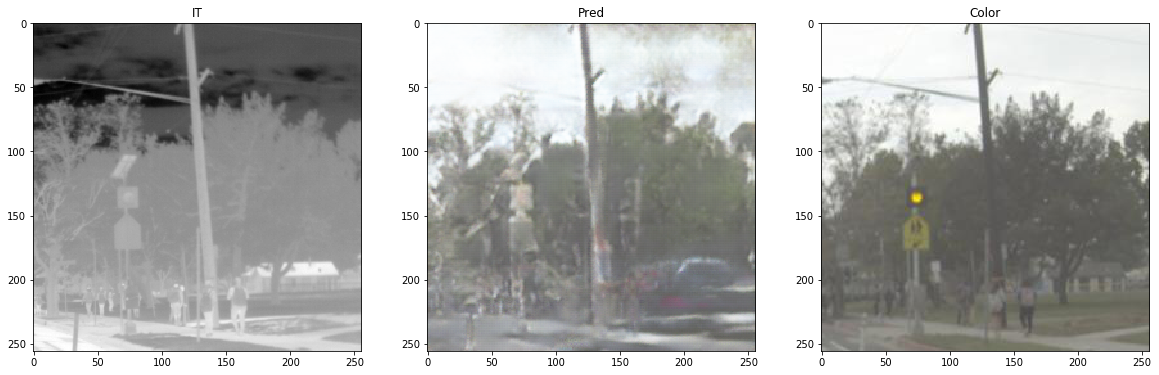

In [39]:
xi = plot_sample(train_crops, g_model, 1, to_lab=False)
#xi = (xi - np.min(xi))/(np.max(xi)-np.min(xi))
#plt.imshow(xi)

In [104]:
yimage_generator = image_datagen.flow(y_train, seed=124, batch_size=1, shuffle=True)
Ximage_generator = image_datagen.flow(X_train, seed=124, batch_size=1, shuffle=True)

train_generator = zip(Ximage_generator, yimage_generator)
train_crops = crop_generator(train_generator, 256)

Text(0.5, 1.0, 'Color')

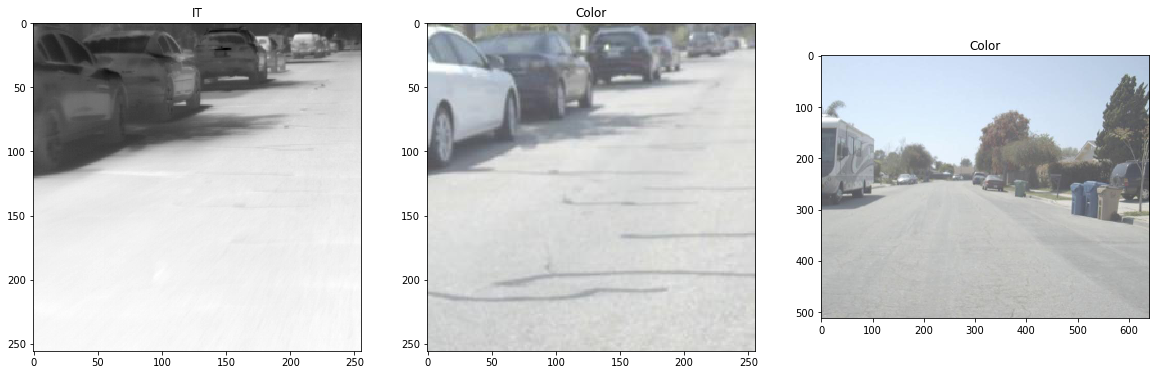

In [24]:


#image_datagen = ImageDataGenerator(**data_gen_args)        

#yimage_generator = image_datagen.flow(y_train, seed=124, batch_size=1, shuffle=False)
#Ximage_generator = image_datagen.flow(X_train, seed=124, batch_size=1, shuffle=False)

#train_generator = zip(Ximage_generator, yimage_generator)
#train_crops = crop_generator(train_generator, 256)
    
i = 0
ind = 5

for x,y in train_crops:
    if i ==ind:
        break
    i +=1
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(x.squeeze())
ax[0].set_title('IT')

ax[1].imshow(y.squeeze())
ax[1].set_title('Color')

ax[2].imshow(y_train[ind].squeeze())
ax[2].set_title('Color')


In [64]:
#g_model.load_weights('g_model_l1_best-salt_cut.h5')
yimage_generator = image_datagen.flow(y_test, seed=2019, batch_size=1, shuffle=True)
Ximage_generator = image_datagen.flow(X_test, seed=2019, batch_size=1, shuffle=True)

train_generator = zip(Ximage_generator, yimage_generator)
train_crops = crop_generator(train_generator, 256)

In [42]:
np.min(xi)

0.34313524